# The Wilson-Cowan model

In this notebook, the basic use of the implementation of the Wilson-Cowan (`wc`) model is presented. 

In the `wc` model, the activity of a particular brain region is defined by a coupled system of excitatory (E) and inhibitory (I) neuronal populations with the mean firing rates of the E and I pools being the dynamic variables, as first described by Wilson and Cowan in 1972 ( H.R. Wilson and J.D. Cowan. *Excitatory and inhibitory interactions in localized populations of model neurons*. Biophys. J., 12:1–24 (1972)) 

In [1]:
# change to the root directory of the project
import os
if os.getcwd().split("/")[-1] == "examples":
    os.chdir('..')
# get the current directory
cwd = os.getcwd()


# Print the current working directory
print("Current working directory: {0}".format(cwd))

Current working directory: /Users/masha/Documents/Uni/Thesis/neurolib


In [2]:
from neurolib.models.wc import WCModel
# Some useful functions are provided here
import neurolib.utils.functions as func
import neurolib.utils.stimulus as stim
import numpy as np
import scipy

In [3]:
import math

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import glob

from neurolib.models.wc import WCModel

import neurolib.utils.loadData as ld
import neurolib.utils.functions as func

# a nice color map
plt.rcParams['image.cmap'] = 'plasma'

In [1332]:
wc = WCModel()
wc.params['duration'] = 2.0*100

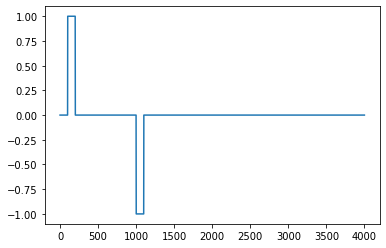

In [329]:
stimulus = np.zeros((1,4000))
stimulus[0][100:200] = 1
stimulus[0][1000:1100] = -1
plt.plot(stimulus.T)



In [8]:
stimulus = stim.StepInput(step_size=0.001,  start=5, end=100, n=1).to_model(wc)


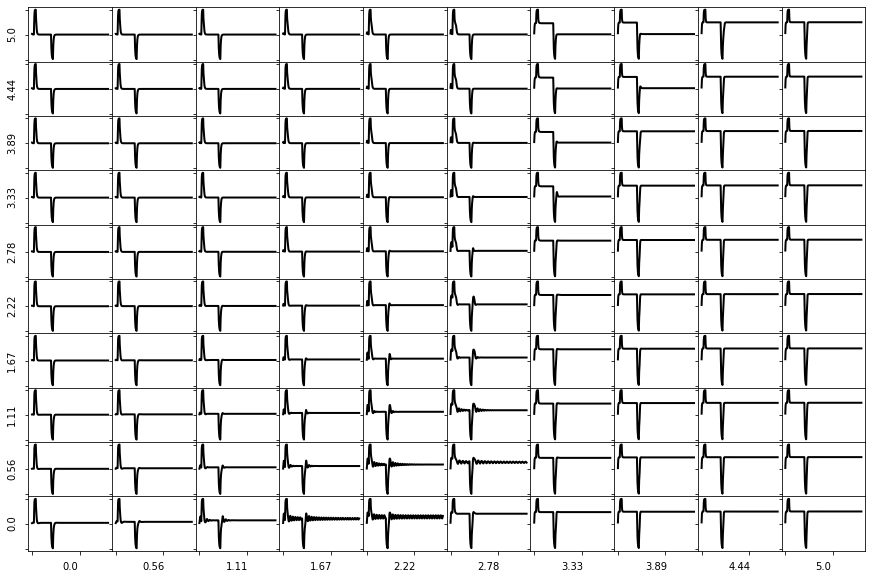

In [331]:
max_exc = []
min_exc = []
ex = []
wc = WCModel()
wc.params['duration'] = 400
wc.params["a_exc"] = 1
wc.params["a_inh"] = 1

#wc.params["c_inhinh"] = 0
#wc.params["c_excinh"] = 0
#wc.params["c_inhexc"] = 0
#wc.params["c_excexc"] = 0
#wc.params["tau_exc"] = 1  
#wc.params["tau_inh"] = 1
#wc.params["exc_ext"] = 0
#wc.params["inh_ext"] = 0
#wc.params["K_gl"] = 0
#wc.params["dt"] = 0.1

wc.params["control_term_E"] = stimulus
# these are the different input values that we want to scan
exc_inputs_n = 10
inh_inputs_n = 10
exc_inputs = np.linspace(0, 5, exc_inputs_n)
inh_inputs = np.linspace(0, 5, inh_inputs_n)

fig,a =  plt.subplots(inh_inputs_n,exc_inputs_n,  sharex='col', sharey='row', figsize=(15,10))

for i, inh_ext in enumerate(inh_inputs):
    for j, exc_ext in enumerate(exc_inputs):
        # Note: this has to be a vector since it is input for all nodes
        # (but we have only one node in this example)
        wc.params['exc_ext'] = exc_ext
        wc.params['inh_ext'] = inh_ext
        #wc.params["control_term_E"] = stimulus
        #wc.params["control_term_I"] = stimulus
        wc.run()

        # we add the maximum and the minimum of the last second of the 
        # simulation to a list
        max_exc.append(np.max(wc.exc[0, -int(200/wc.params['dt']):]))
        min_exc.append(np.min(wc.exc[0, -int(200/wc.params['dt']):]))
        #print(np.shape(wc.exc))
        ex = wc.exc
        
        


        #plt.figure(figsize = (20, 6))
        #plt.plot(range(int(wc.params['duration']/wc.params['dt'])), ex[0].tolist(), c='k', lw = 2)
        #plt.show()
        
        
        #fig, ax = plt.subplots(50, 50, sharex='col', sharey='row')

        #ax[i, j].plot(range(int(wc.params['duration']/wc.params['dt'])), ex[0].tolist(), c='k', lw = 2)

        a[inh_inputs_n-i-1][j].plot(range(int(wc.params['duration']/wc.params['dt'])), ex[0].tolist(), c='k', lw = 2)
        #a[9-i][j].plot(s)

        # Turn off tick labels
        a[inh_inputs_n-i-1][j].set_yticklabels([])
        a[inh_inputs_n-i-1][j].set_xticklabels([])
        
        if(i==0):
            a[inh_inputs_n-i-1][j].set_xlabel(round(exc_ext, 2))
        if(j==0):
            a[inh_inputs_n-i-1][j].set_ylabel(round(inh_ext, 2))
            
        #print(ex[0])
       

        #plt.show()

        #ex = wc.inh
        #plt.plot(range(int(wc.params['duration']/wc.params['dt'])), ex[0].tolist(), c='k', lw = 2)
        #plt.show()

        #print(np.shape(wc.bracets))
        #plt.plot(range(int(wc.params['duration']/wc.params['dt'])), wc.exc[0].tolist(), c='k', lw = 2)
        #plt.show()

plt.subplots_adjust(hspace=.0)
plt.subplots_adjust(wspace=.0)
#fig.tight_layout()
plt.show()

In [475]:
def optimal_control(wc, exc_exp, inh_exp, exc_init, inh_init, n_iter = 5000, plot_freq = 200, w = [0,0], a = 0, debug = False):
    
    #h = (xn-x0)/n_step
    #times = np.arange(0, xn+h, h)
    times = range(int(wc.params['duration']/wc.params['dt']))
    #print(times)
    #u_i = stim.StepInput(step_size=0,  start=0.1, end=0.2, n=1).to_model(wc)
    #print("u_i", u_i)
    #u_e = stim.StepInput(step_size=0,  start=0.1, end=0.2, n=1).to_model(wc)
    #u_i = stimulus
    u_e = exc_init
    u_i = inh_init
    grad = [0,0]

    for l in range(n_iter):
        
        step_size_adj = 10 #0.005
        

        wc.params["control_term_E"] = u_e
        wc.params["control_term_I"] = u_i

        
        wc.run()
        #print("check", wc.brackets_E)
        ex = wc.exc
        inh = wc.inh
        
        if(debug):
            print(np.shape(ex))
            print(int(wc.params['duration']/wc.params['dt']))
        if (l%plot_freq==0):
            #print(np.linalg.norm(step_size_adj*np.array(grad[0])))
            #print(np.linalg.norm(step_size_adj*np.array(grad[1])))
            print("___")
            print("iteration:", l)
            plt.figure(figsize = (20, 6))
            #print(wc.t)
            #print(ex[0].tolist())
            plt.plot(wc.t, exc_exp.T, '--', c = 'r', label="exc_target")
            plt.plot(wc.t, ex[0].tolist(), c='r', lw = 2, label="exc")
            plt.plot(wc.t, u_e.T, ':', c='r', lw = 2,label="stimulus")
            plt.axvspan((a+1)*wc.params['dt'], wc.params['duration'], color='y', alpha=0.2, lw=0)
            #plt.legend()
            #plt.show()
            #plt.plot(wc.t, u_e.T, c='r', lw = 2,label="stimulus")
            #plt.show()
            
            #plt.figure(figsize = (20, 6))
            plt.plot(wc.t, inh_exp.T, '--', c = 'blue',label="inh_target")
            plt.plot(wc.t, inh[0].tolist(), c='blue', lw = 2, label="inh")
            plt.plot(wc.t, u_i.T, ':', c='blue', lw = 2,label="stimulus")
            #plt.axvspan((a+1)*wc.params['dt'], wc.params['duration'], color='y', alpha=0.2, lw=0)
            plt.legend()
            plt.show()
            #plt.plot(wc.t, u_i.T, c='r', lw = 2,label="stimulus")
            #plt.show()
        
        
        
        lambdas = euler_backwards(wc, exc_exp, inh_exp, wc.params['dt'], int(math.ceil(wc.params['duration']/wc.params['dt'])), a, debug)
        if debug:
            print("lambdas", lambdas)
            plt.figure(figsize = (20, 6))
            plt.plot(wc.t, [x[0] for x in lambdas], c='blue', lw = 2, label="lambdas")
            plt.legend()
            plt.show()
        
        #w = [0,0]
        
        grad = grad_f(w, u_e,u_i, lambdas, times, a)
        
        if True:
            if (l%plot_freq==0):
                print("gradient:")
                plt.figure(figsize = (20, 6))
                plt.plot(wc.t, np.array(grad[0]), c='red', lw = 2, label="grad")
                plt.legend()
                plt.show()
        
        #print("grad", np.array(grad[0]))
        #print("lambdas", lambdas)
        
        
        step_size_adj = bisection(wc, step_size_adj,u_e,u_i,grad, times, exc_exp, inh_exp, w, debug, a)
        #if(l == 0):
        #    step_size_adj = 0.1
            
        if debug:
            print("step", step_size_adj)
            print("step_new", step_size_adj*np.array(grad[0]))

        u_e = u_e-step_size_adj*np.array(grad[0])
        u_i = u_i-step_size_adj*np.array(grad[1])
        
        eps_u = 0#10**(-7)
        
        
        if np.linalg.norm(step_size_adj*np.array(grad[0])) < eps_u and np.linalg.norm(step_size_adj*np.array(grad[1])) < eps_u:
            print("iteration:", l)
            print(np.linalg.norm(step_size_adj*np.array(grad[0])))
            print(np.linalg.norm(step_size_adj*np.array(grad[1])))
            plt.figure(figsize = (20, 6))
            plt.plot(wc.t, exc_exp.T, c = 'blue',label="exc_target")
            plt.plot(wc.t, ex[0].tolist(), c='k', lw = 2, label="exc")
            plt.plot(wc.t, u_e.T, c='r', lw = 2,label="stimulus")
            plt.axvspan(b*wc.params['dt'], wc.params['duration'], color='y', alpha=0.2, lw=0)
            plt.legend()
            plt.show()
            break

            
            

In [433]:
def bisection(model, step_size, u_e, u_i, grad, times, exc_exp, inh_exp, w, debug = False, b = 0):
    cost_temp = cost_f(w, model.exc[0], exc_exp, model.inh[0], inh_exp,  u_e, u_i, times, b)
    #print("c_t", cost_temp)
    while step_size > 10*(-8):

        u_e_1 = u_e-step_size*np.array(grad[0])
        u_i_1 = u_i-step_size*np.array(grad[1])

        model.params["control_term_E"] = u_e_1
        model.params["control_term_I"] = u_i_1


        model.run()
        ex = model.exc
        inh = model.inh
        
        if debug:
            print("step: ", step_size)
            plt.figure(figsize = (8, 5))
            plt.plot(model.t, exc_exp.T,c = 'blue', label="exc_target")
            plt.plot(model.t, ex[0].tolist(), c='k', lw = 2, label="exc")
            plt.plot(model.t, u_e_1.T, c='r', lw = 2, label="stimulus")
            plt.legend()
            plt.show()

        cost = cost_f(w, ex[0], exc_exp, inh[0], inh_exp, u_e_1, u_i_1, times, b)
        if debug:
            print("cost", cost)
            print("step_size", step_size)
        #step_size = step_size/2
        #cost_temp = cost
        
        if(cost>cost_temp):
            step_size = step_size/2
            #cost_temp = cost.copy()
            #print("loop_cost", cost)
        else:
            #print("cost", cost)
            #print("step_size", step_size)
            return step_size
    
    print("zero step size")
    return 0
        

def cost_f(w, x, x_, y,y_,u_exc, u_inh, times, b = 0):
    
    #return np.sum(1/2*(x_-x)**2) 
    x_new = x[b:]
    x_new_ = x_[b:]
    y_new = y[b:]
    y_new_ = y_[b:]
    times_new = times[b:]
    return scipy.integrate.simps(0.5*((x_new_-x_new)**2 + (y_new_-y_new)**2),times_new) \
            + w[0] * ((np.sqrt(scipy.integrate.simps(u_exc**2, times))) \
             + np.sqrt(scipy.integrate.simps(u_inh**2, times))) \
                + w[1] * 0.5*(scipy.integrate.simps(u_inh**2 + u_exc**2, times))
    #return  0.3 * (np.sqrt(scipy.integrate.simps(u_exc**2, times)) \
    #        + np.sqrt(scipy.integrate.simps(u_inh**2, times)) \
    #        + 0.5 * scipy.integrate.simps(u_exc**2 + u_inh**2, times)) \
    #        + scipy.integrate.simps((x-x_)**2,times)

In [434]:
def S_E(x, model):
    a_exc = model.params["a_exc"]
    mu_exc = model.params["mu_exc"]
    return 1.0 / (1.0 + np.exp(-a_exc * (x - mu_exc)))
    #return 1.0/(np.exp(-a_exc*(x-mu_exc))+1.0)
    

def S_I(x, model):
    a_inh = model.params["a_inh"]
    mu_inh = model.params["mu_inh"]
    #return 1.0/(np.exp(-a_inh*(x-mu_inh))+1.0)
    return 1.0 / (1.0 + np.exp(-a_inh * (x - mu_inh)))

def dh1_dE(model, i):
    a_exc = model.params["a_exc"]
    C_EE = model.params["c_excexc"]
    mu_exc = model.params["mu_exc"]
    brackets_E = model.brackets_E[0][i]
    E_j = model.exc[0][i]

    return -1-S_E(brackets_E, model)+(a_exc*np.exp(-a_exc * ( brackets_E - mu_exc)))*(S_E(brackets_E, model)**2)*C_EE*(1-E_j)
    #return -1-S_E(brackets_E, model)+(a_exc*np.exp(-a_exc*(brackets_E - mu_exc))/(1 + np.exp(-a_exc*(brackets_E - mu_exc)))**2)*C_EE*(1-E_j)
    #return -1

def dh2_dI(model, i):
    a_inh = model.params["a_inh"]
    mu_inh = model.params["mu_inh"]
    C_II = model.params["c_inhinh"]
    brackets_I = model.brackets_I[0][i]
    I_j = model.inh[0][i]
    #return -1-S_I(brackets_I, model)+(a_inh * np.exp(-a_inh *(brackets_I - mu_inh))/(1 + np.exp(-a_inh *(brackets_I - mu_inh)))**2)*(-C_II)*(1-I_j)
    return -1-S_I(brackets_I, model)+(a_inh*np.exp(-a_inh * (brackets_I - mu_inh)))*(S_I(brackets_I, model)**2)*(-C_II)*(1-I_j)
    #return -1
def dh1_dI(model, i):
    a_exc = model.params["a_exc"]
    C_IE = model.params["c_inhexc"]
    mu_exc = model.params["mu_exc"]
    brackets_E = model.brackets_E[0][i]
    E_j = model.exc[0][i]
    #return 0 
    #return (1-E_j)*(a_exc*np.exp(-a_exc*(brackets_E - mu_exc))/(1 + np.exp(-a_exc*(brackets_E - mu_exc)))**2)*(-C_IE)
    return (1-E_j)*(a_exc*np.exp(-a_exc * (brackets_E - mu_exc)))*(S_E(brackets_E, model)**2)*(-C_IE)

def dh2_dE(model, i):
    a_inh = model.params["a_inh"]
    mu_inh = model.params["mu_inh"]
    C_EI = model.params["c_excinh"]
    brackets_I = model.brackets_I[0][i]
    I_j = model.inh[0][i]
    #return 0 
    return (1-I_j)*(a_inh*np.exp(-a_inh * (brackets_I - mu_inh)))*(S_I(brackets_I, model)**2)*C_EI
    #return (1-I_j)*(a_inh*np.exp(-a_inh*(brackets_I - mu_inh))/(1 + np.exp(-a_inh*(brackets_I - mu_inh)))**2)*C_EI

    
def lambda_der(model, lambdas, ex_exp, inh_exp, i,a, debug = False):
    
    lambda_ind = i
    i2 = i
    
    
    tauE = model.params["tau_exc"]
    tauI = model.params["tau_inh"]
    
    Dx_doth = np.array([[ -1*tauE, 0], 
                  [0, -1*tauI]])
    
    if(i >= a):
        Dxf = np.array([model.exc[0][i2]-ex_exp[i2], model.inh[0][i2]-inh_exp[i2]])
    else:
        Dxf = np.array([0,0])
    
    Dxh = np.array([[ dh1_dE(model,i2), dh1_dI(model, i2)], 
                  [dh2_dE(model, i2), dh2_dI(model, i2)]])
    if debug:
        #print("a", model.exc[0][i])
        #print("b", ex_exp[i])
        print("Dxh", Dxh)
        print("Dxf", Dxf)
        print("lambdas[i]",lambdas[lambda_ind])
        print("lambdas[i]@Dxh",lambdas[lambda_ind]@Dxh)
        print("Dxf + lambdas[i]@Dxh", Dxf + lambdas[lambda_ind]@Dxh)
        print((Dxf + lambdas[i2]@Dxh)@np.linalg.inv(Dx_doth))
        print("__________________________________")
    
    return (Dxf + lambdas[lambda_ind]@Dxh)@np.linalg.inv(Dx_doth) #i+1 or i????

def euler_backwards(model, ex_exp, inh_exp, step, n, a, debug = False):
     
    lambdas = [[0,0] for i in range(n)]
    
    #inh = wc.inh[0]
    #ex = wc.exc[0]
    if debug:
        print("exc", model.exc[0])
        print("exc_exp", ex_exp)
    
    for i in range(n-2,-1,-1):
        lambdas[i] = lambdas[i+1]-step*lambda_der(model, lambdas, ex_exp, inh_exp, i+1, a, debug) #i+1 or i

    return lambdas

def grad_f(w, u_e, u_i, lambdas, times, a): ##TODO add cost components
    #a = 0
    #if a > 0:
    #    v1 = [0]*a
    #    v1.extend([x[0] for x in lambdas])
    #    v2 = [0]*a
    #    v2.extend([x[1] for x in lambdas])
    #else:
    v1 = [x[0] for x in lambdas]
    v2 = [x[1] for x in lambdas]
    lambda_list = [v1,v2]
    
    
    f_list = [(w[0]*u_e[0]).tolist(), (w[0]*u_i[0]).tolist()]
    
    
    u_e_mul = (np.sqrt(scipy.integrate.simps(u_e[0]**2, times)))
    u_i_mul = (np.sqrt(scipy.integrate.simps(u_i[0]**2, times)))
    if(u_e_mul != 0):
        f_e = [w[1]*u/u_e_mul for u in u_e[0]]
    else:
        f_e = np.zeros(len(u_e[0]))
        
    if(u_i_mul != 0):
        f_i = [w[1]*u/u_i_mul for u in u_i[0]]
    else:
        f_i = np.zeros(len(u_i[0]))
        
        
        
    summed = [[x + y + z for (x, y, z) in zip(f_list[0], lambda_list[0], f_e)],[x + y + z for (x, y, z) in zip(f_list[1], lambda_list[1], f_i)]]

    #summed = [[x + y for (x, y) in zip(f_list[0], lambda_list[0])],[x + y  for (x, y) in zip(f_list[1], lambda_list[1])]]
    return summed
    #return summed
    #return [[x[0] for x in lambdas],[x[1] for x in lambdas]] + [0.3*np.abs(u_e).tolist(), 0.3*np.abs(u_i).tolist()] 
            #+ [(1/np.sqrt(scipy.integrate.simps(u_e**2, times)))*u_e, (1/np.sqrt(scipy.integrate.simps(u_i**2, times)))*u_i]
    

# Better example

In [466]:
from neurolib.models.wc import WCModel
wc = WCModel()


wc.params['exc_ext'] = 3.33
wc.params['inh_ext'] = 5#3.89


#wc.params["a_exc"] = 1
#wc.params["a_inh"] = 1

#wc.params["c_inhinh"] = 0
#wc.params["c_excinh"] = 0
#wc.params["c_inhexc"] = 0
#wc.params["c_excexc"] = 0
#wc.params["tau_exc"] = 1  
#wc.params["tau_inh"] = 1
#wc.params["exc_ext"] = 0
#wc.params["inh_ext"] = 0
#wc.params["K_gl"] = 0
#wc.params["dt"] = 0.1


wc.params['duration'] = 250
#wc.run()



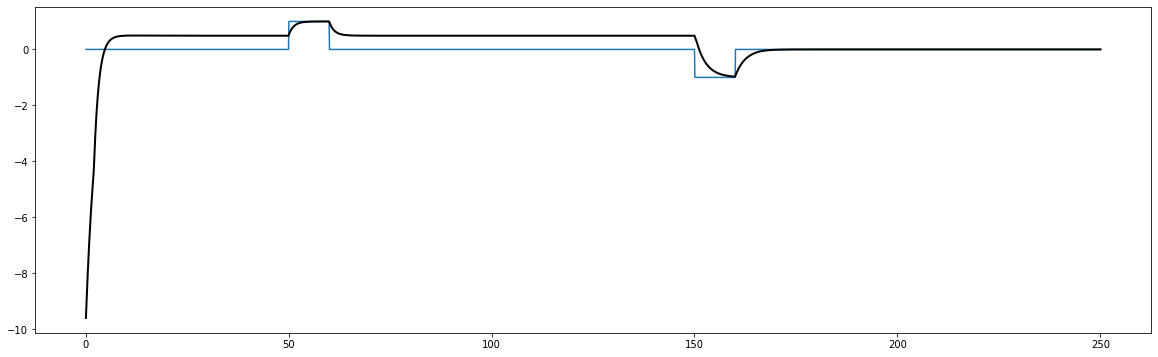

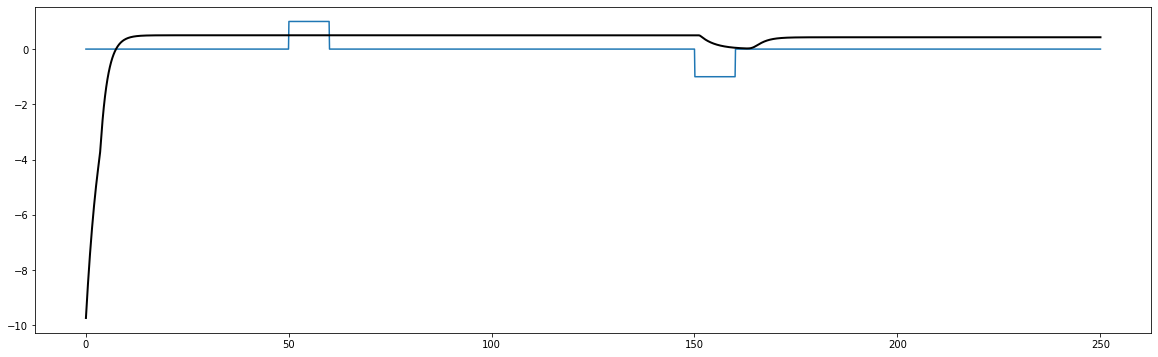

wc.exc [-9.60000000e+00 -9.21600000e+00 -8.84736000e+00 ...  7.51186179e-04
  7.51186179e-04  7.51186179e-04]
wc.inh [-9.73333333 -9.47377778 -9.2211437  ...  0.42807678  0.42807678
  0.42807678]
wc.inh 0.4999981060318109
target_low[:] = 0.000751
target_low_inh[:] = 0.428077
wc.params["exc_init"] = [[0.490690]]
wc.params["inh_init"] =[[0.499998]]
wc.exc 0.49069020830108123


In [469]:
#stimulus
#stimulus = np.zeros((1,1000))
#stimulus[0][200:400] = 2
#stimulus[0][10000:11000] = -1
#plt.plot(stimulus.T)

stimulus = np.zeros((1,2500))
stimulus[0][500:600] = 1
stimulus[0][1500:1600] = -1
#plt.plot(stimulus.T)

wc.params["exc_init"] = [[-10]]
wc.params["inh_init"] =[[-10]]


wc.params["control_term_E"] = stimulus
#wc.params["control_term_I"] = stimulus
wc.run()

plt.figure(figsize = (20, 6))
plt.plot(wc.t, stimulus.T)
plt.plot(wc.t, wc.exc[0].tolist(), c='k', lw = 2)
plt.show()

plt.figure(figsize = (20, 6))
plt.plot(wc.t, stimulus.T)
plt.plot(wc.t, wc.inh[0].tolist(), c='k', lw = 2)
plt.show()
#print(wc.params["a_exc"])
print("wc.exc",wc.exc[-1])
print("wc.inh",wc.inh[-1])
print("wc.inh",wc.inh[0][1300])
print('target_low[:] = {:f}'.format(wc.exc[-1][-1]))
print('target_low_inh[:] = {:f}'.format(wc.inh[-1][-1]))

print('wc.params["exc_init"] = [[{:f}]]'.format(wc.exc[0][1300]))
print('wc.params["inh_init"] =[[{:f}]]'.format(wc.inh[0][1300]))





print("wc.exc",wc.exc[0][1300])
#0.02788229

target_low = wc.exc[0]
target_low_inh = wc.inh[0]


In [472]:
target_low = np.zeros(2500)
target_low_inh = np.zeros(2500)

target_low[:] = 0.000751
target_low_inh[:] = 0.428077


#target_low[:] = 0.01093725 #0.02788229 
#target_low_inh[:] = 0.41653832 #0.35820838 

___
iteration: 0


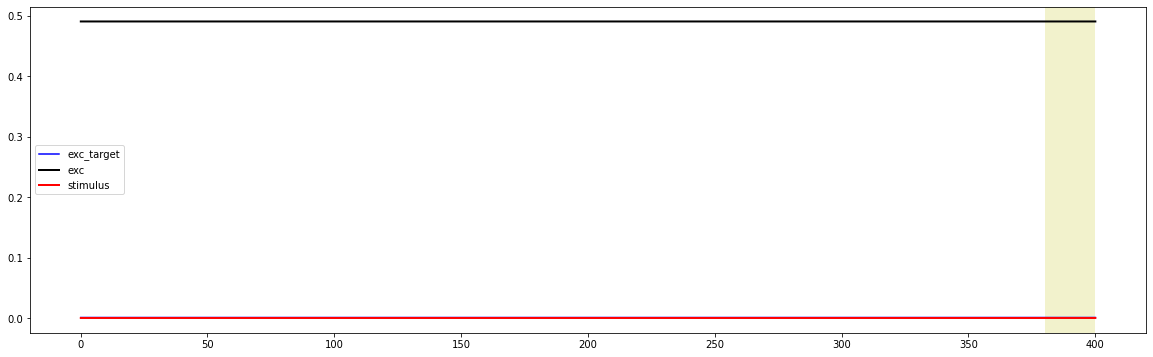

gradient:


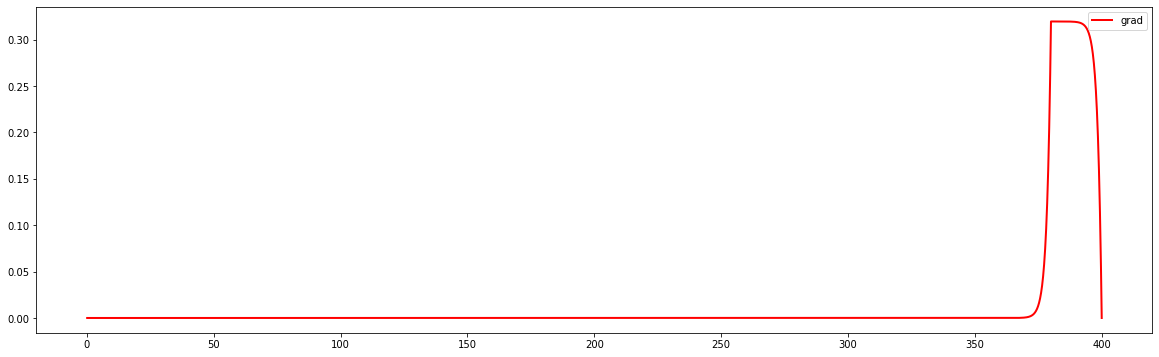

___
iteration: 200


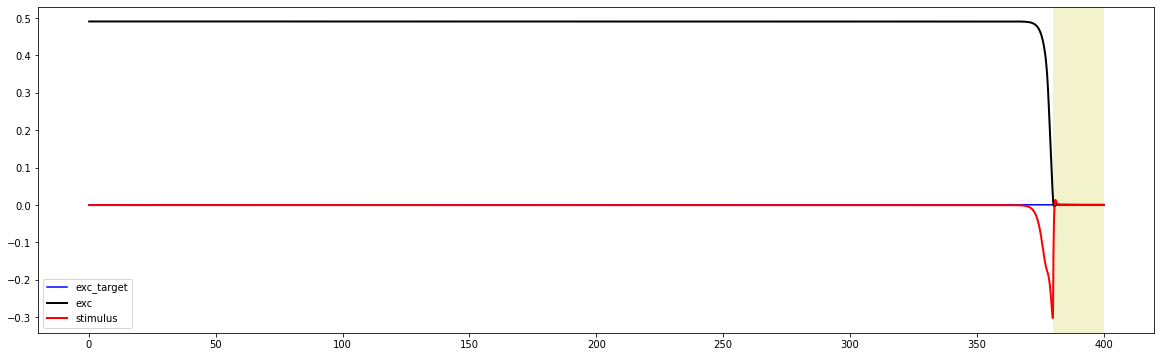

gradient:


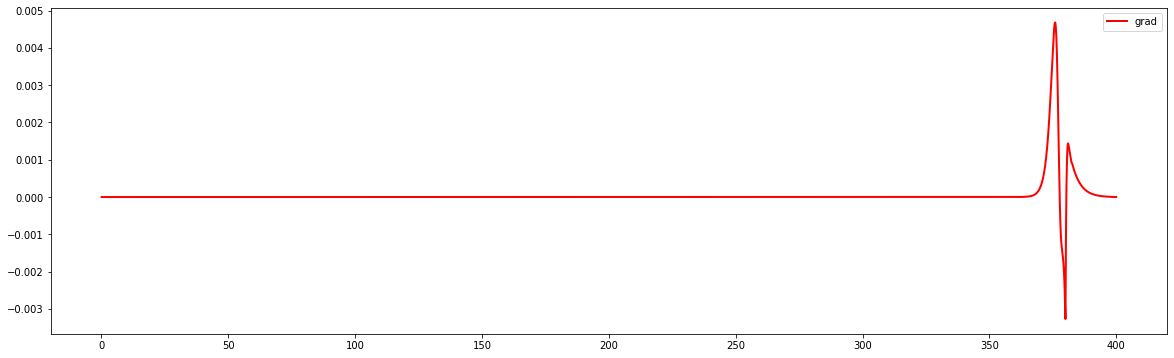

___
iteration: 400


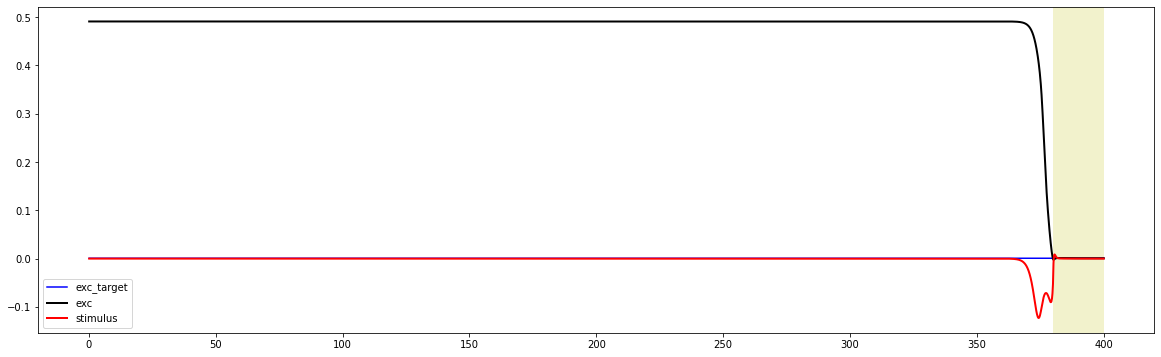

gradient:


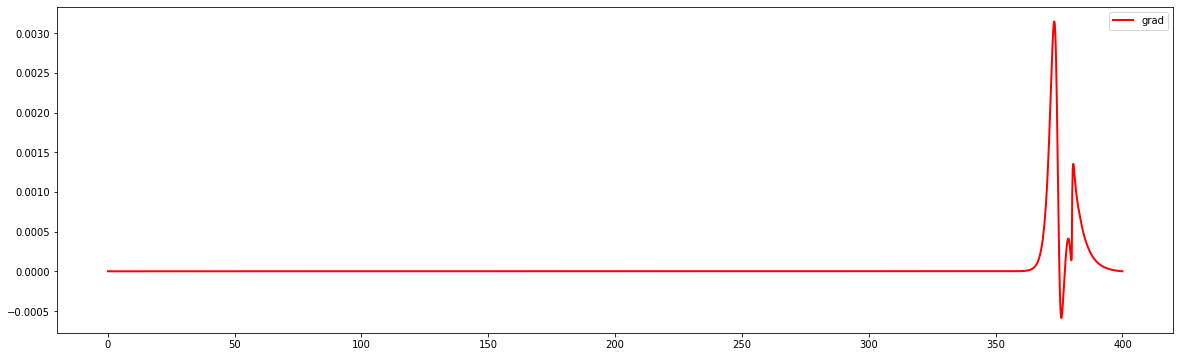

___
iteration: 600


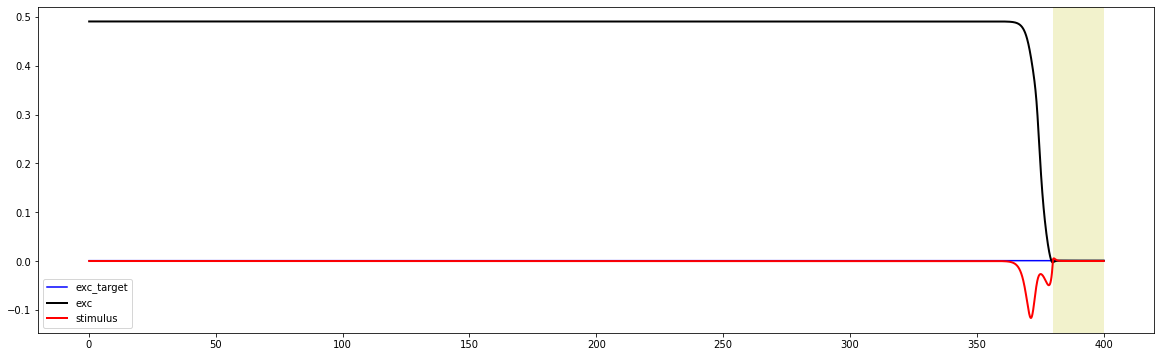

gradient:


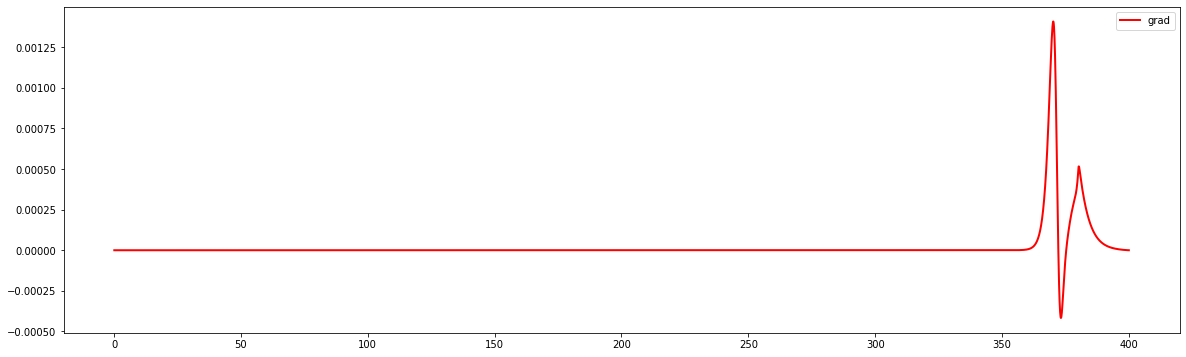

___
iteration: 800


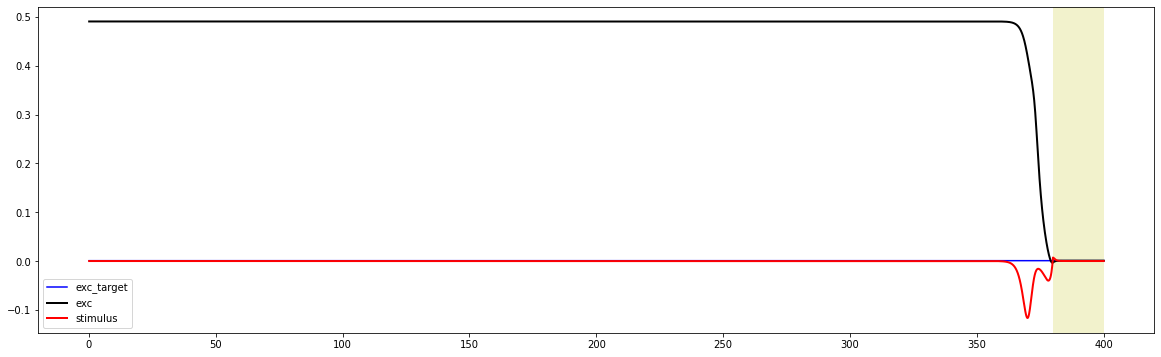

gradient:


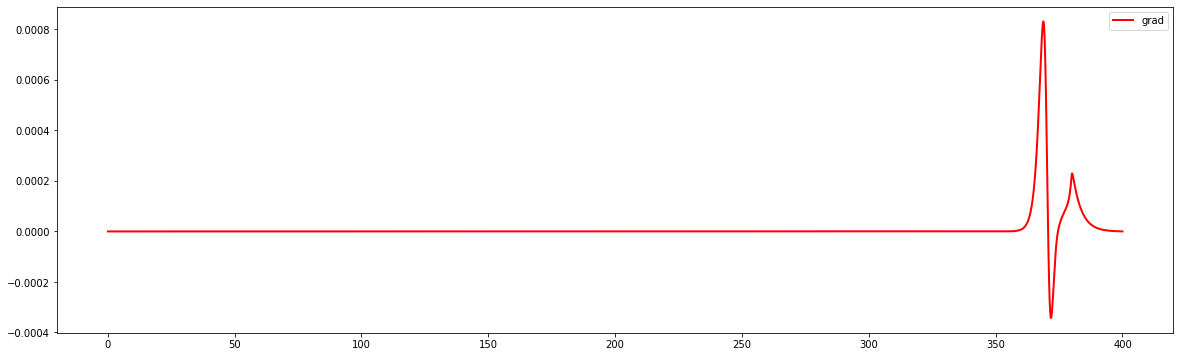

___
iteration: 1000


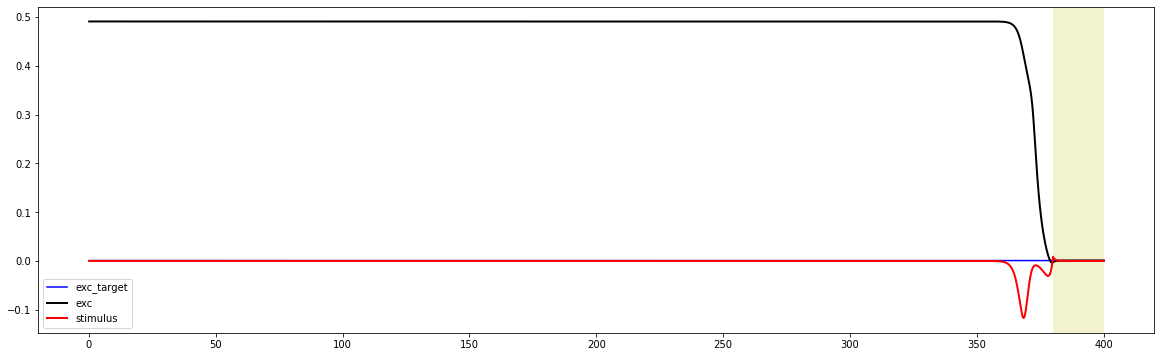

gradient:


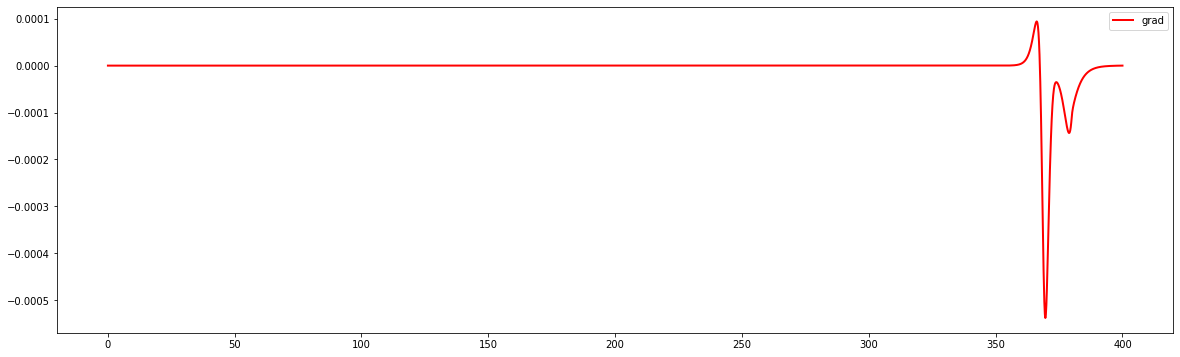

___
iteration: 1200


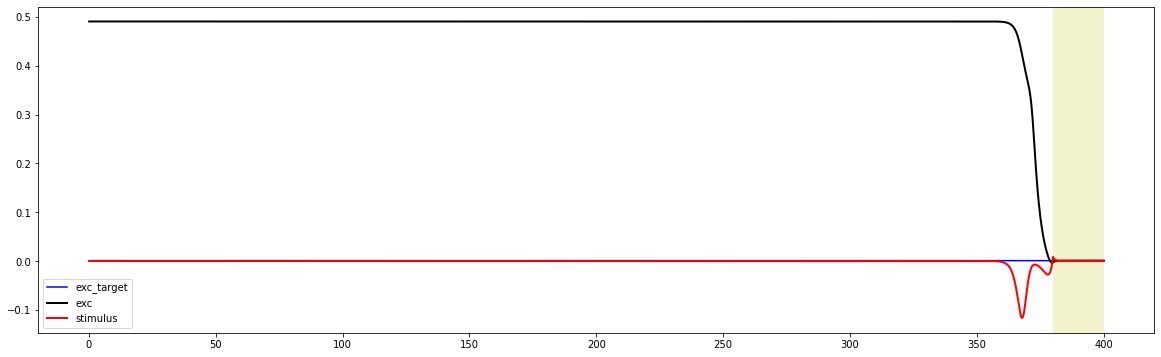

gradient:


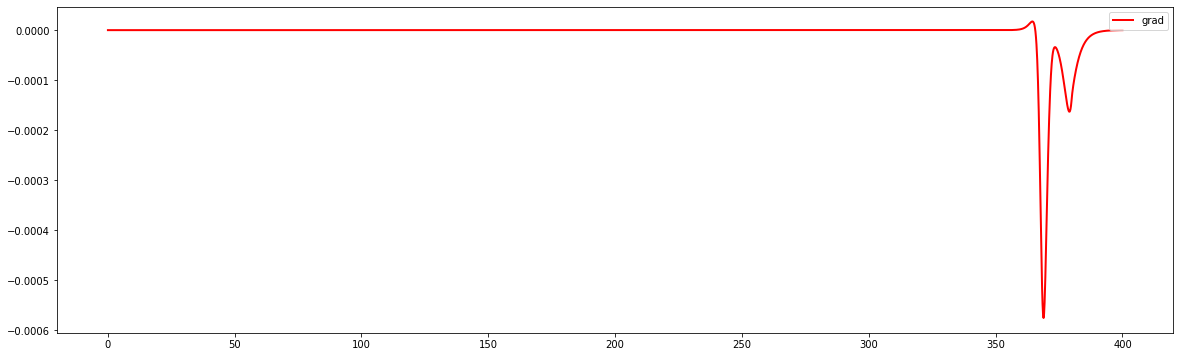

___
iteration: 1400


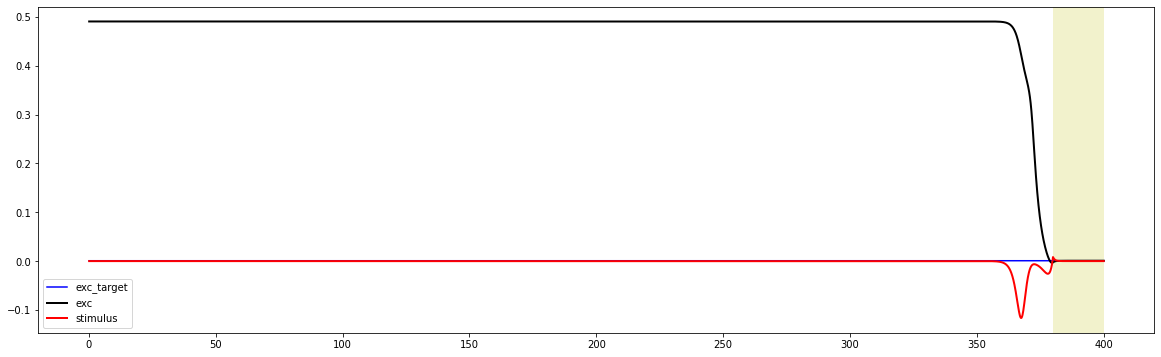

gradient:


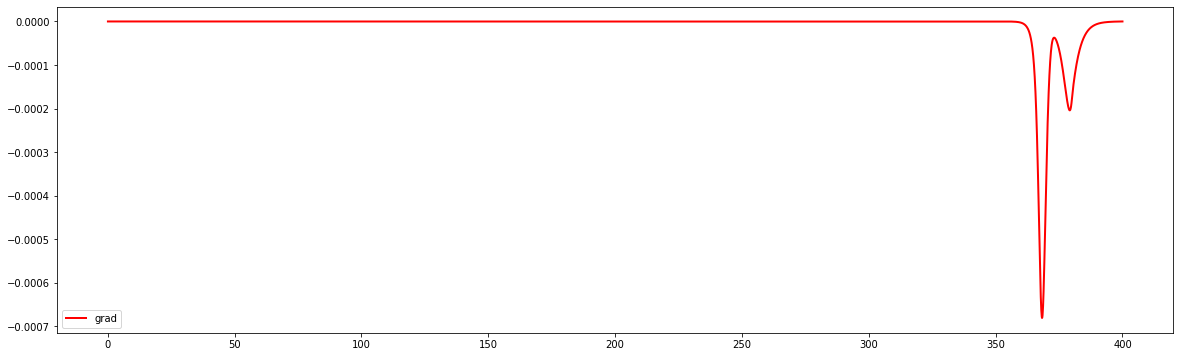

___
iteration: 1600


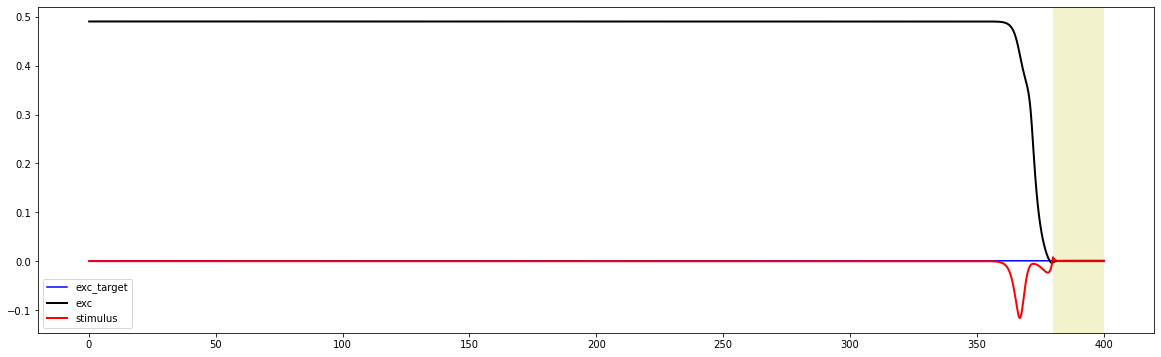

gradient:


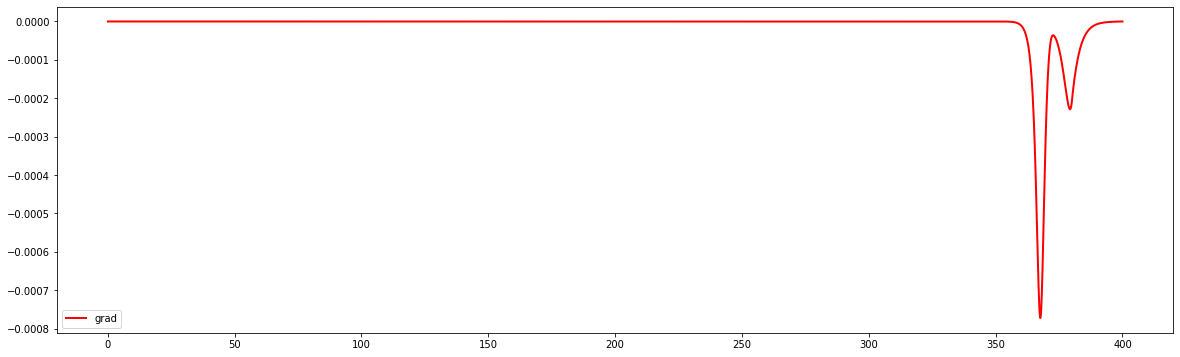

___
iteration: 1800


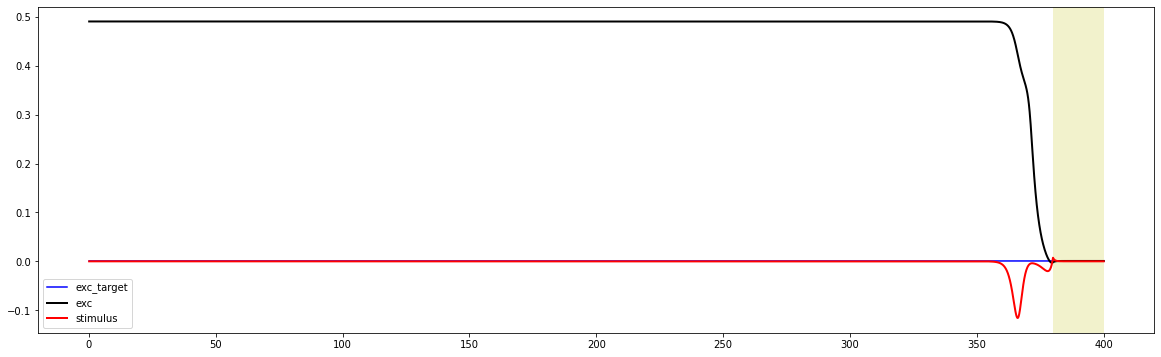

gradient:


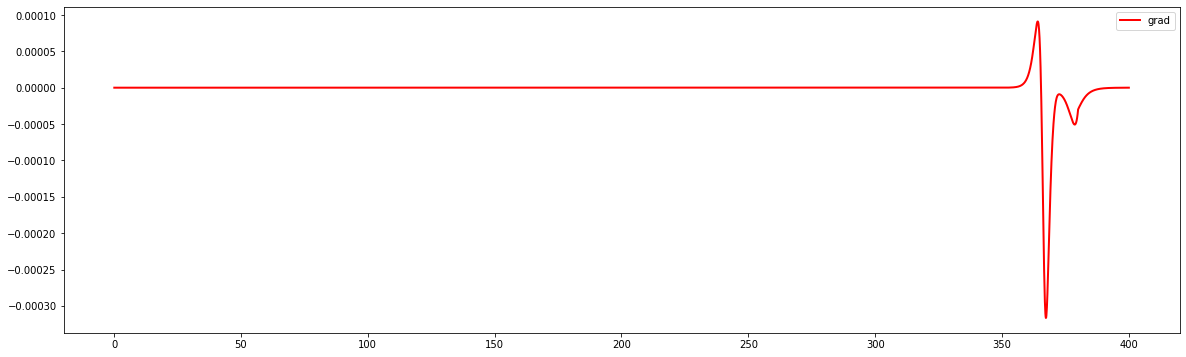

___
iteration: 2000


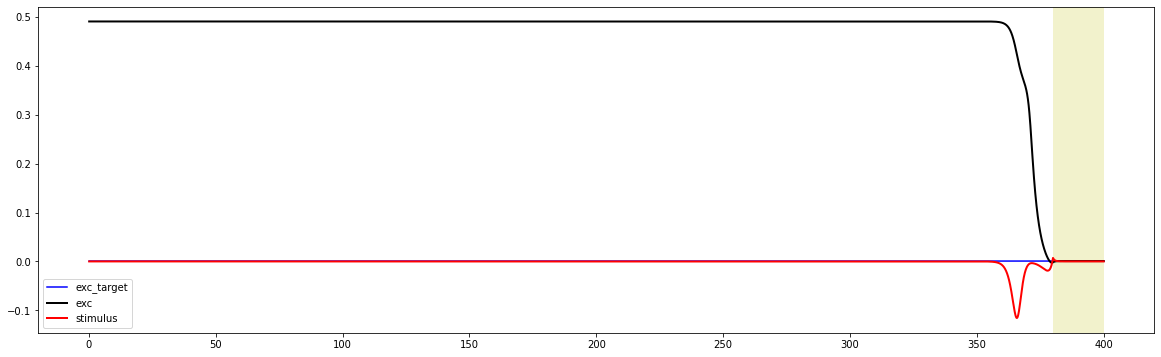

gradient:


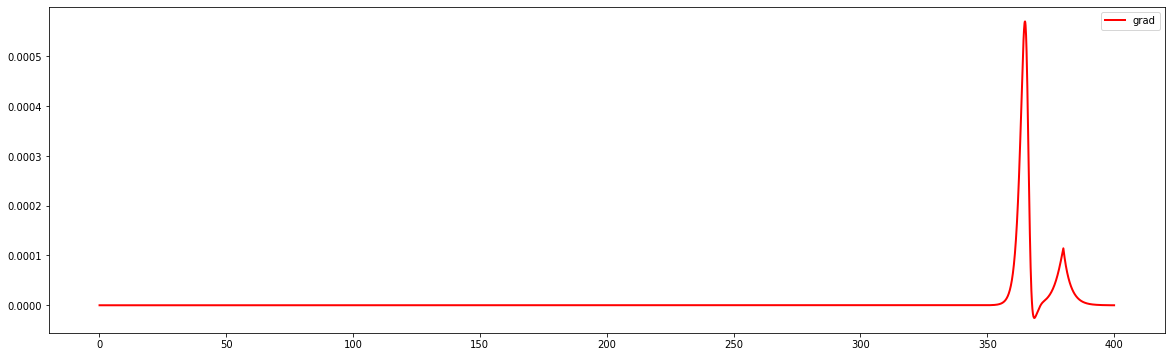

___
iteration: 2200


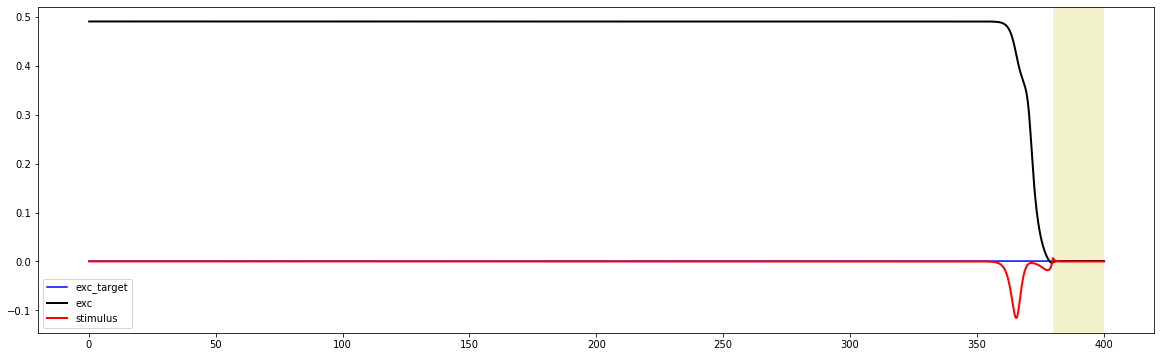

gradient:


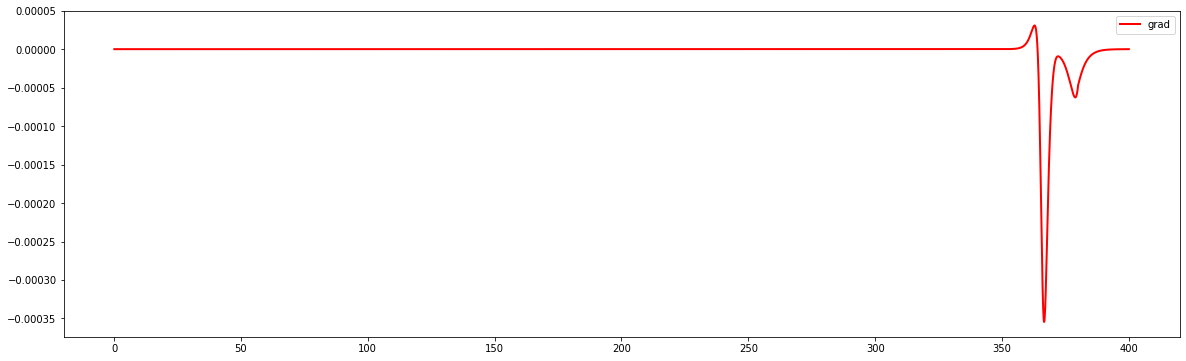

___
iteration: 2400


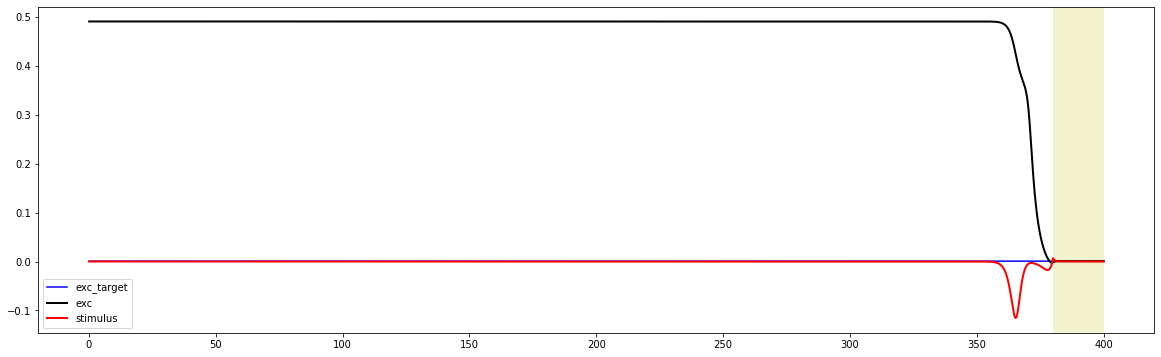

gradient:


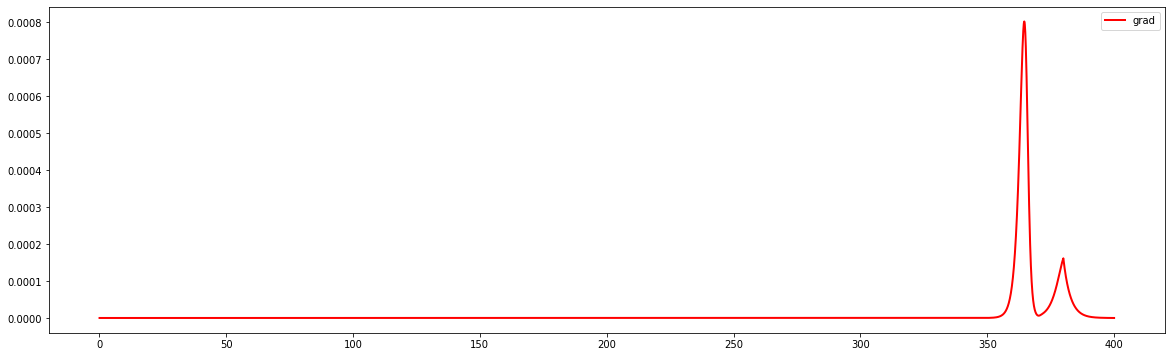

___
iteration: 2600


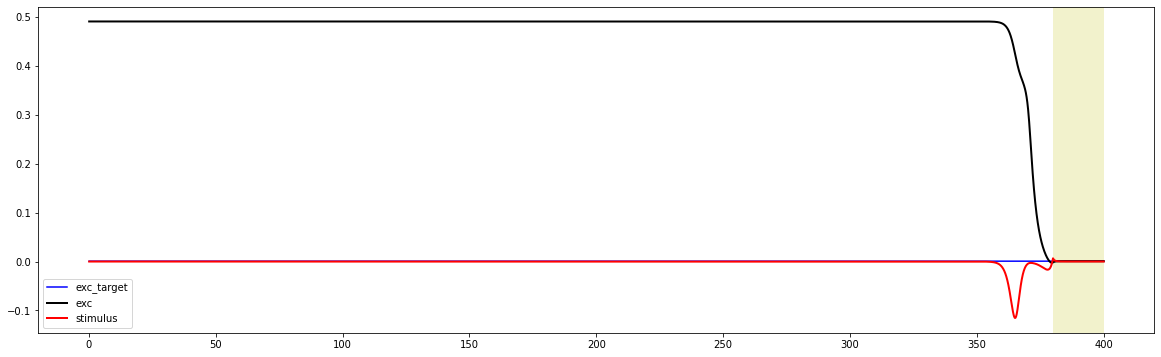

gradient:


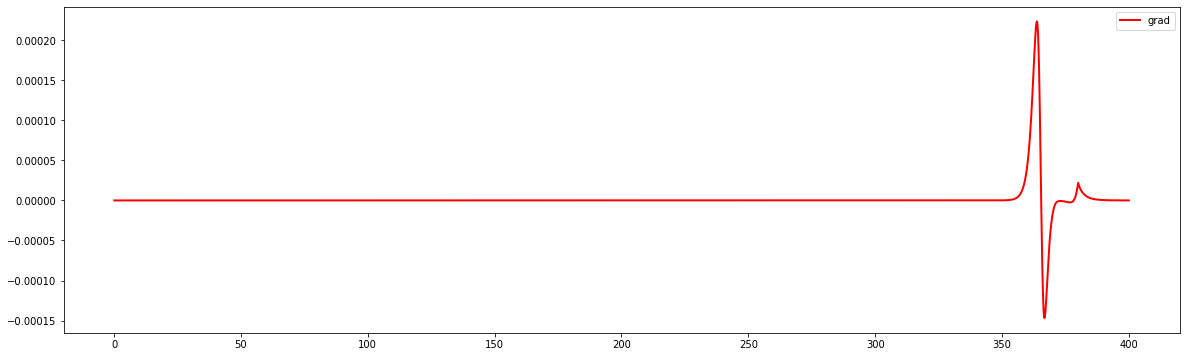

___
iteration: 2800


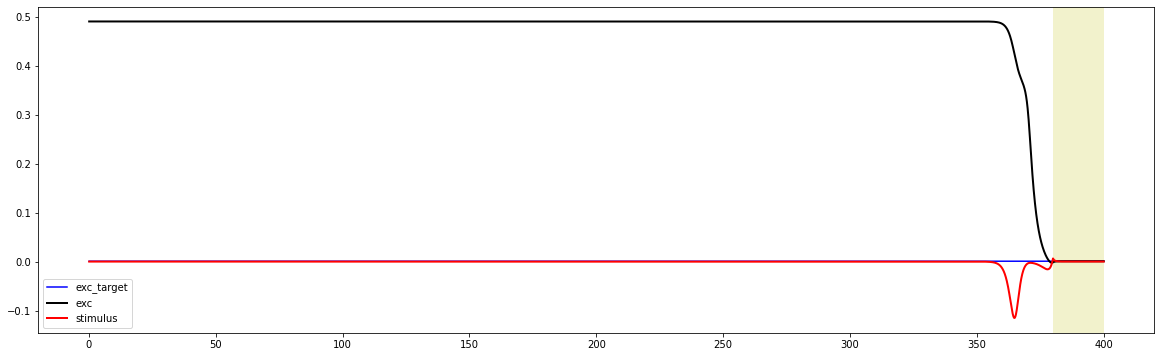

gradient:


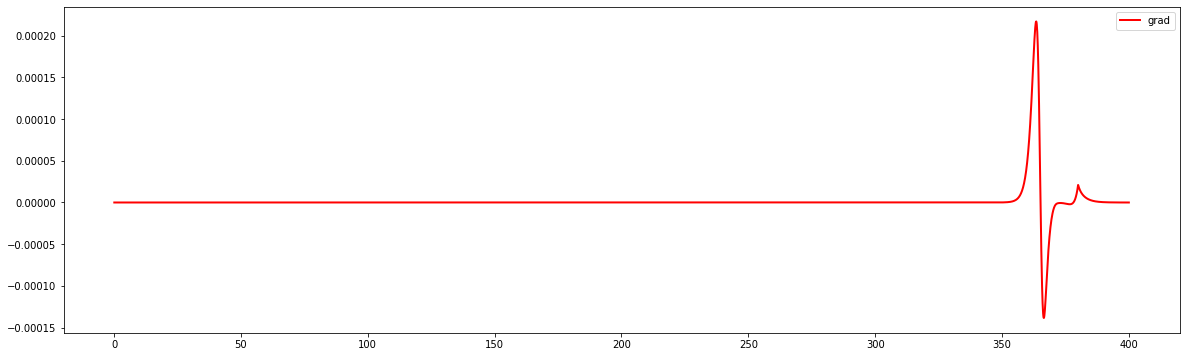

___
iteration: 3000


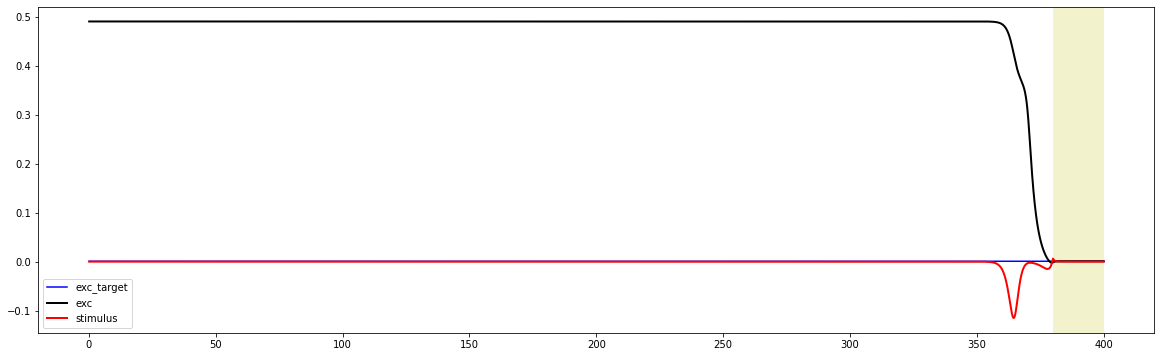

gradient:


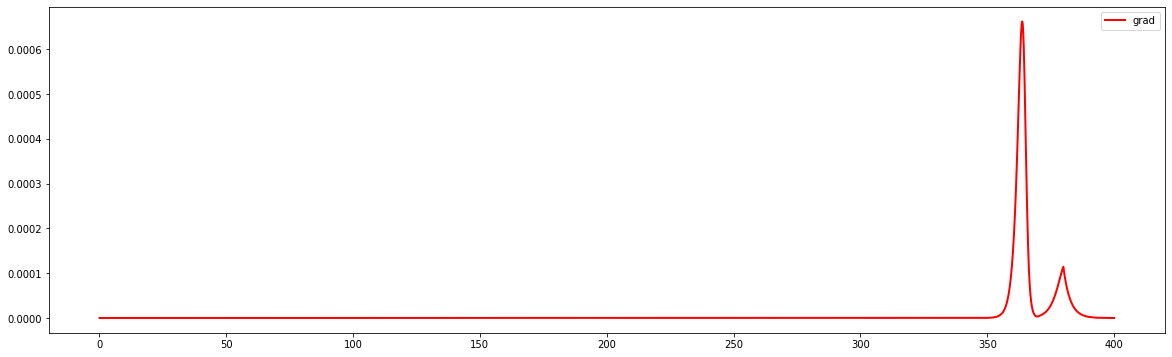

___
iteration: 3200


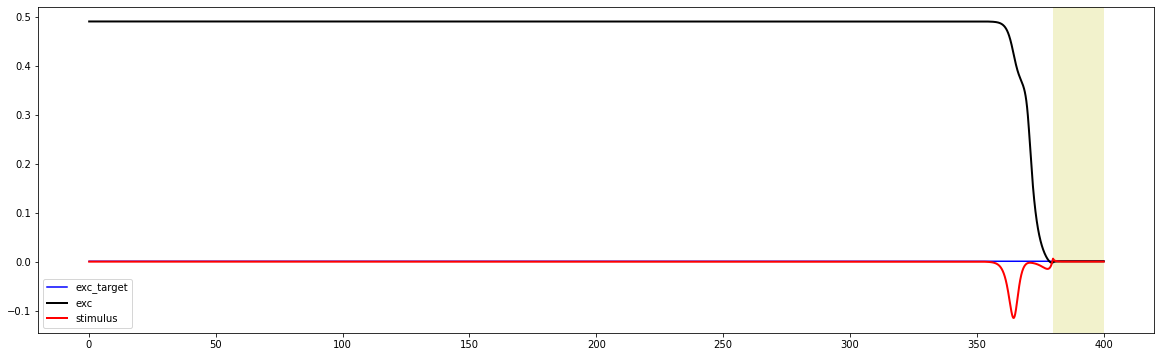

gradient:


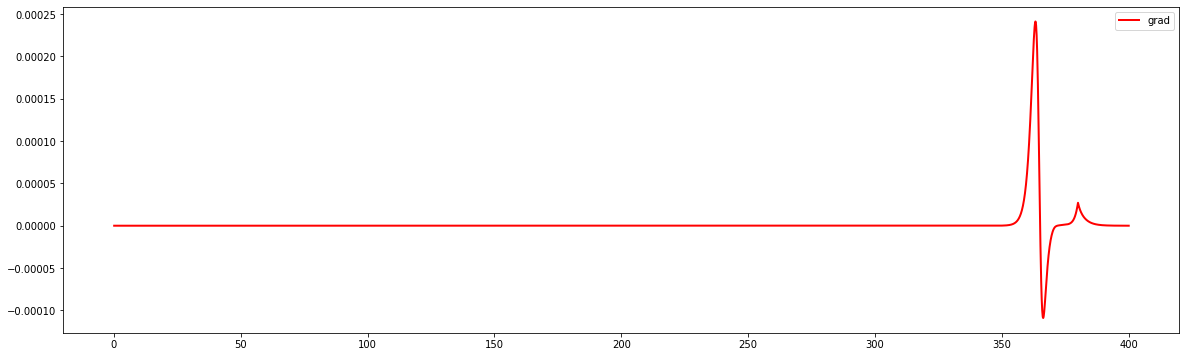

___
iteration: 3400


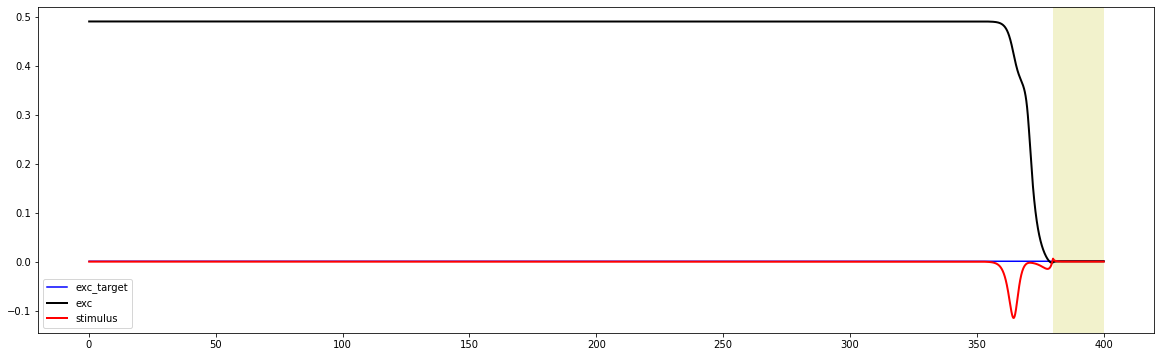

gradient:


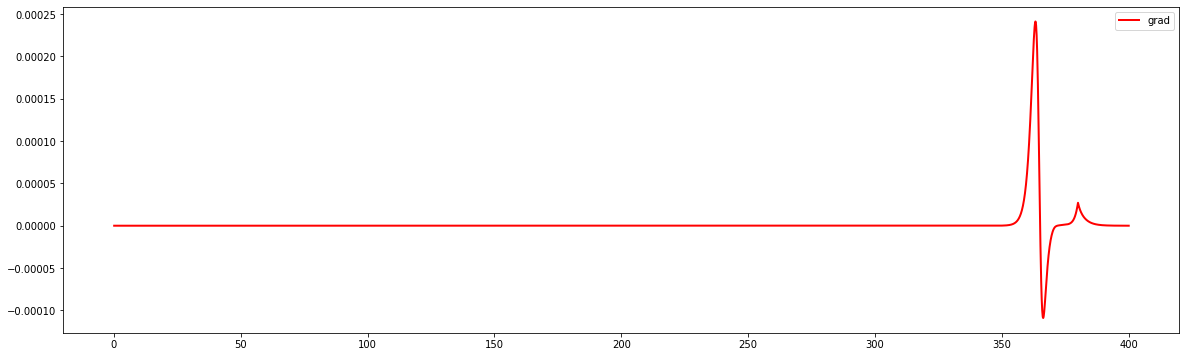

___
iteration: 3600


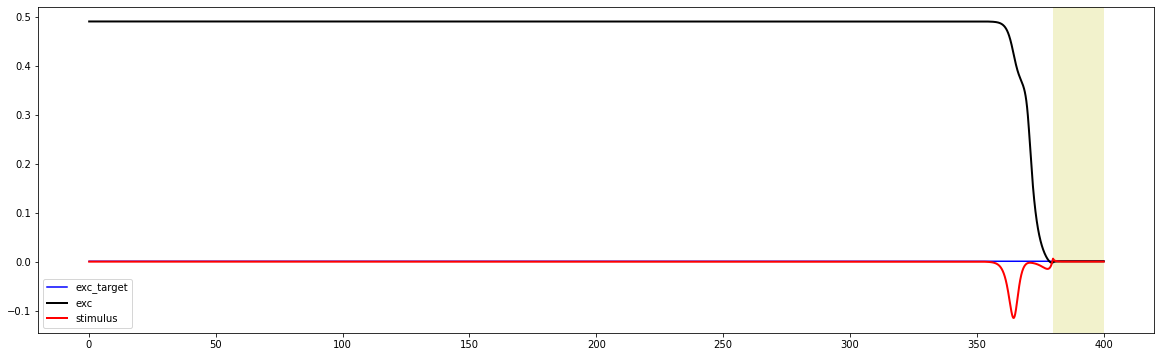

gradient:


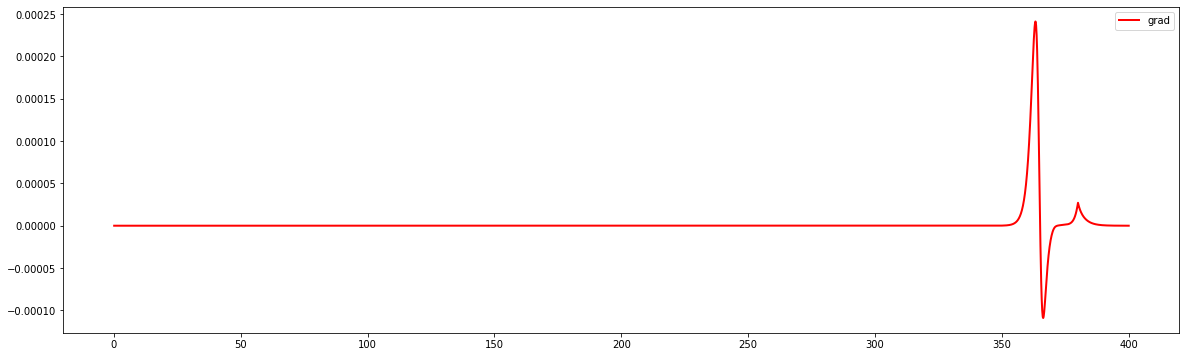

___
iteration: 3800


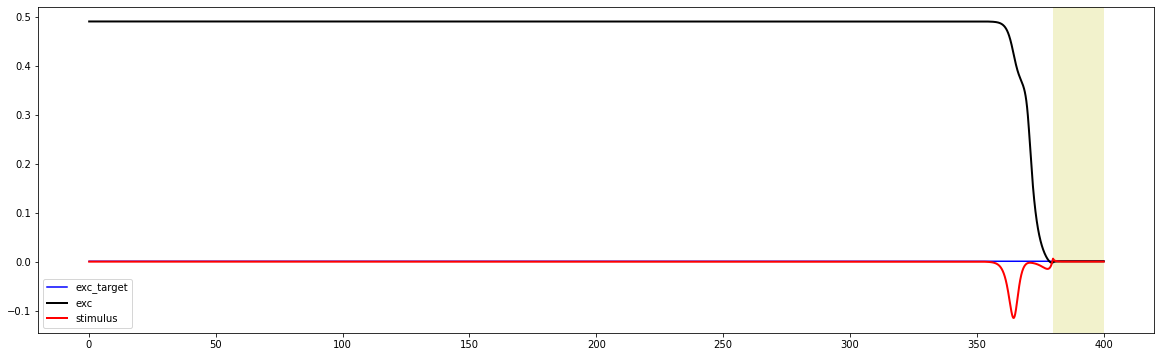

gradient:


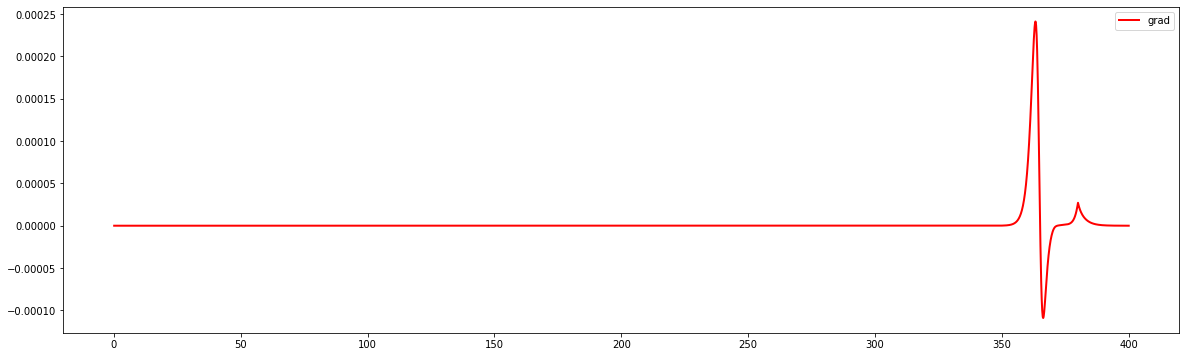

___
iteration: 4000


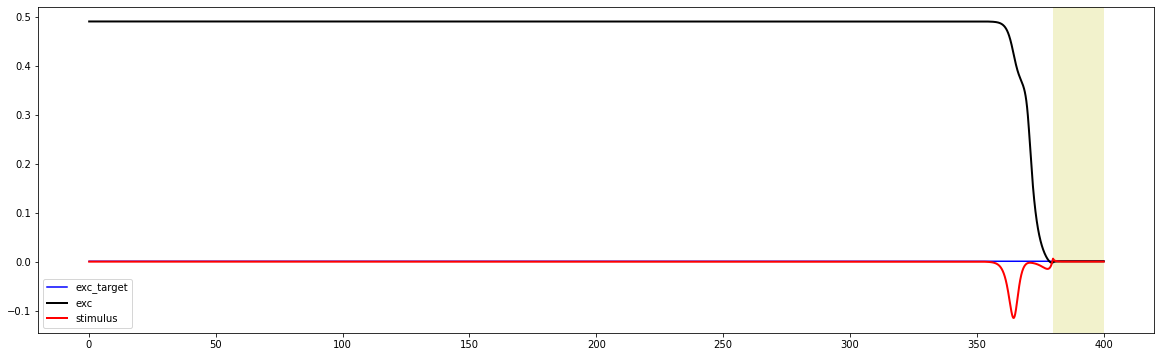

gradient:


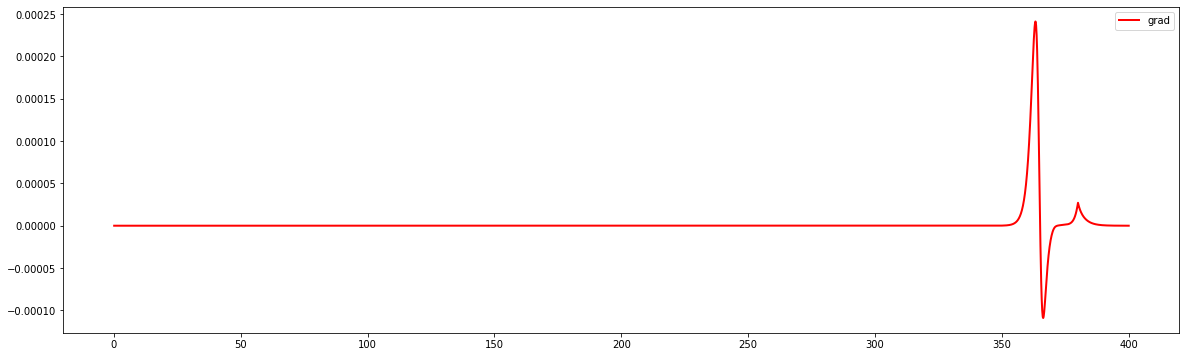

___
iteration: 4200


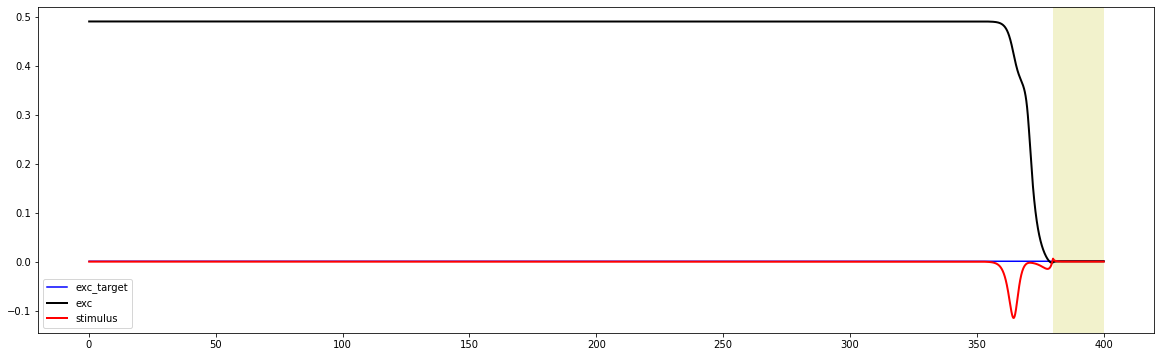

gradient:


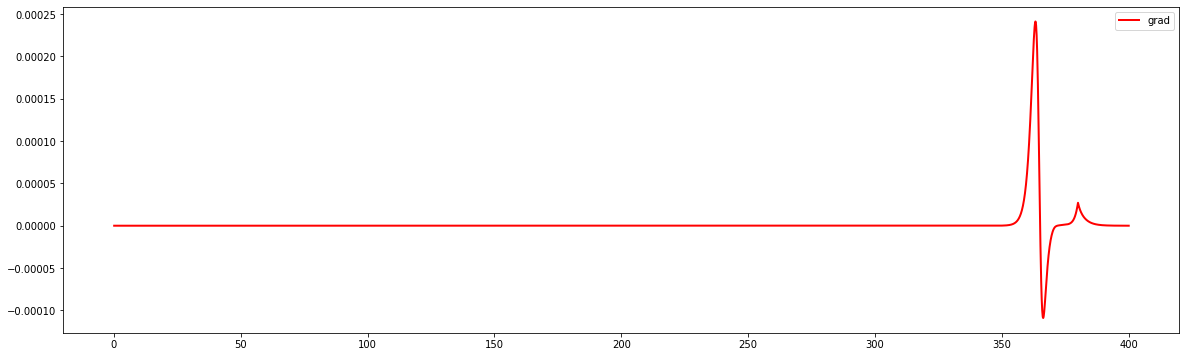

___
iteration: 4400


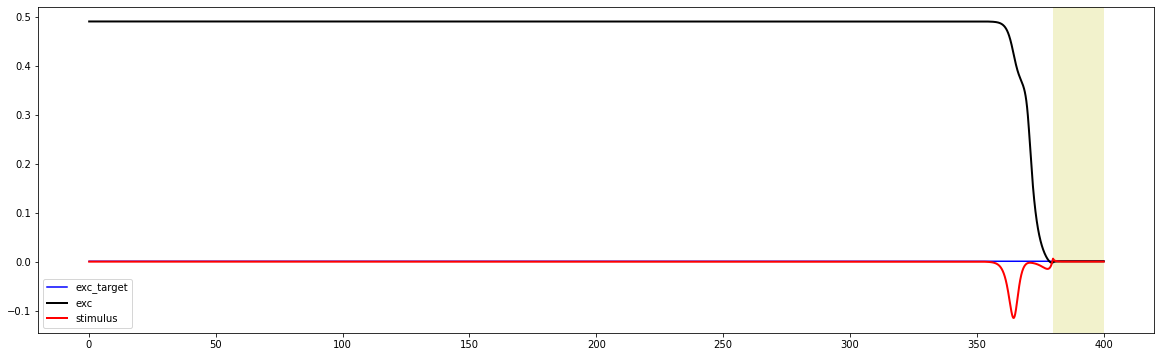

gradient:


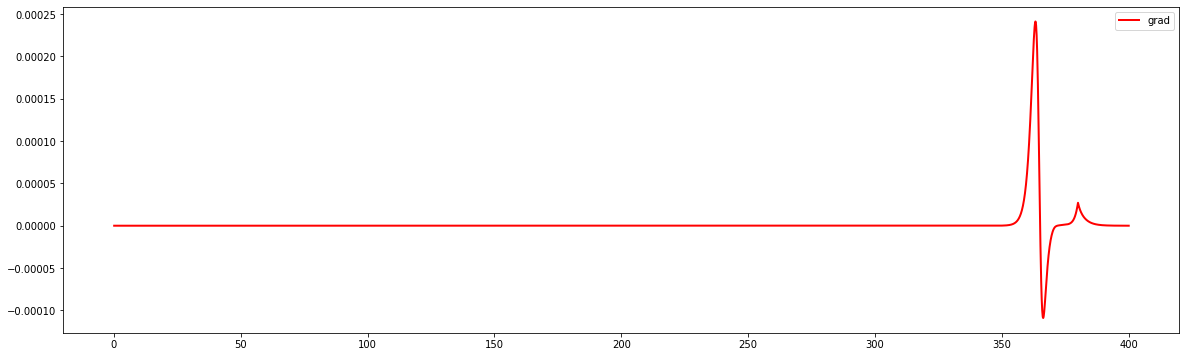

___
iteration: 4600


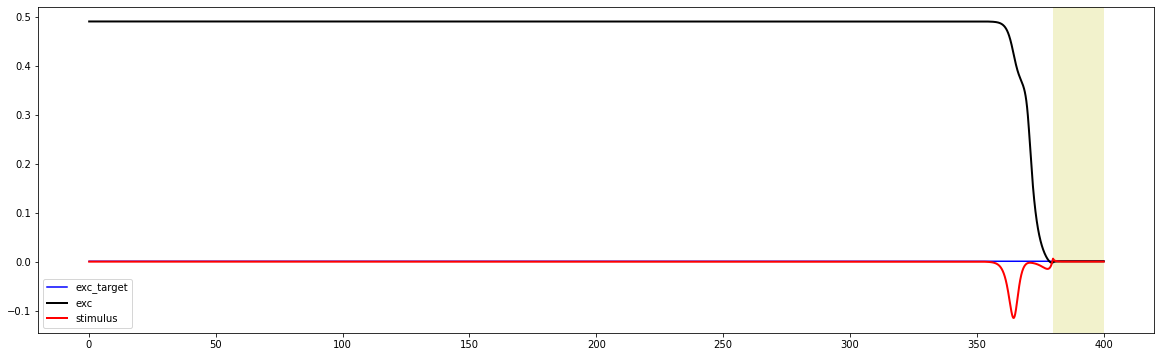

gradient:


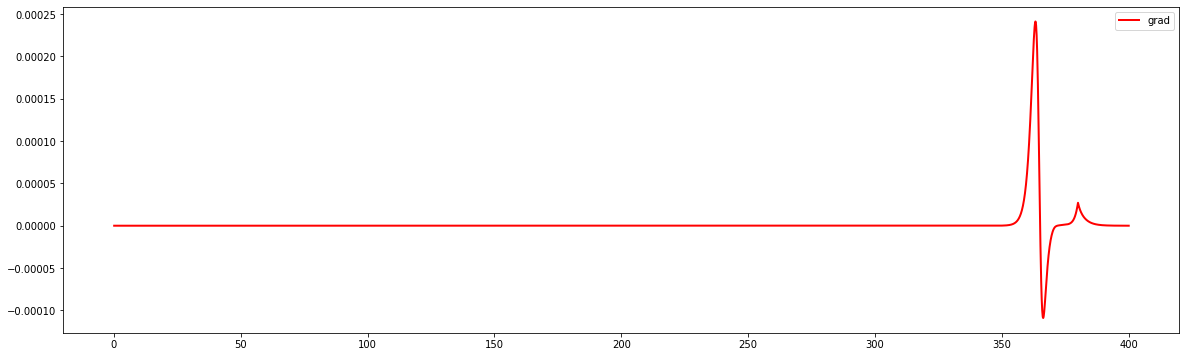

___
iteration: 4800


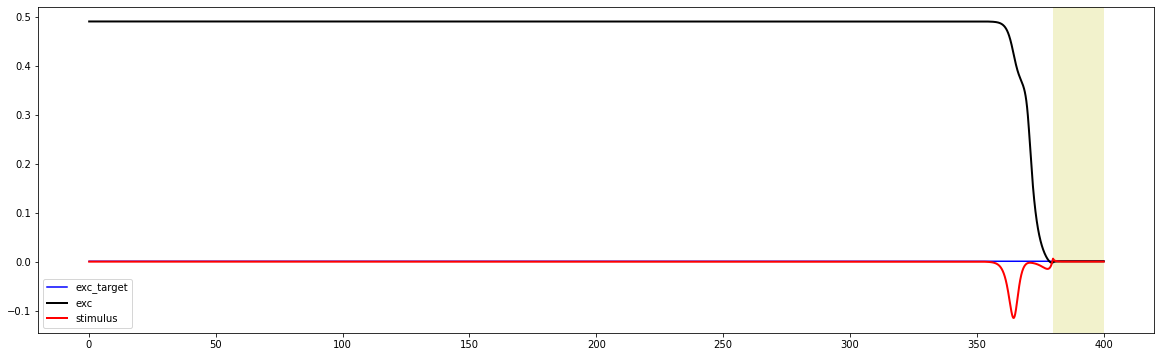

gradient:


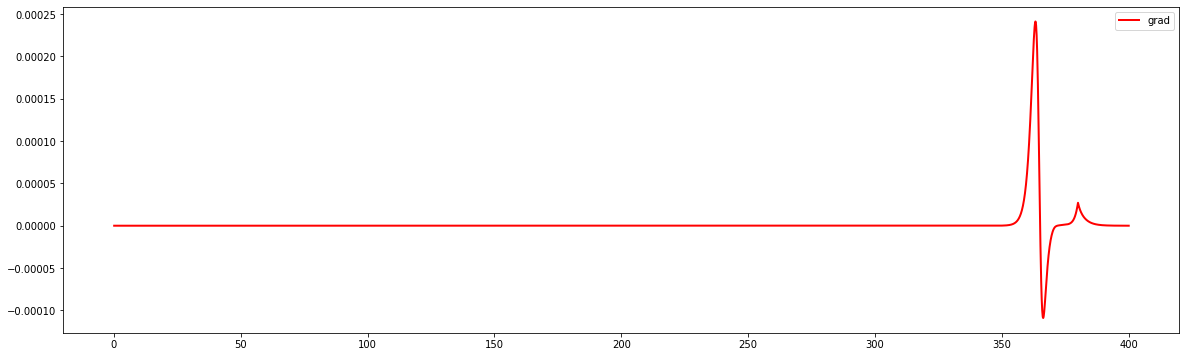

___
iteration: 5000


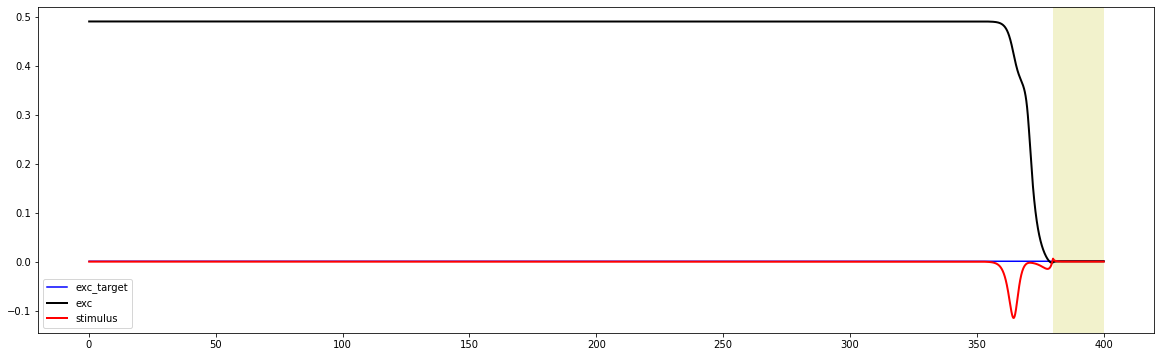

gradient:


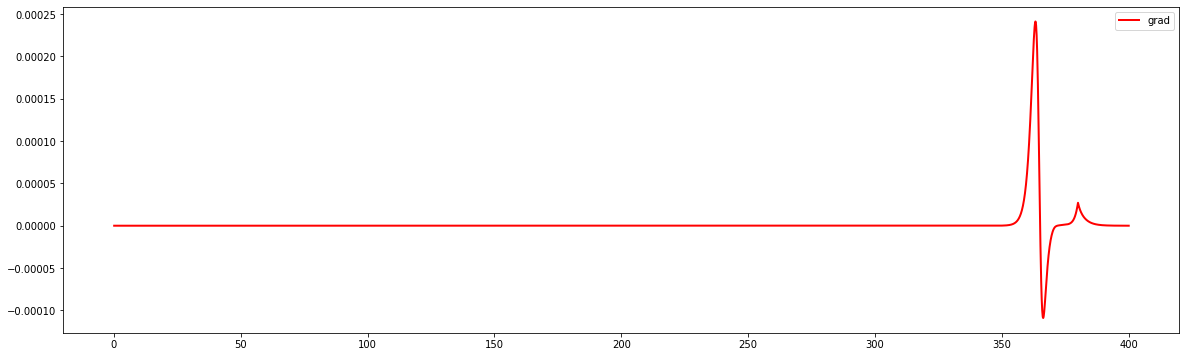

___
iteration: 5200


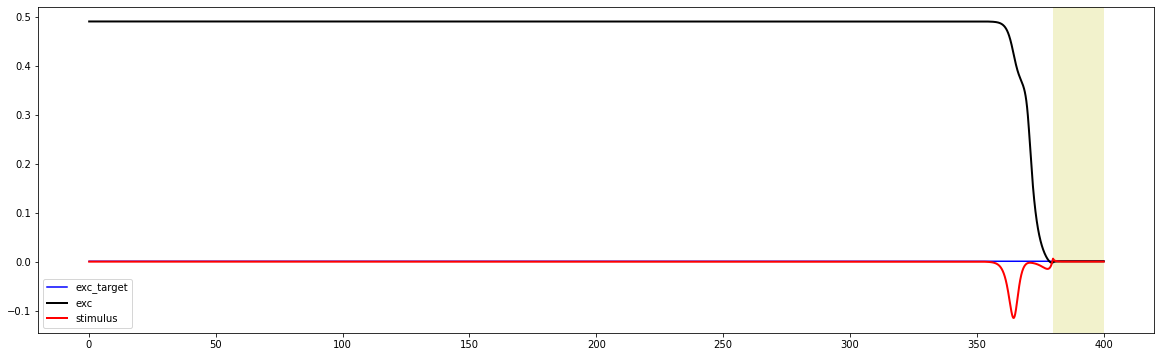

gradient:


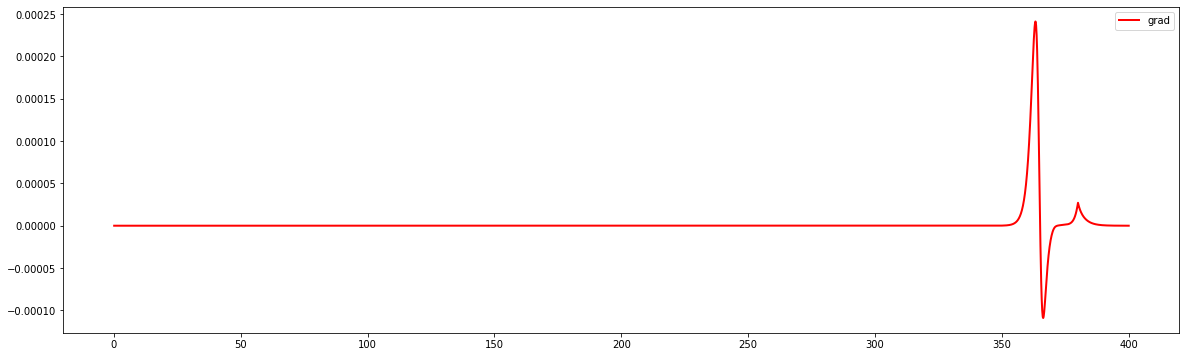

___
iteration: 5400


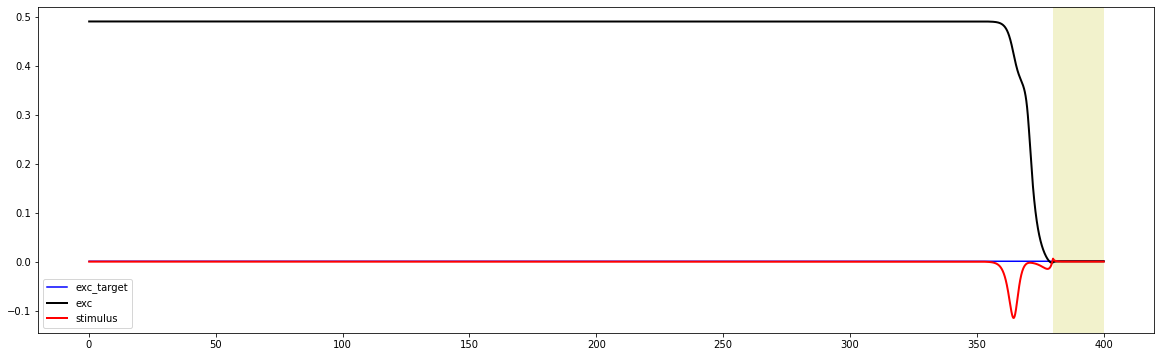

gradient:


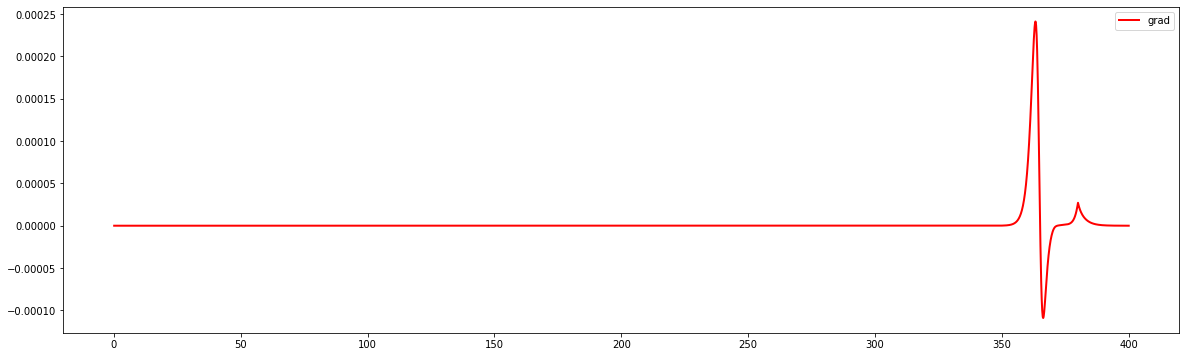

___
iteration: 5600


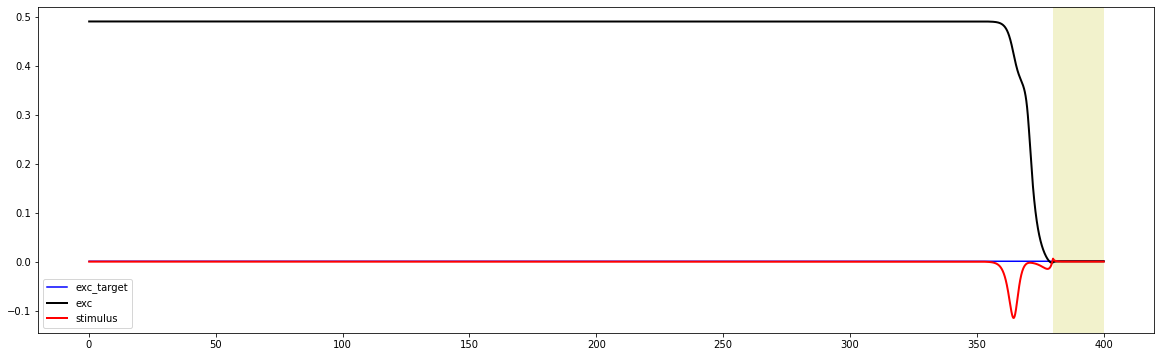

gradient:


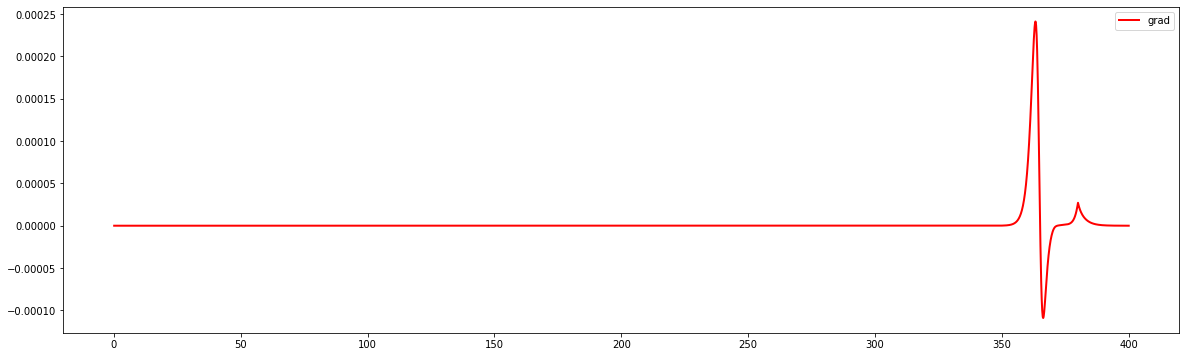

___
iteration: 5800


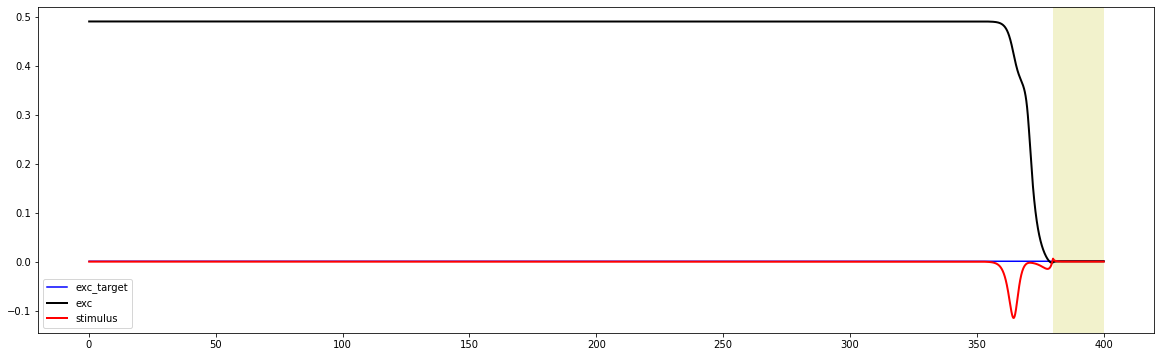

gradient:


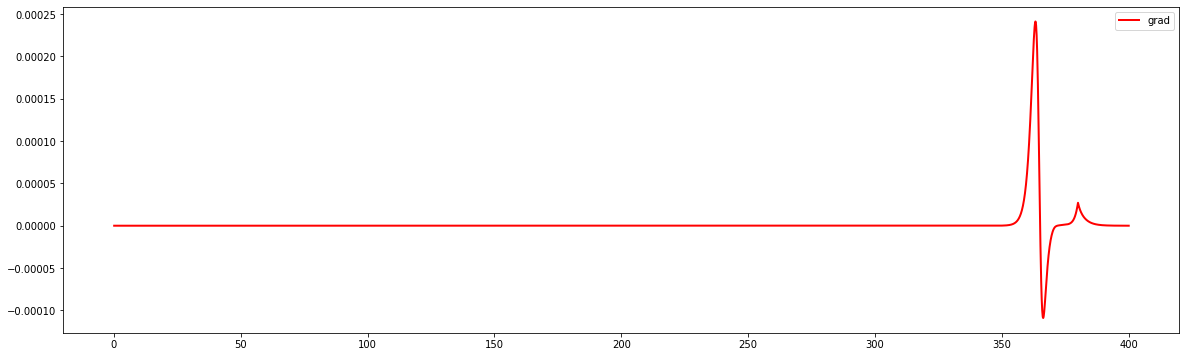

In [455]:
wc = WCModel()




#wc.params["c_inhinh"] = 0
#wc.params["c_excinh"] = 0
#wc.params["c_inhexc"] = 0
#wc.params["c_excexc"] = 0
#wc.params["tau_exc"] = 1  
#wc.params["tau_inh"] = 1
wc.params['exc_ext'] = 3.33
wc.params['inh_ext'] = 5#3.89
#wc.params["K_gl"] = 0
#wc.params["dt"] = 0.1

#wc.params["a_exc"] = 1
#wc.params["a_inh"] = 1



wc.params["exc_init"] = [[0.490690]]
wc.params["inh_init"] =[[0.499998]]

#wc.params["exc_init"] = [[0.45446237]]
#wc.params["inh_init"] = [[0.49949741]]

stimulus = np.zeros((1,4000))

stimulus[0][500:600] = 0
#plt.plot(stimulus.T)


#wc.params['exc_ext'] = 3.33
#wc.params['inh_ext'] = 3.89

wc.params['duration'] = 400


optimal_control(wc, target_low,target_low_inh, stimulus, n_iter = 6000, plot_freq = 200, w = [0.01,0.01], a = 3800,debug = False)


#optimal_control(wc, stimulus, target, target)

___
iteration: 0


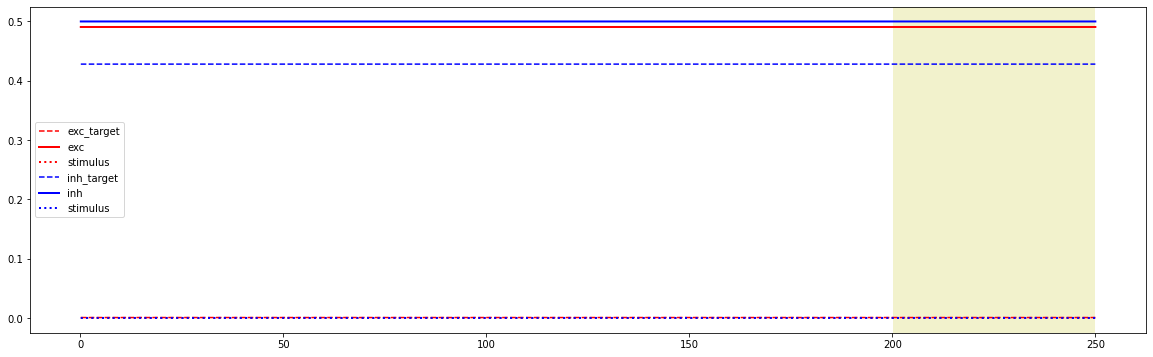

gradient:


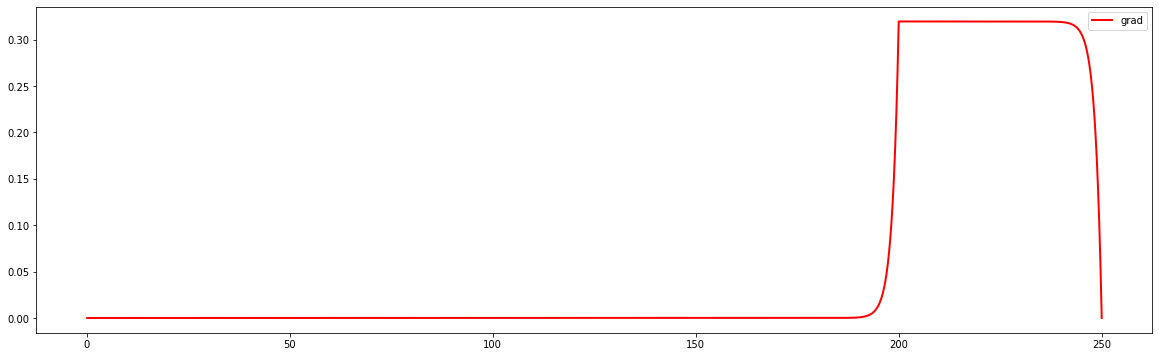

___
iteration: 100


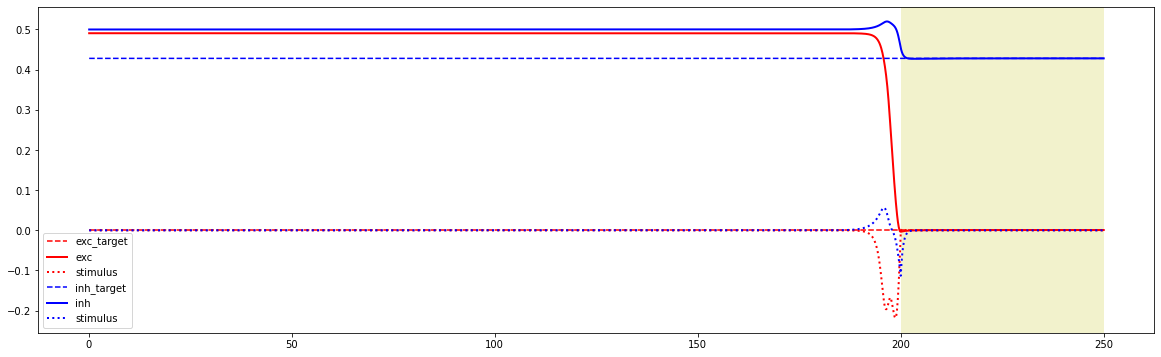

gradient:


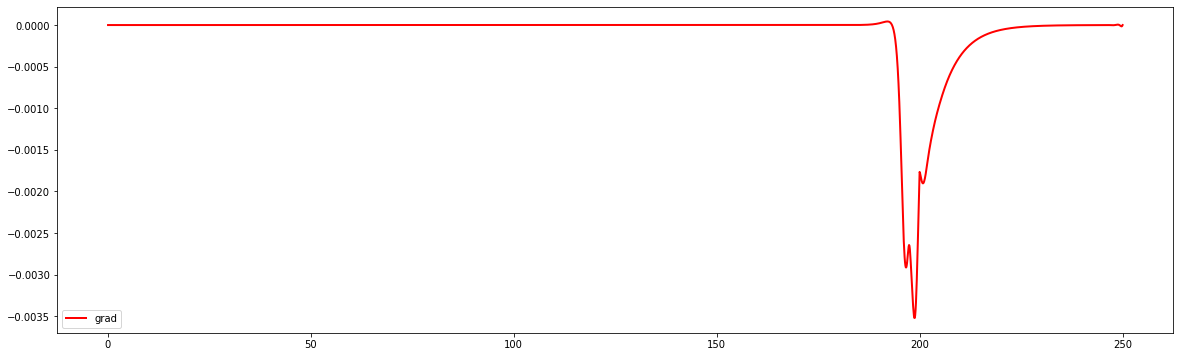

___
iteration: 200


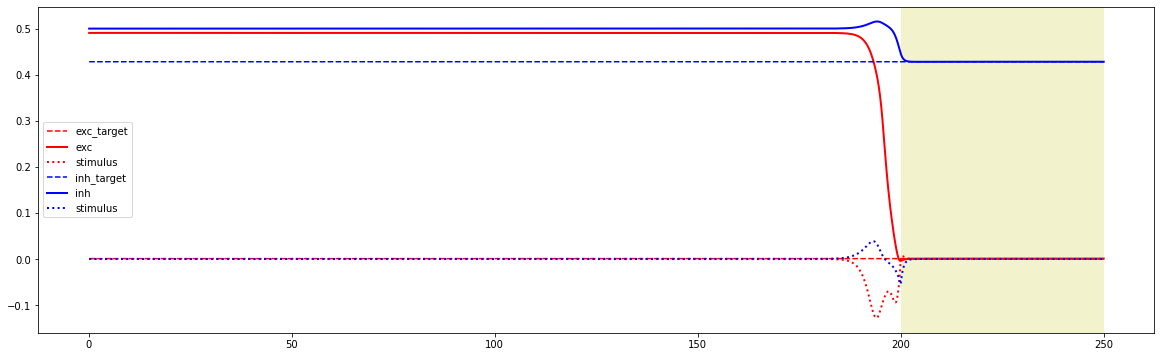

gradient:


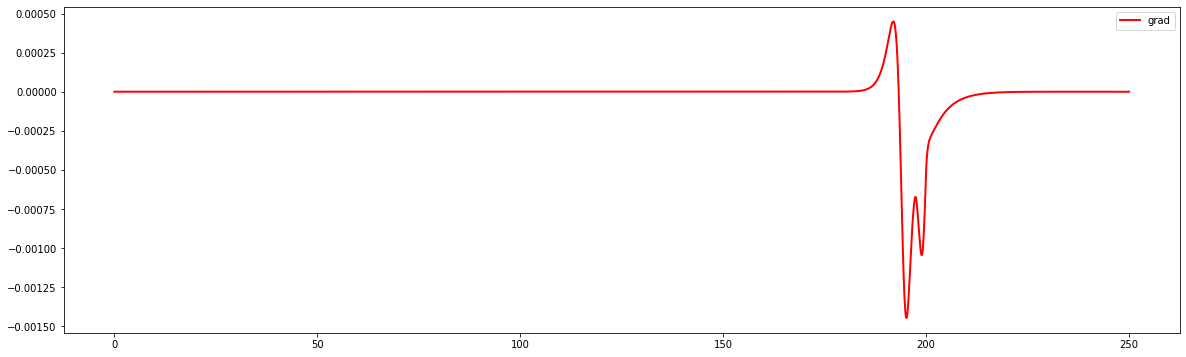

___
iteration: 300


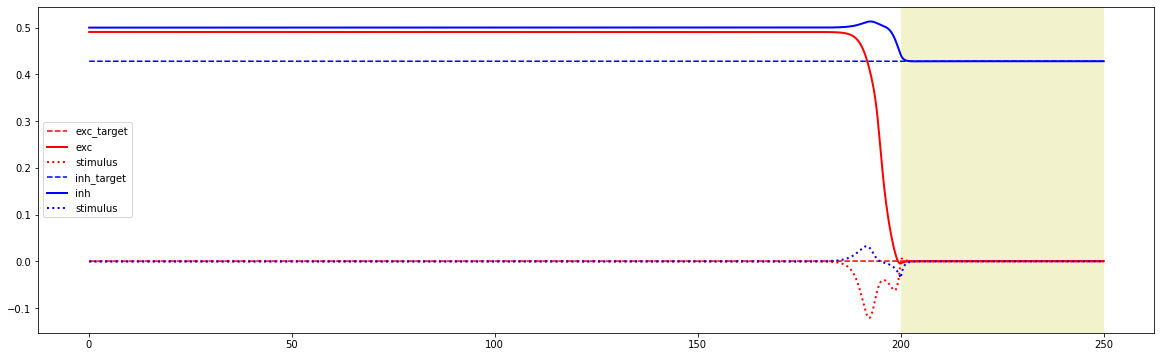

gradient:


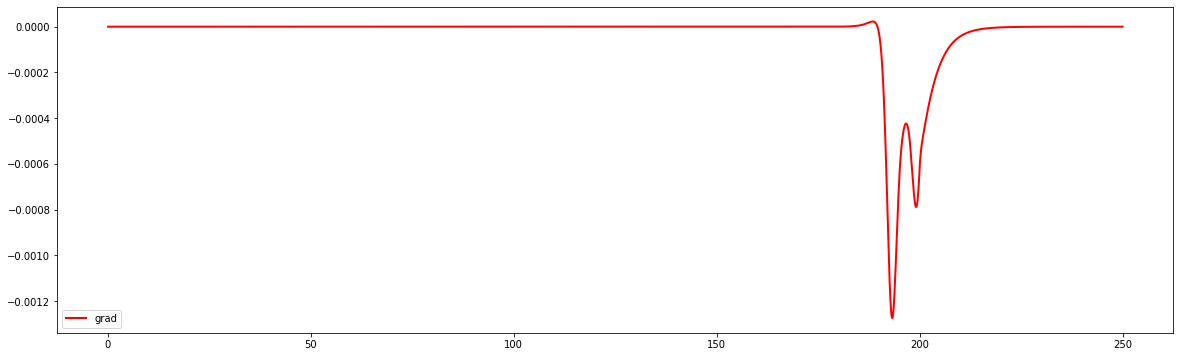

___
iteration: 400


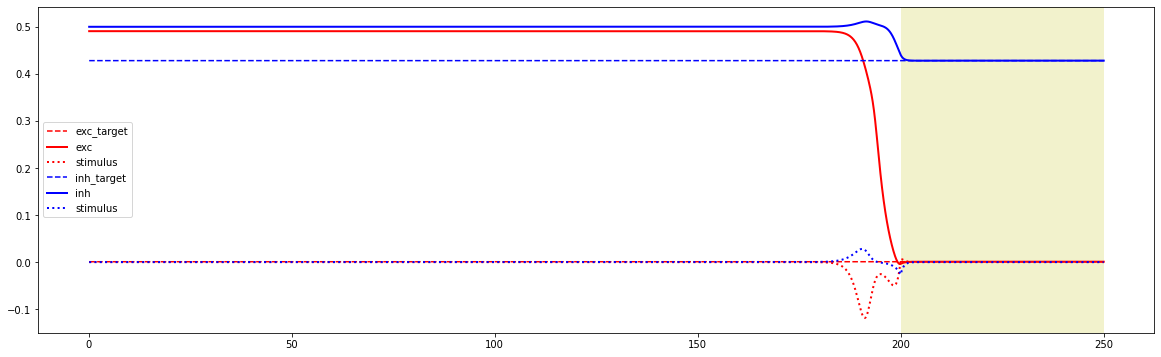

gradient:


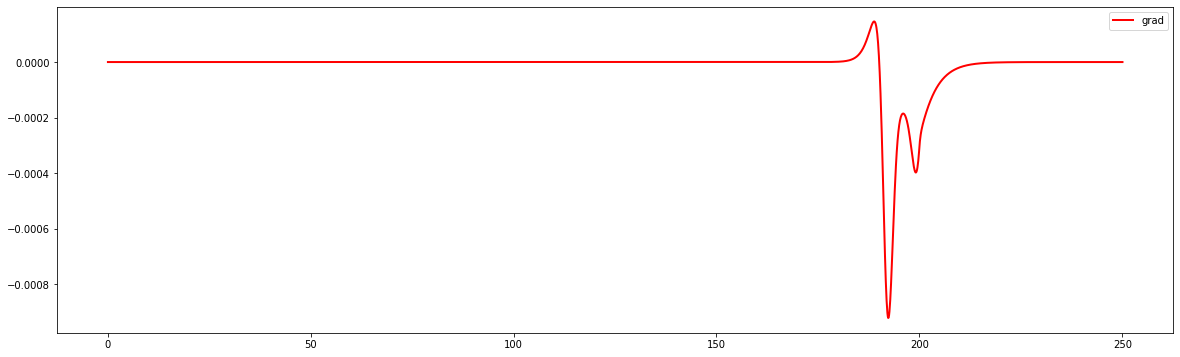

___
iteration: 500


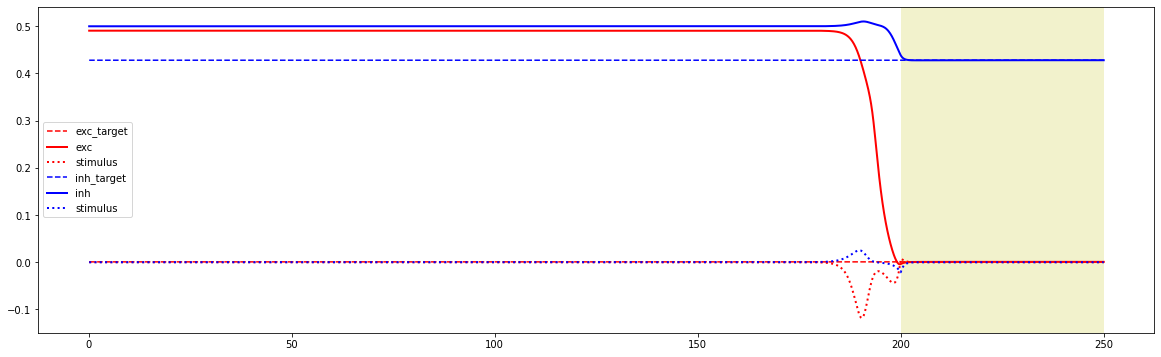

gradient:


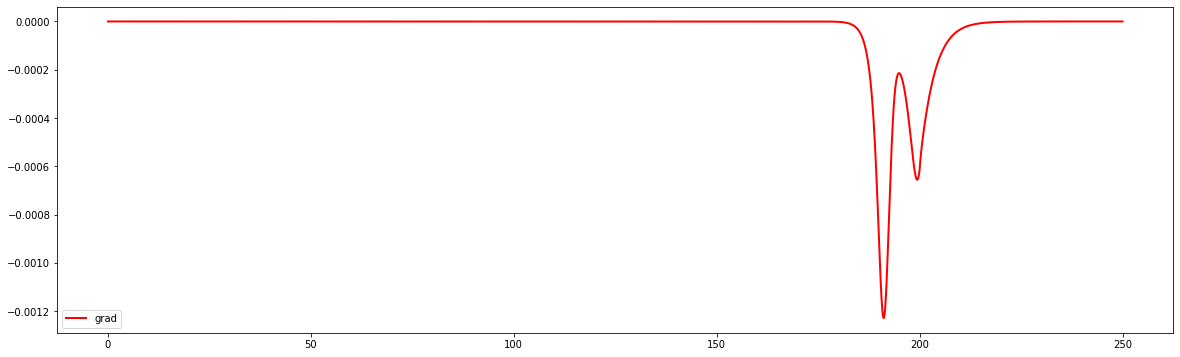

___
iteration: 600


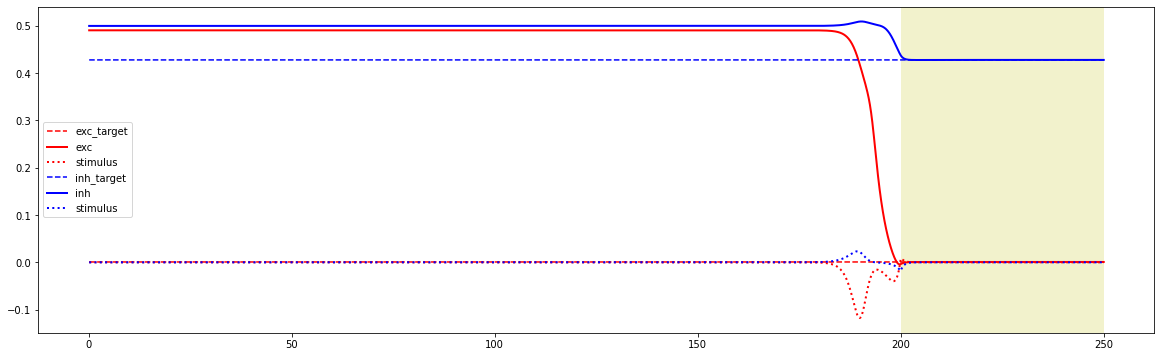

gradient:


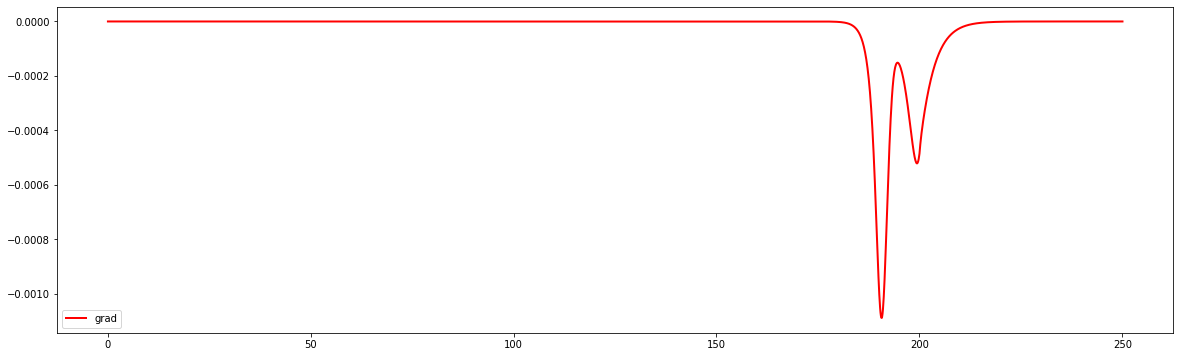

___
iteration: 700


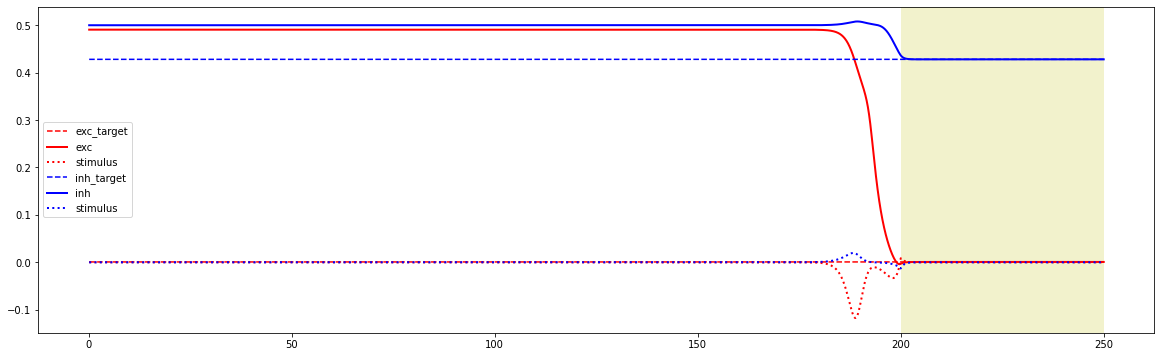

gradient:


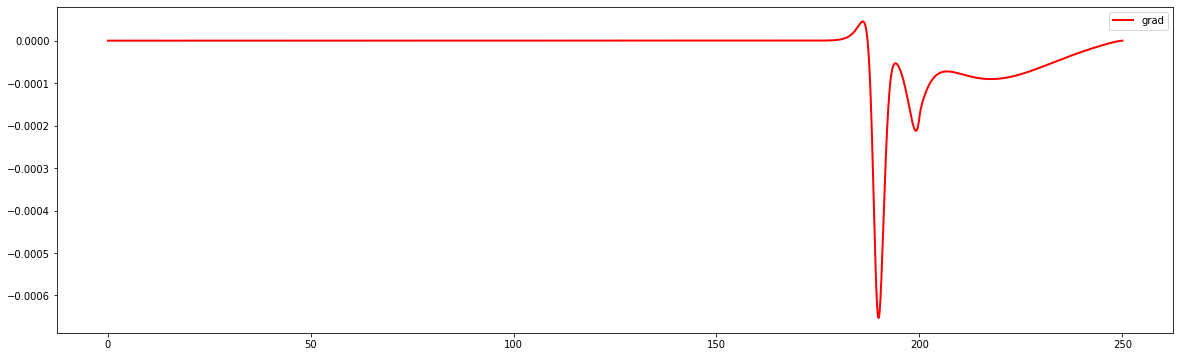

___
iteration: 800


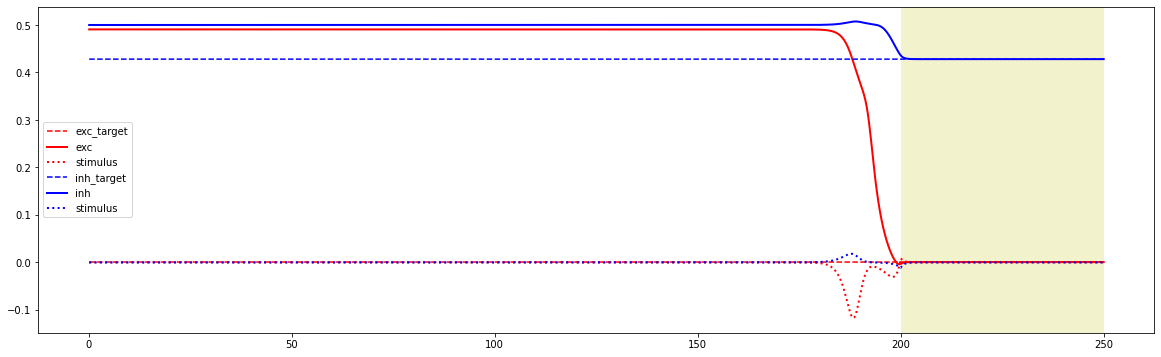

gradient:


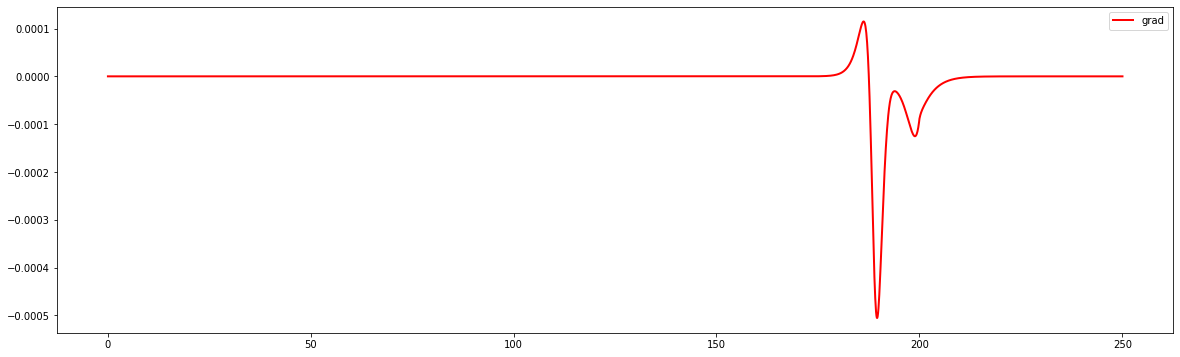

___
iteration: 900


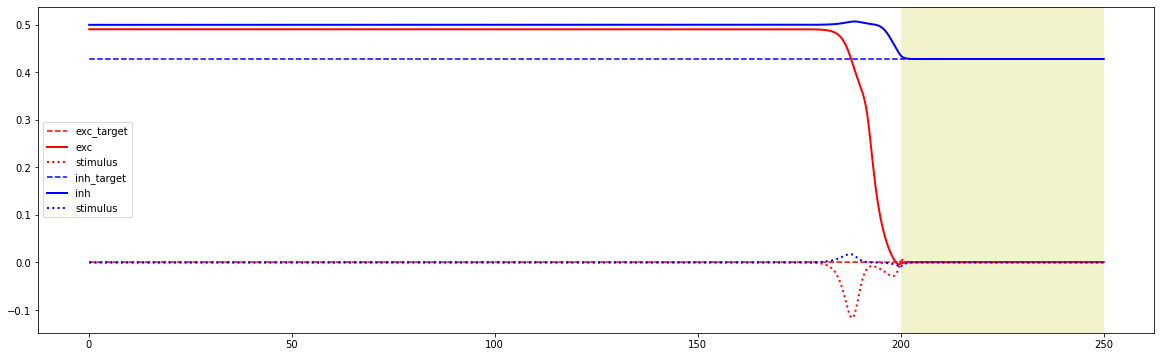

gradient:


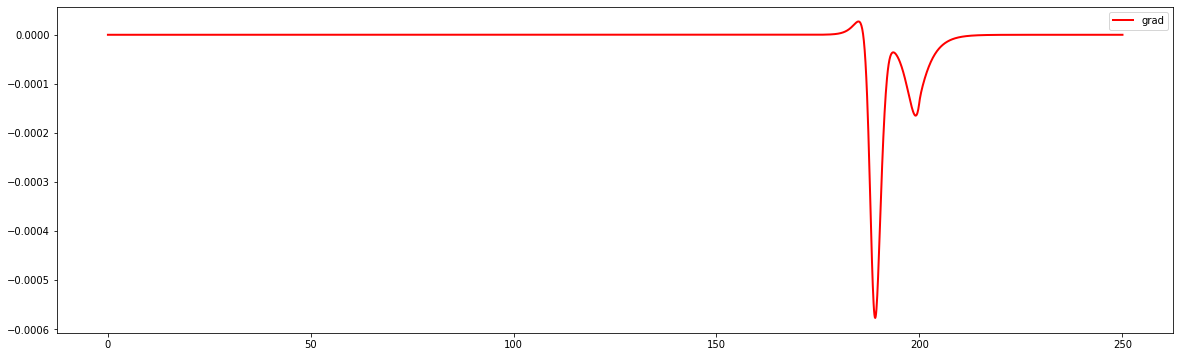

___
iteration: 1000


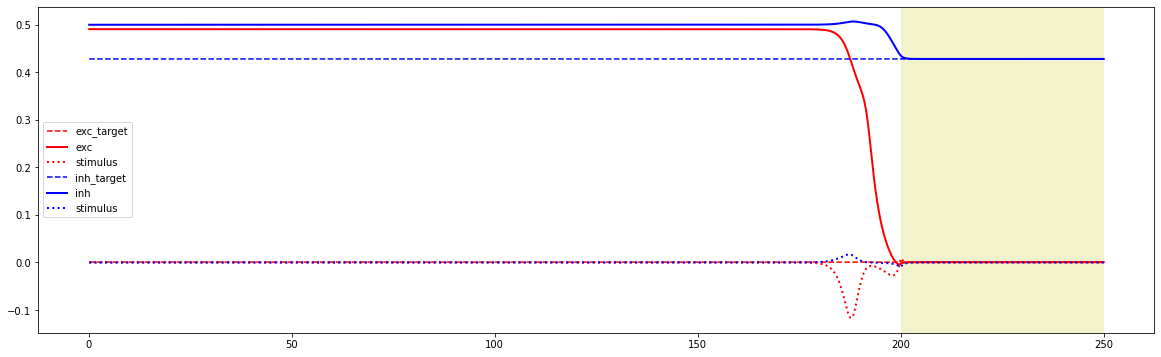

gradient:


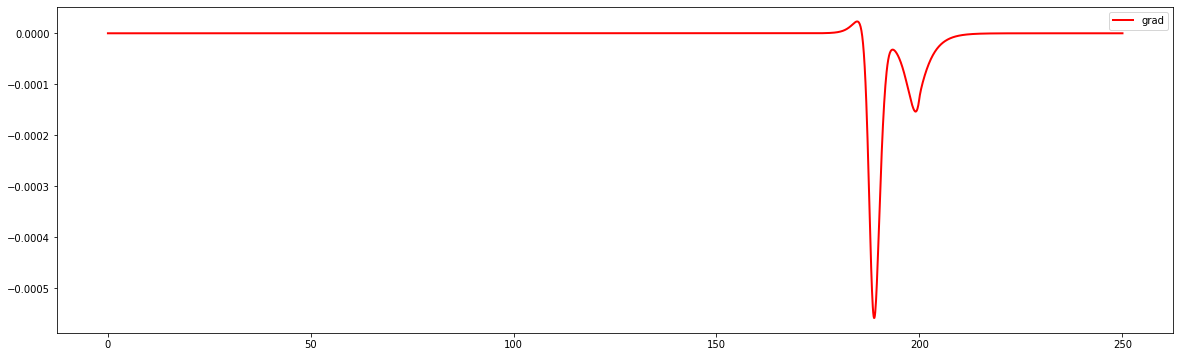

___
iteration: 1100


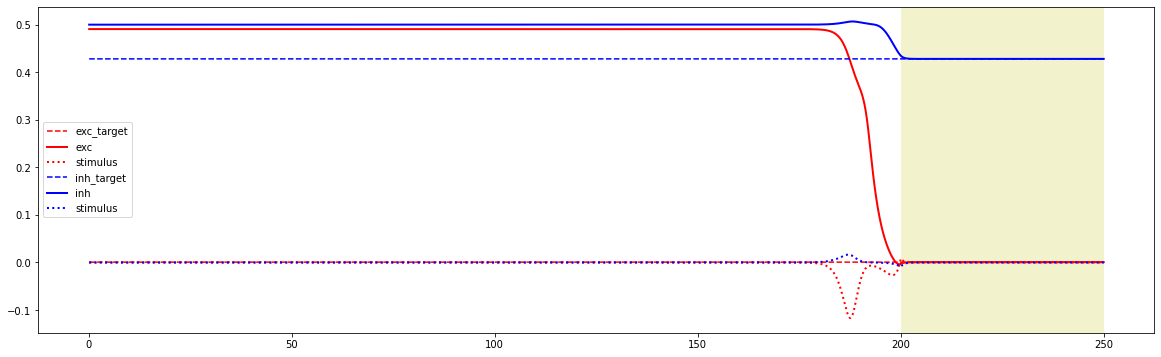

gradient:


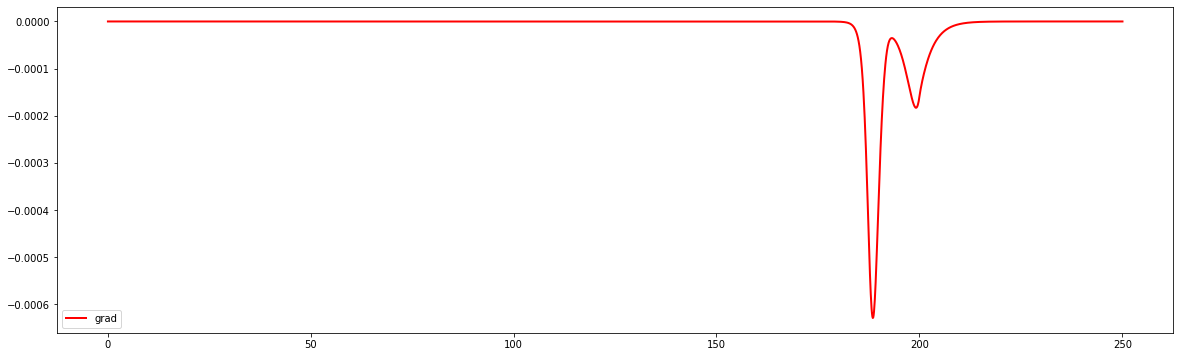

___
iteration: 1200


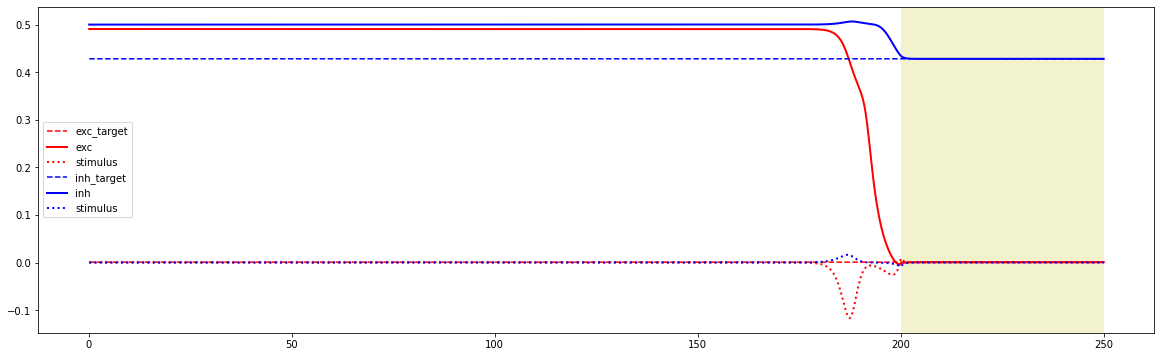

gradient:


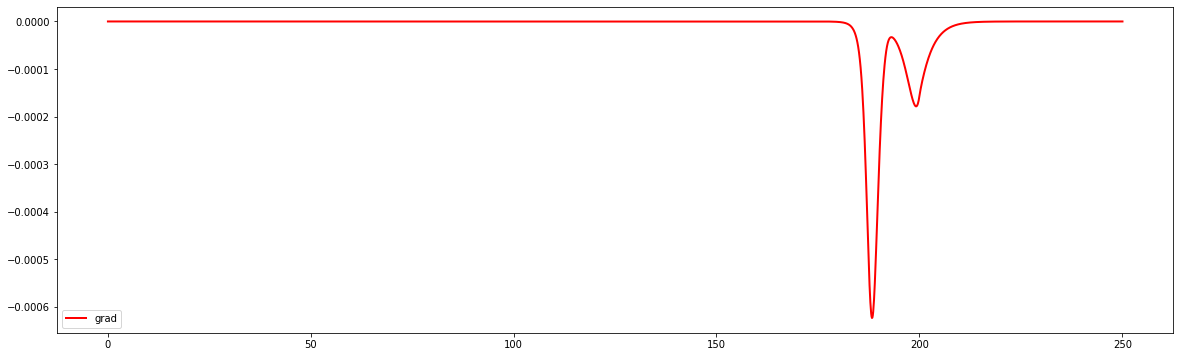

___
iteration: 1300


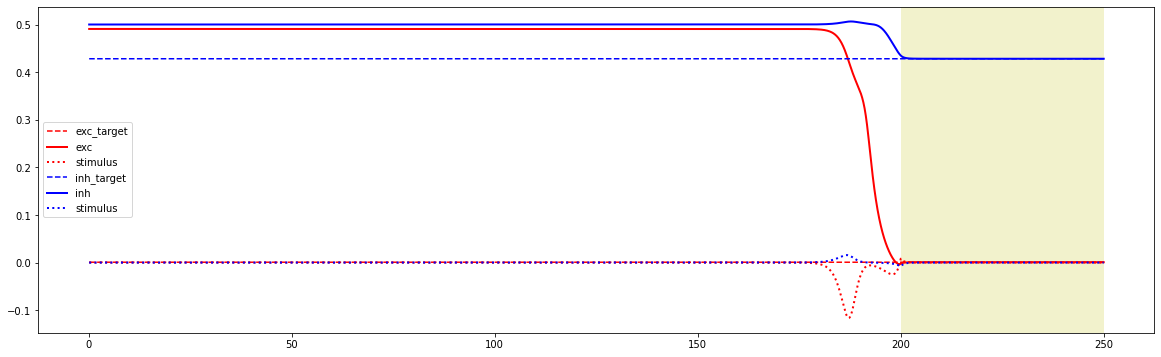

gradient:


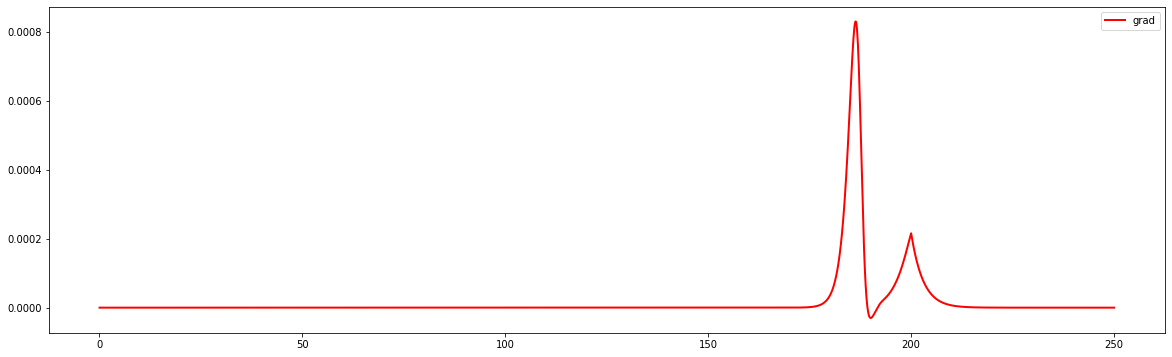

___
iteration: 1400


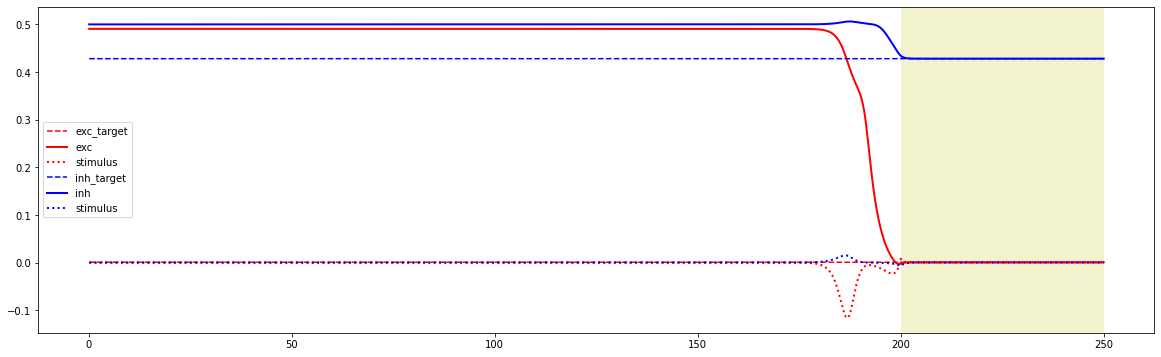

gradient:


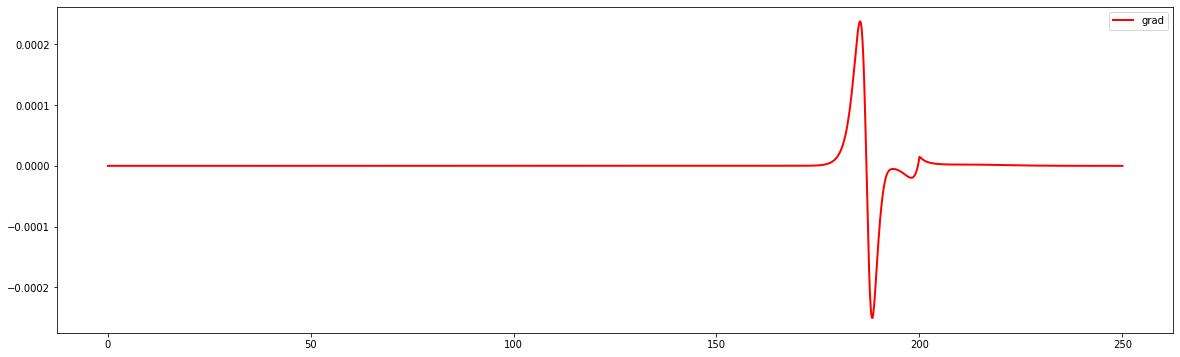

___
iteration: 1500


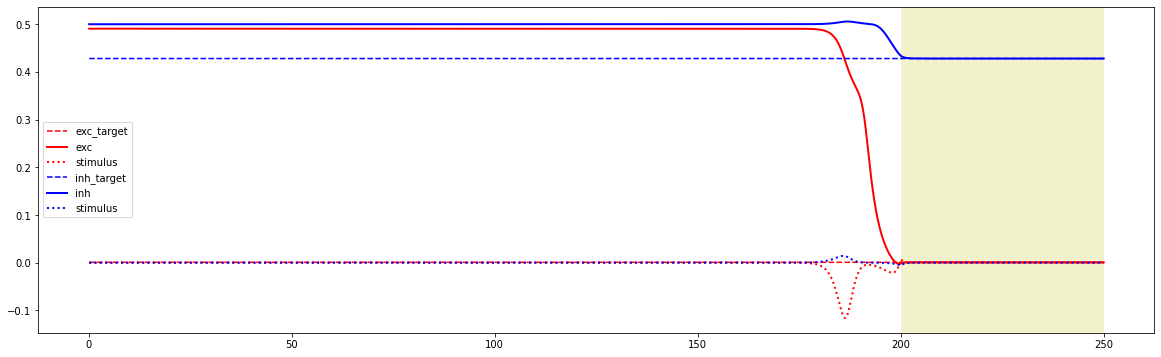

gradient:


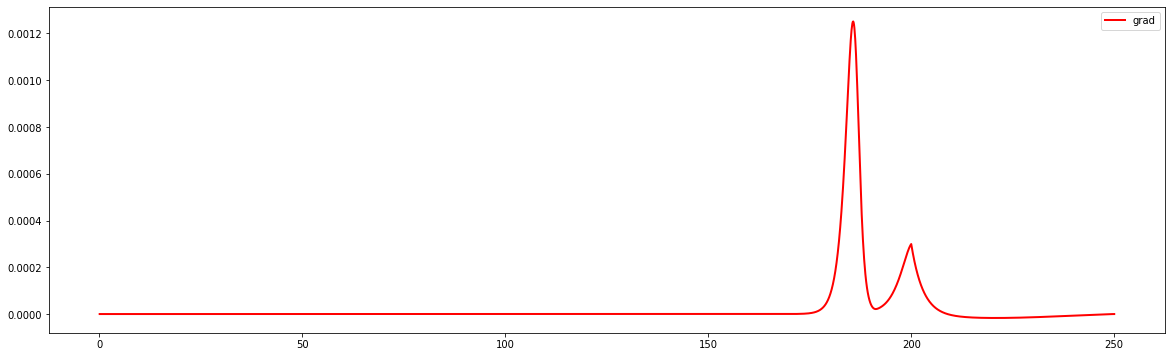

___
iteration: 1600


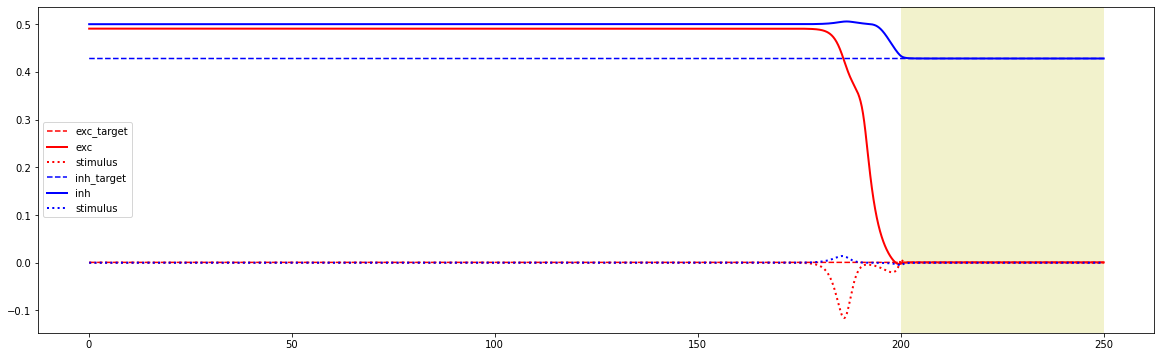

gradient:


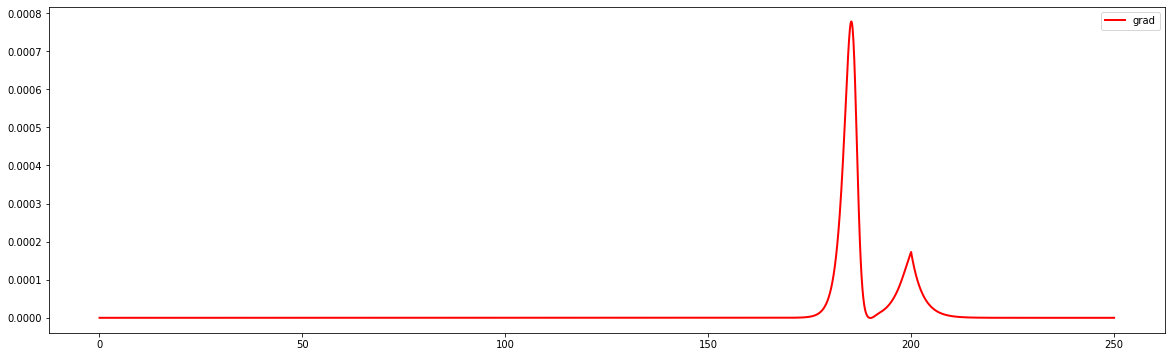

___
iteration: 1700


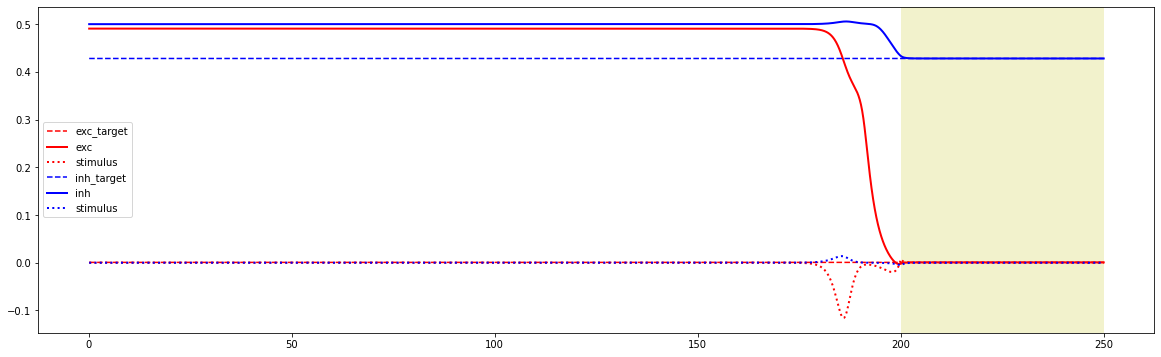

gradient:


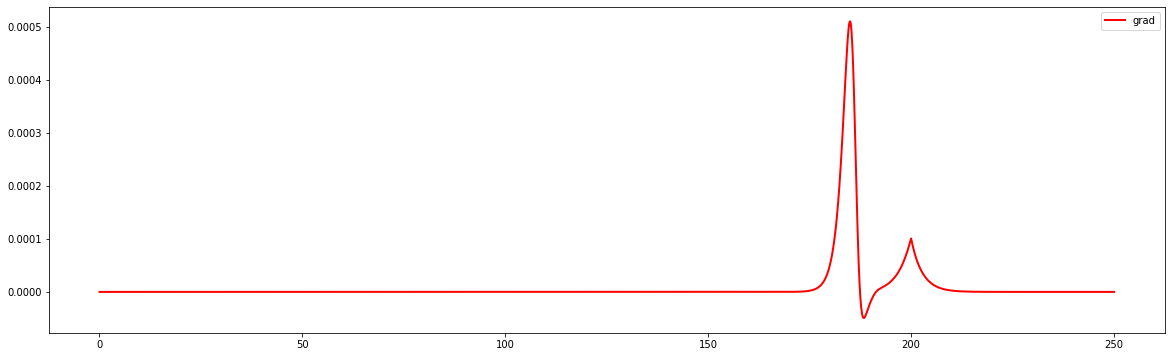

___
iteration: 1800


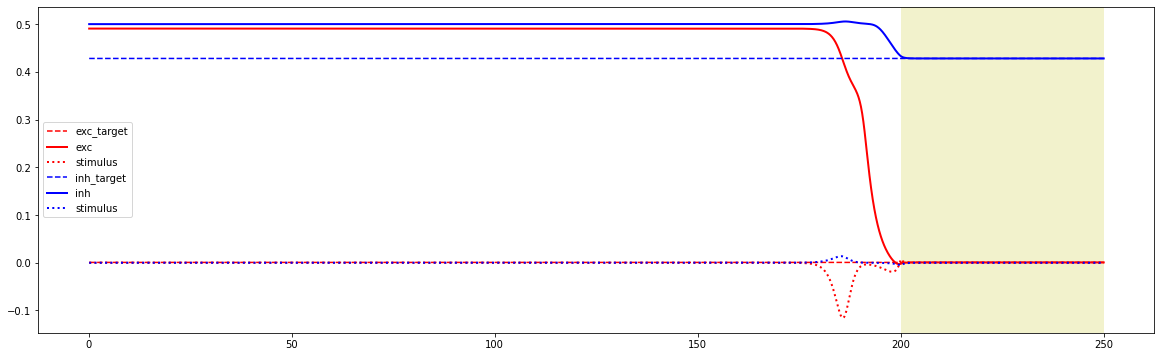

gradient:


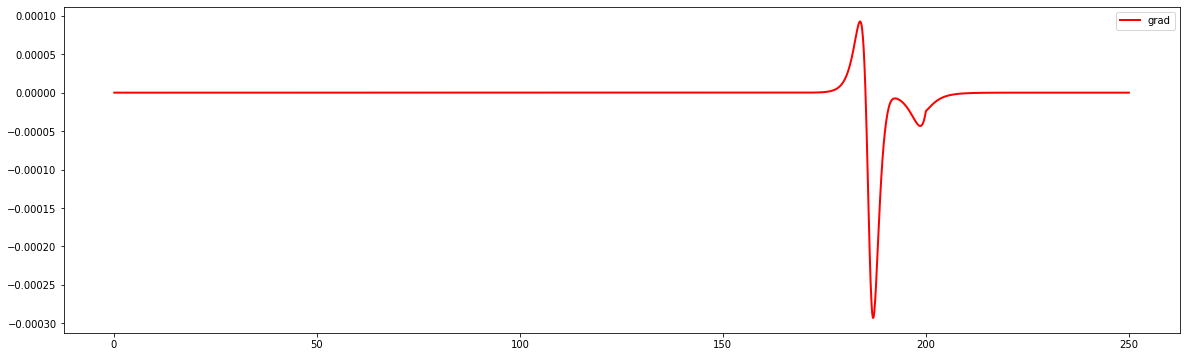

___
iteration: 1900


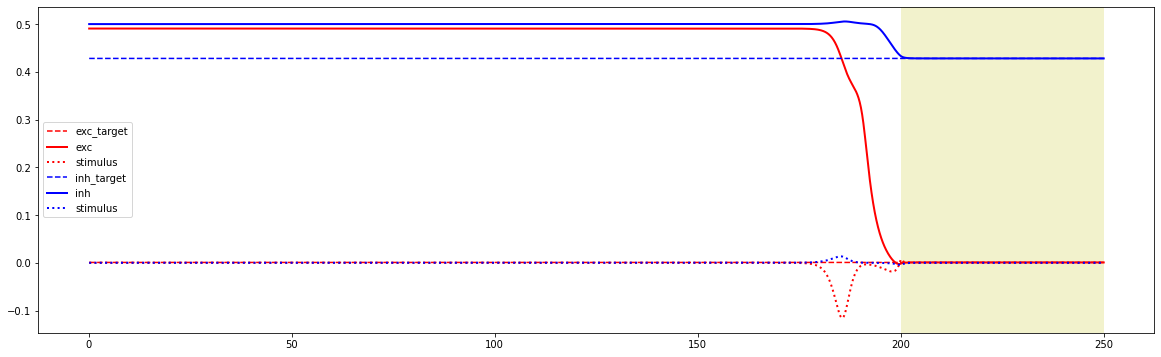

gradient:


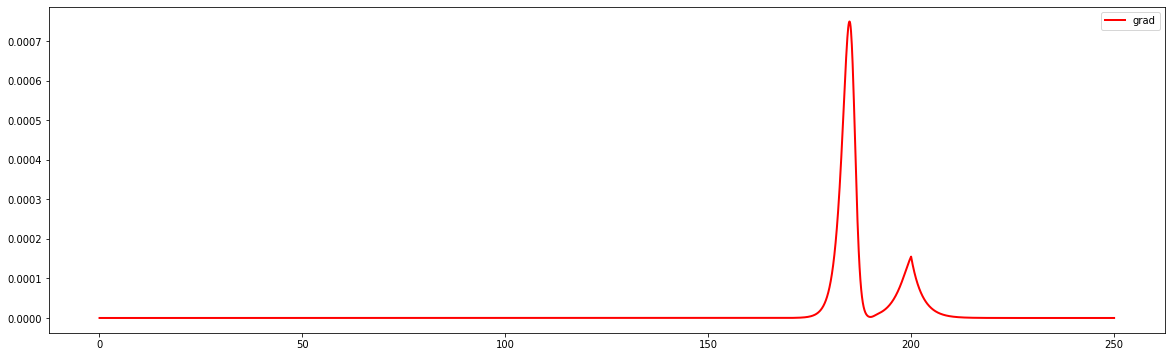

___
iteration: 2000


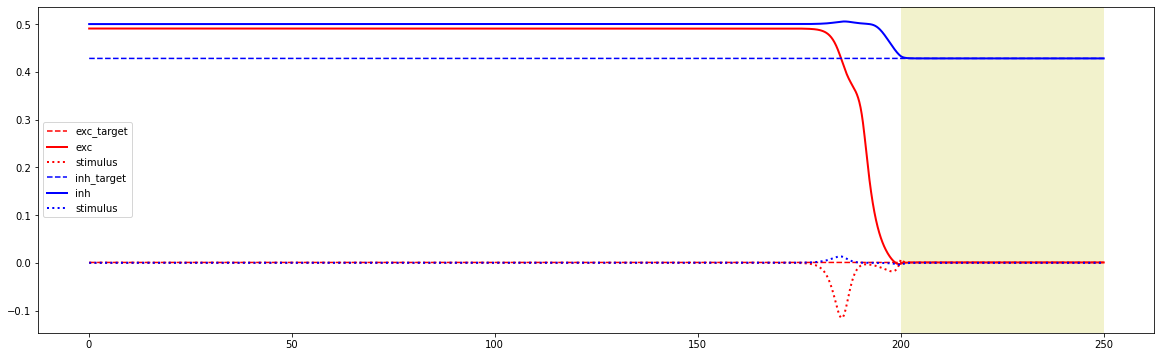

gradient:


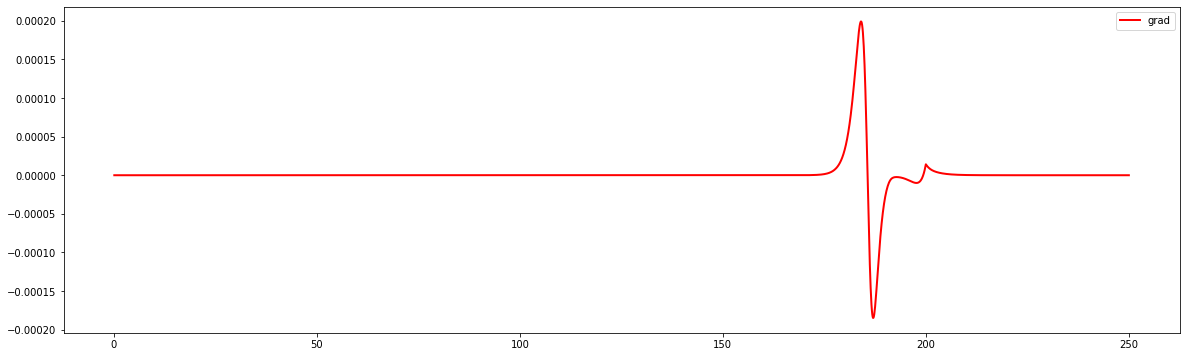

___
iteration: 2100


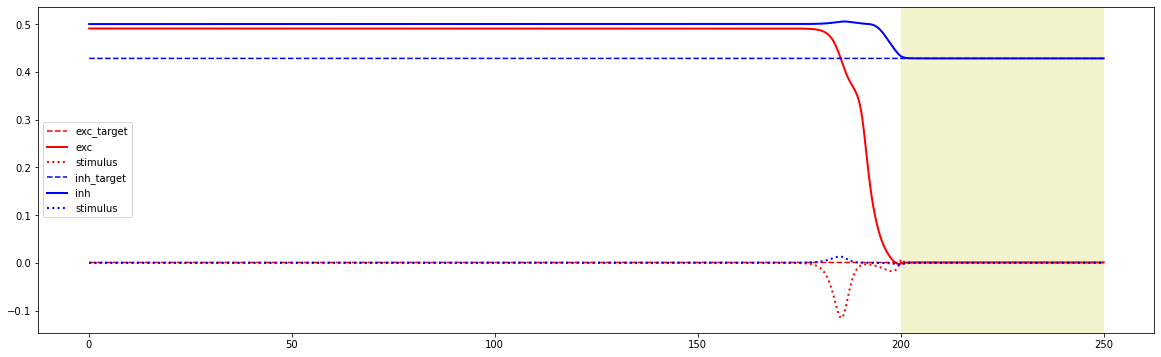

gradient:


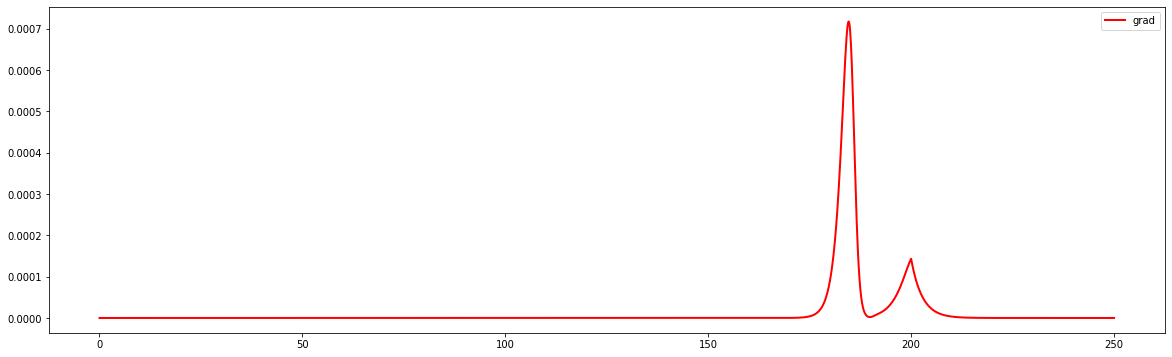

___
iteration: 2200


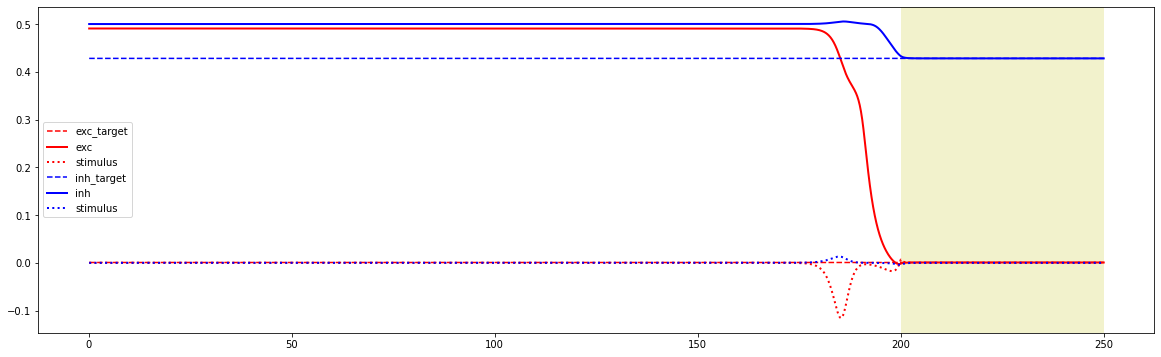

gradient:


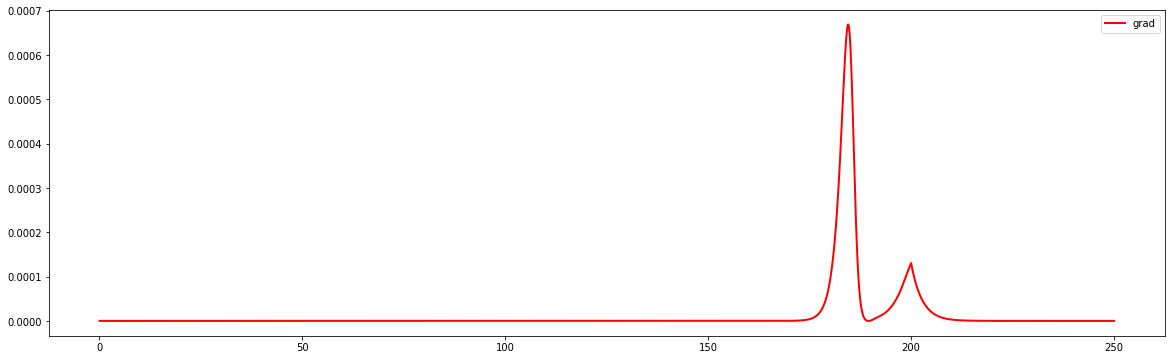

___
iteration: 2300


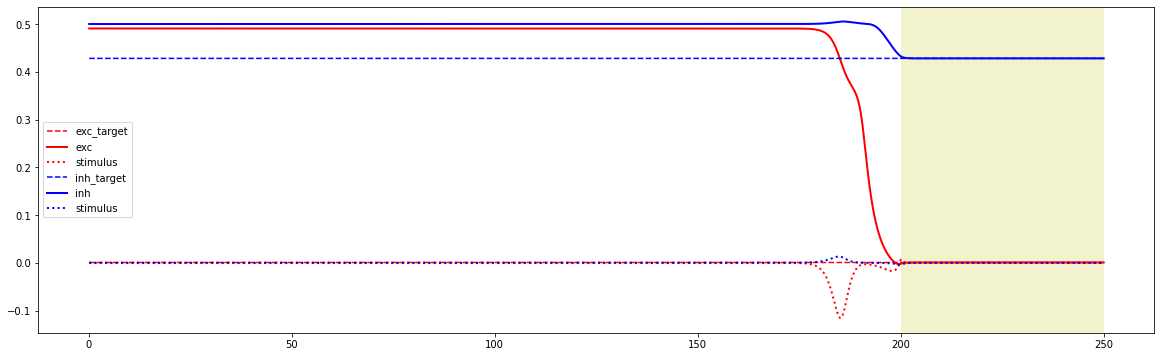

gradient:


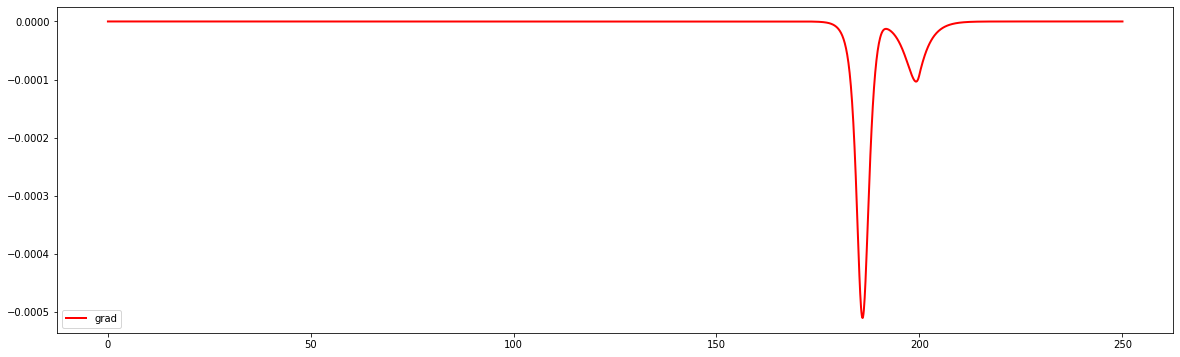

___
iteration: 2400


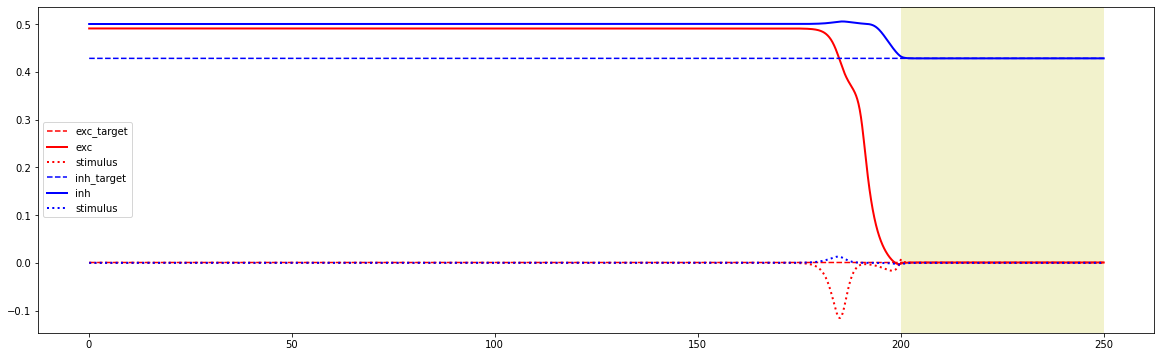

gradient:


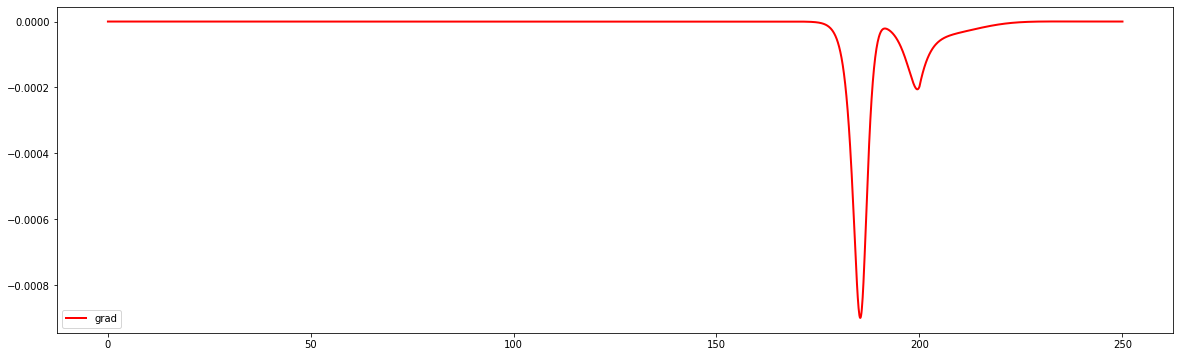

___
iteration: 2500


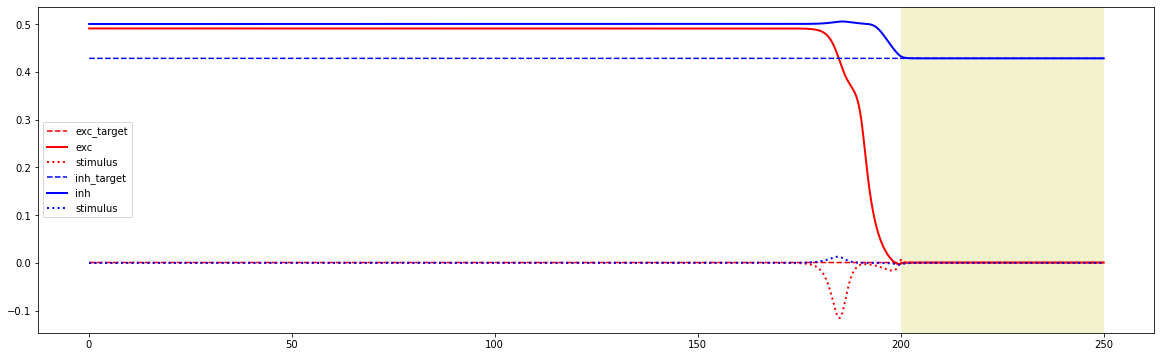

gradient:


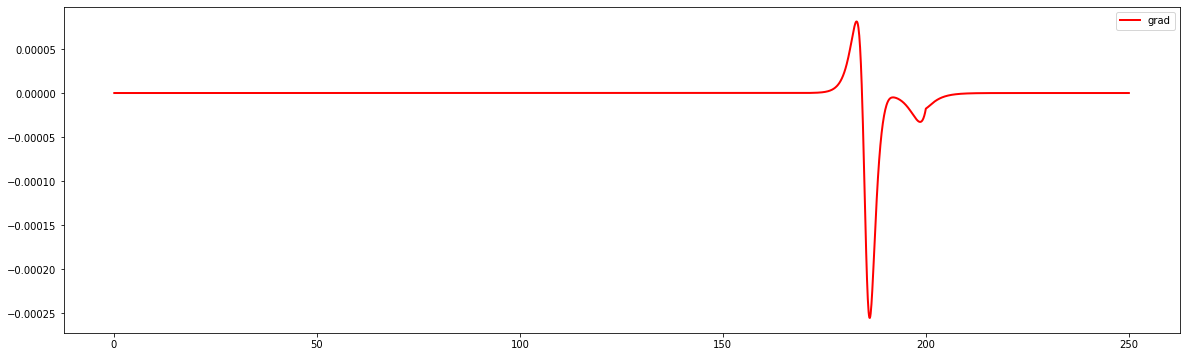

___
iteration: 2600


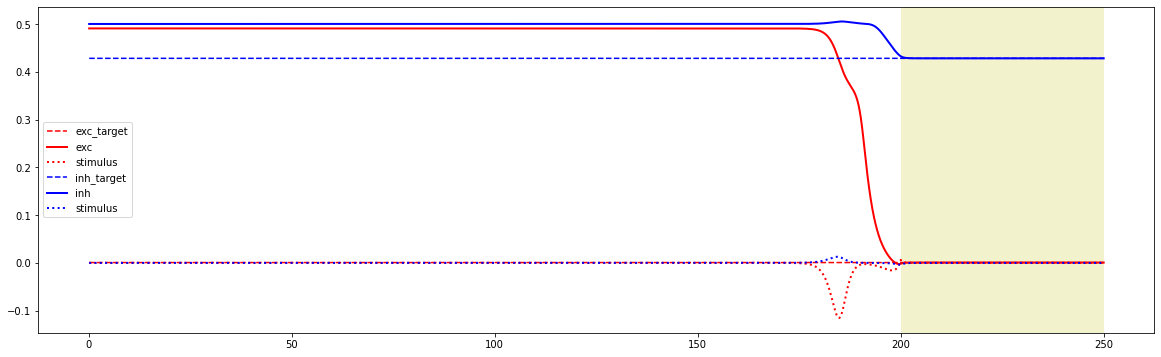

gradient:


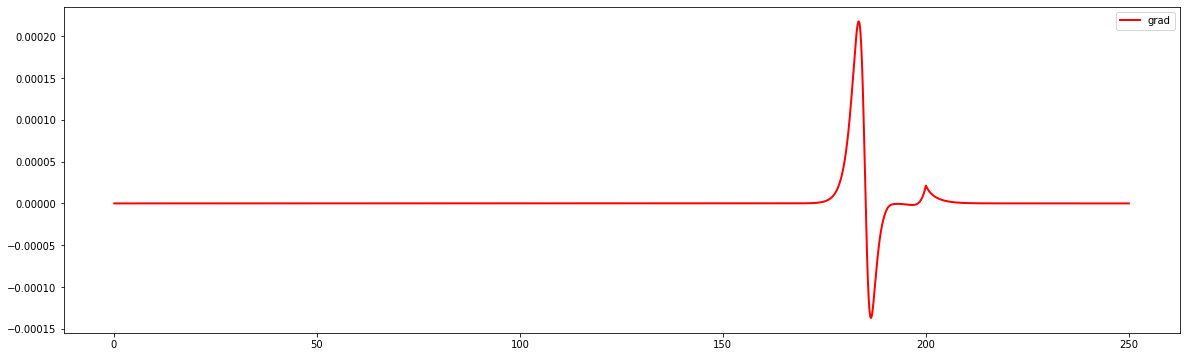

___
iteration: 2700


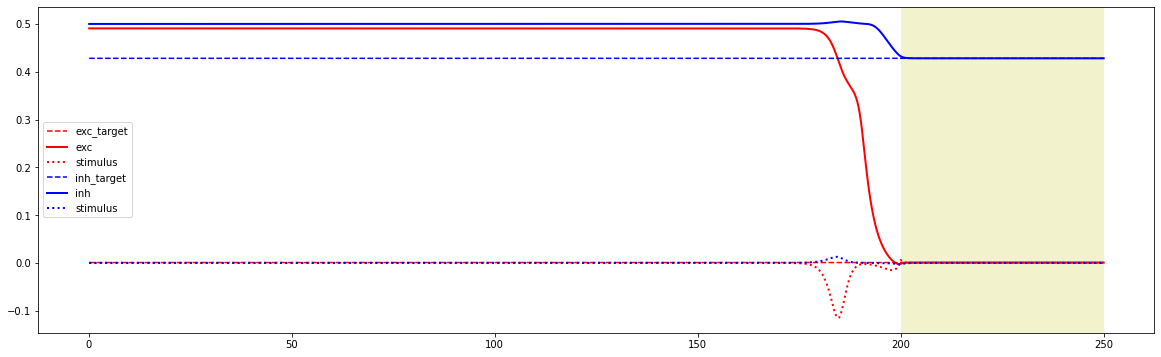

gradient:


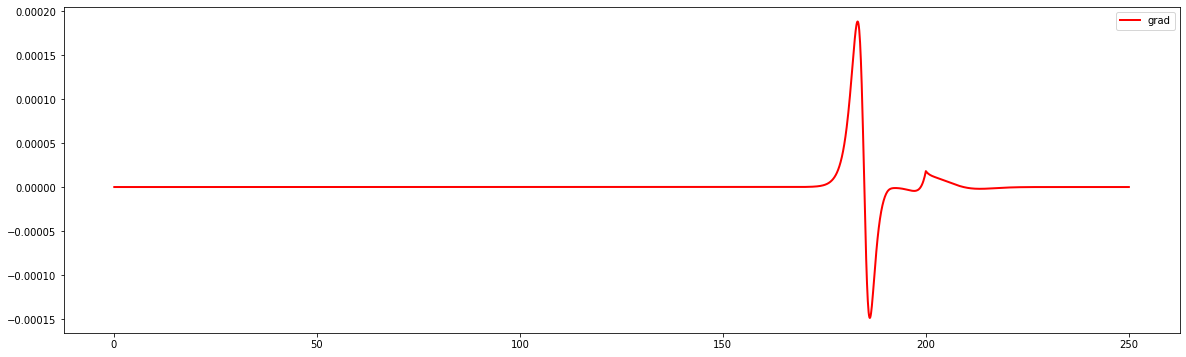

___
iteration: 2800


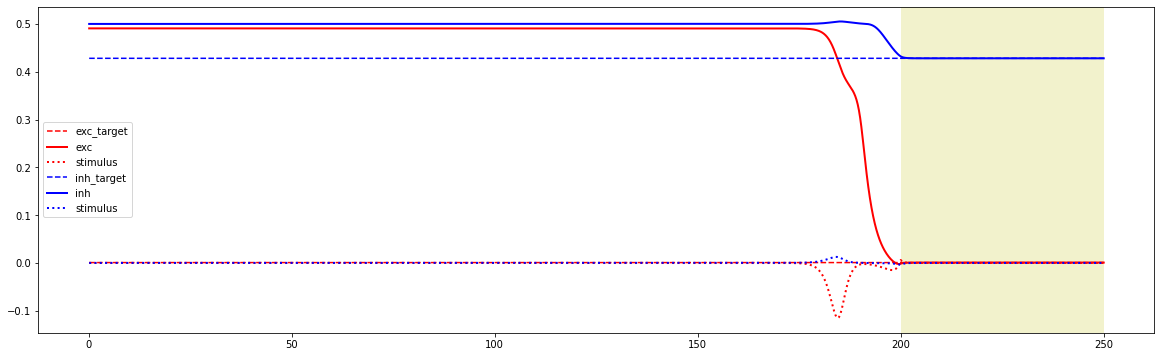

gradient:


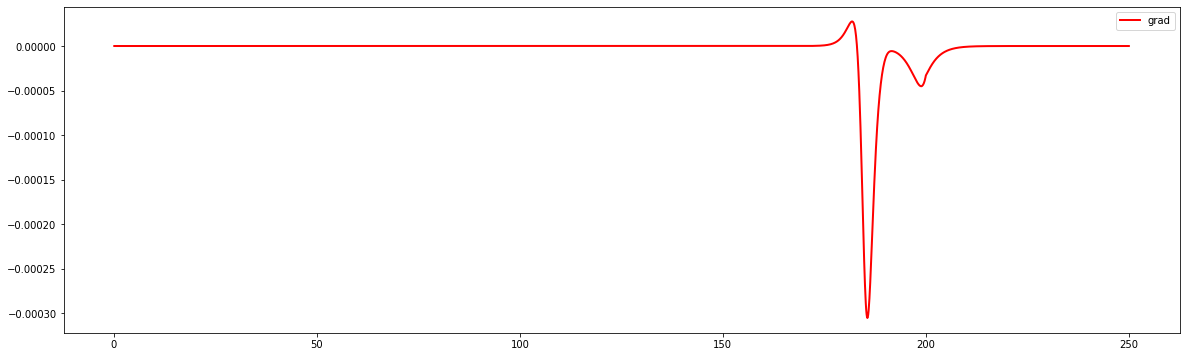

___
iteration: 2900


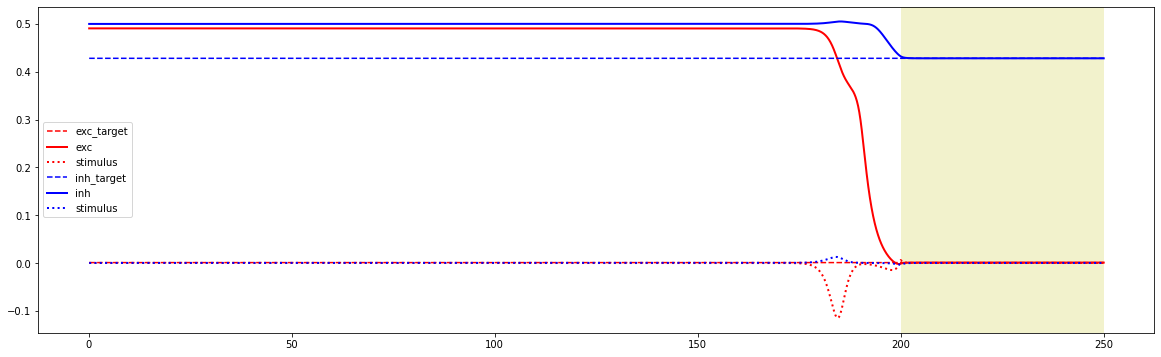

gradient:


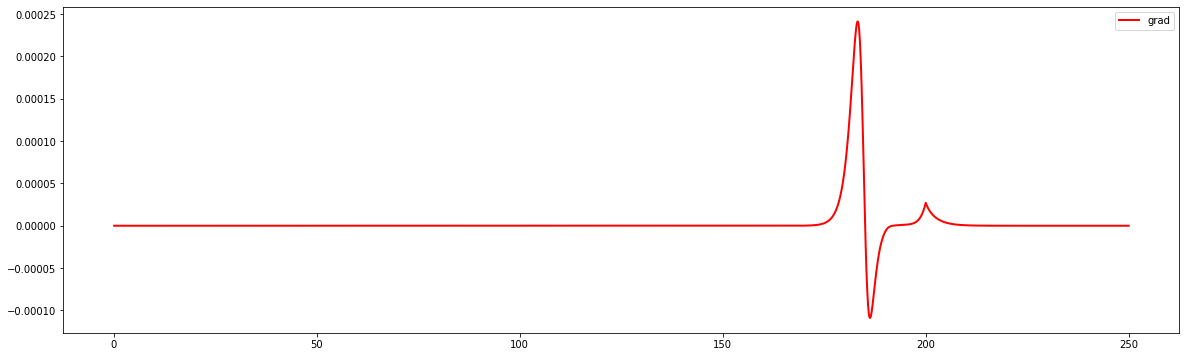

___
iteration: 3000


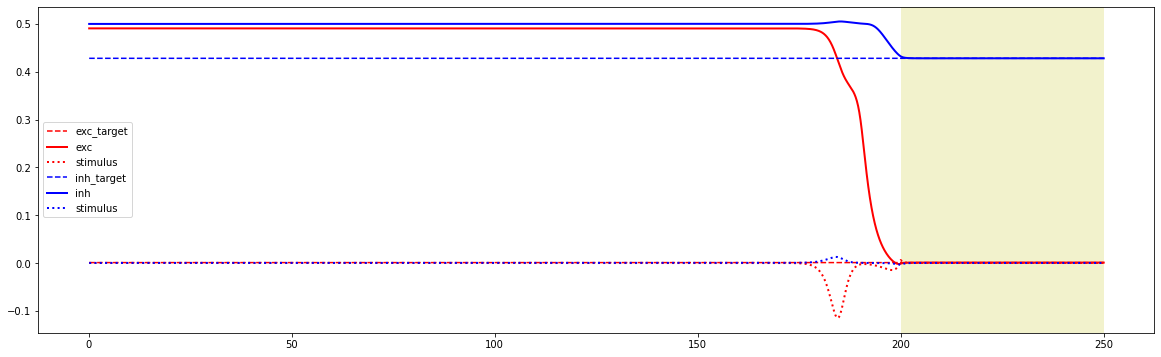

gradient:


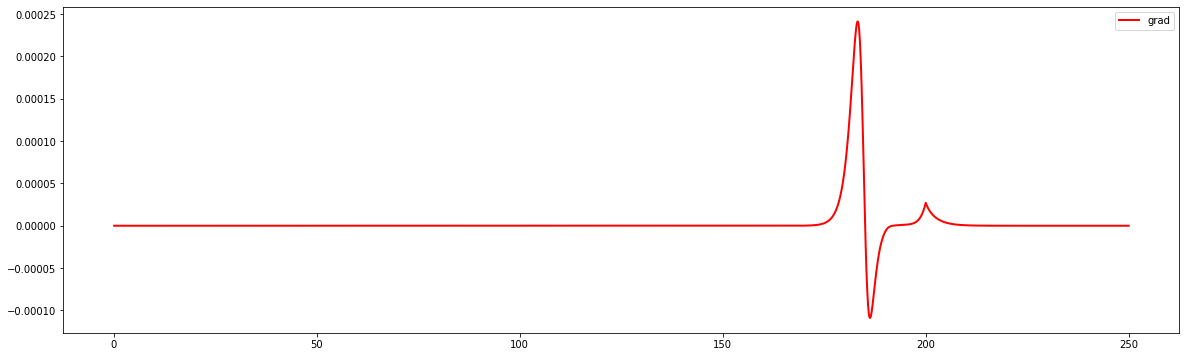

___
iteration: 3100


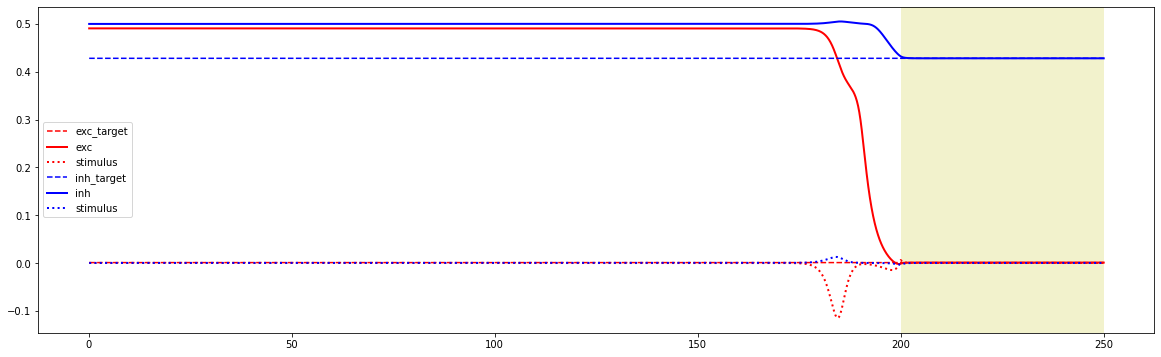

gradient:


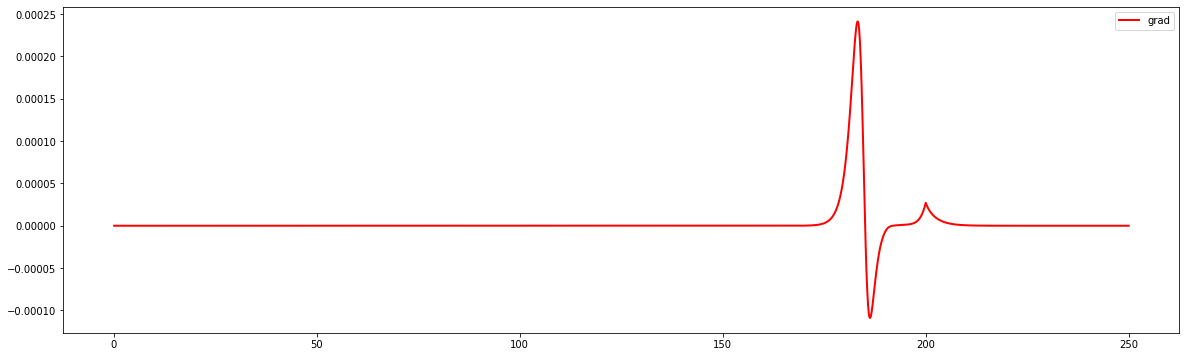

___
iteration: 3200


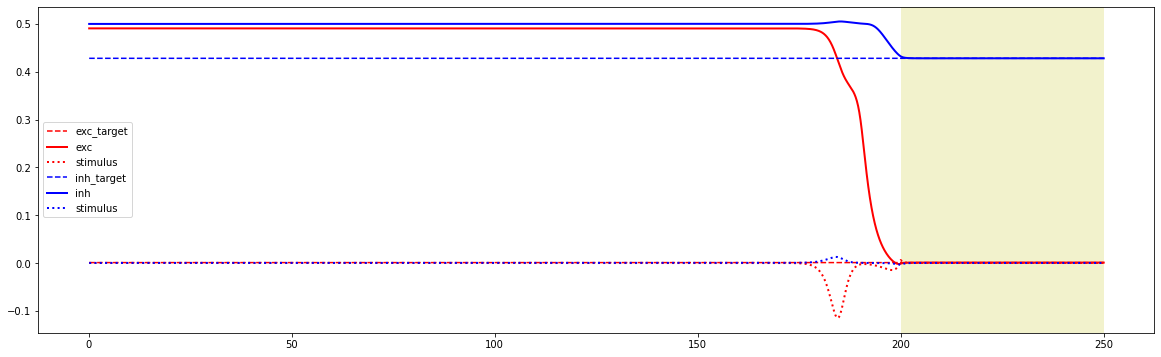

gradient:


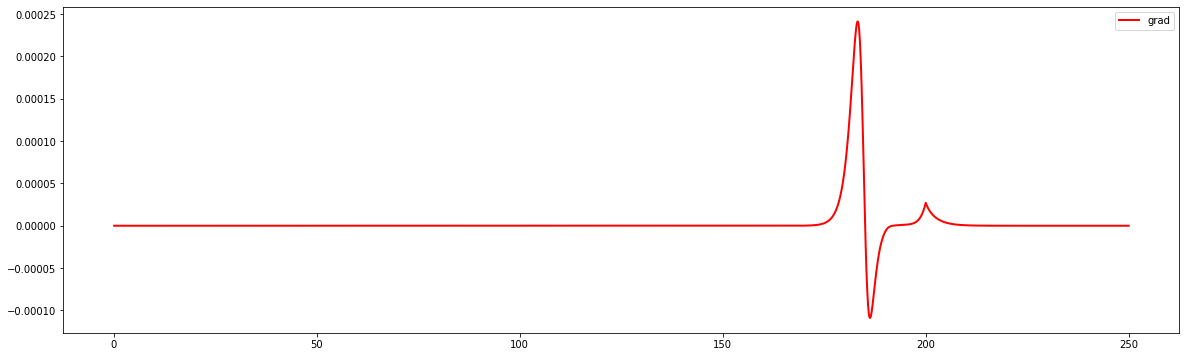

___
iteration: 3300


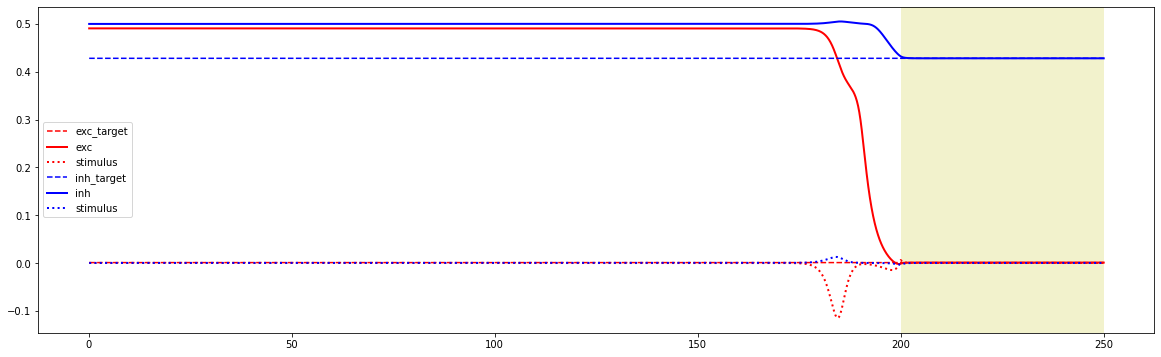

gradient:


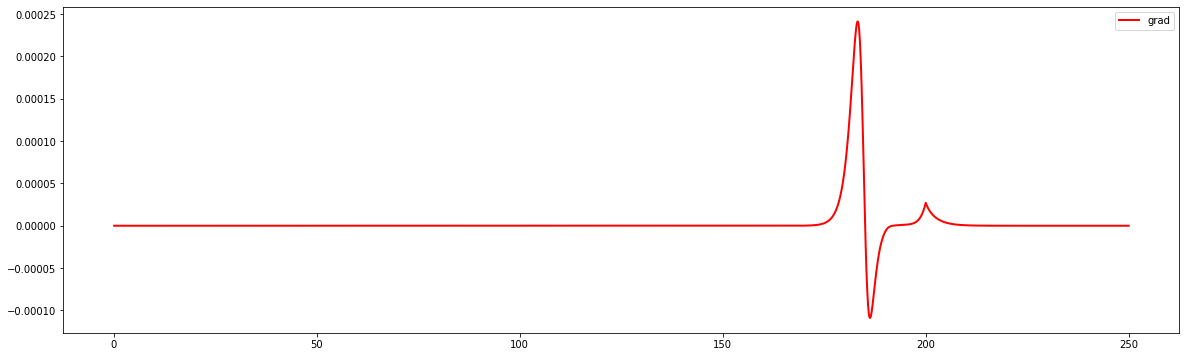

___
iteration: 3400


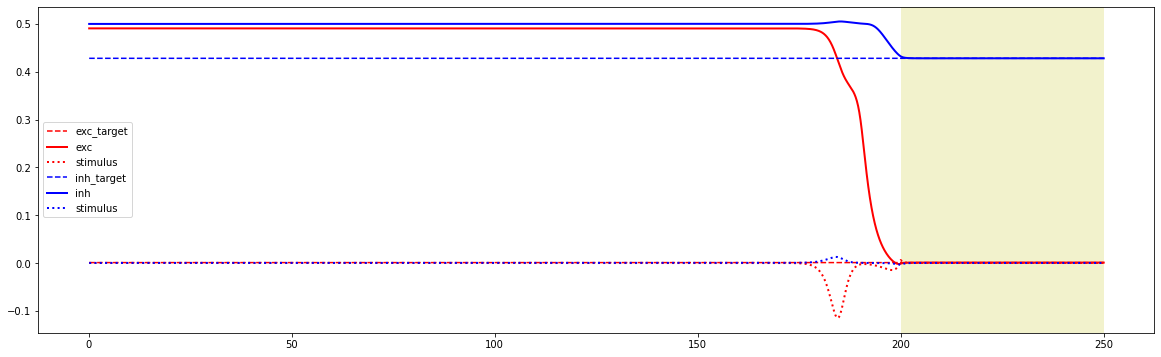

gradient:


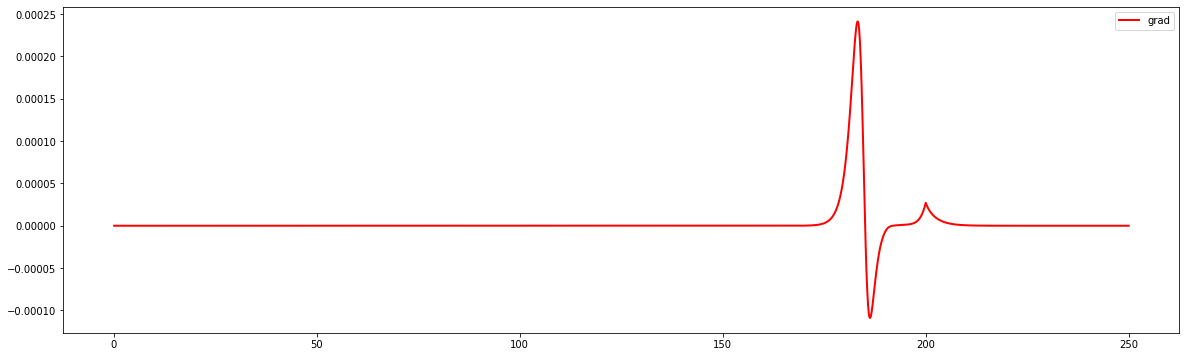

___
iteration: 3500


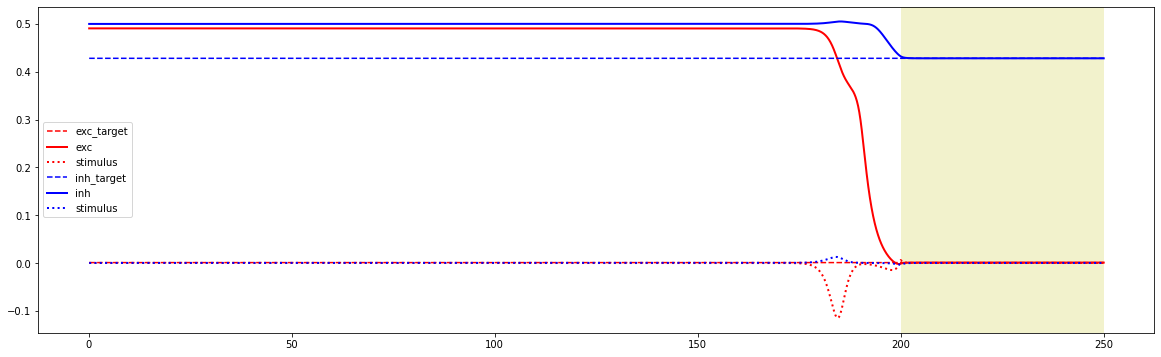

gradient:


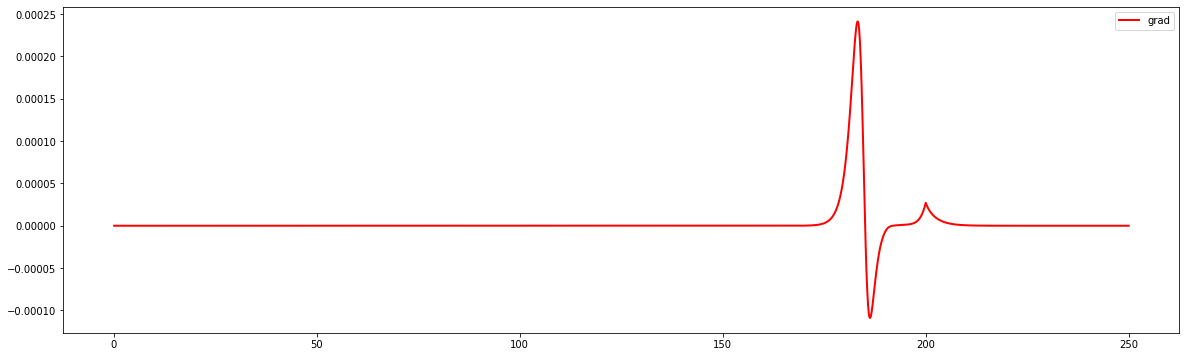

___
iteration: 3600


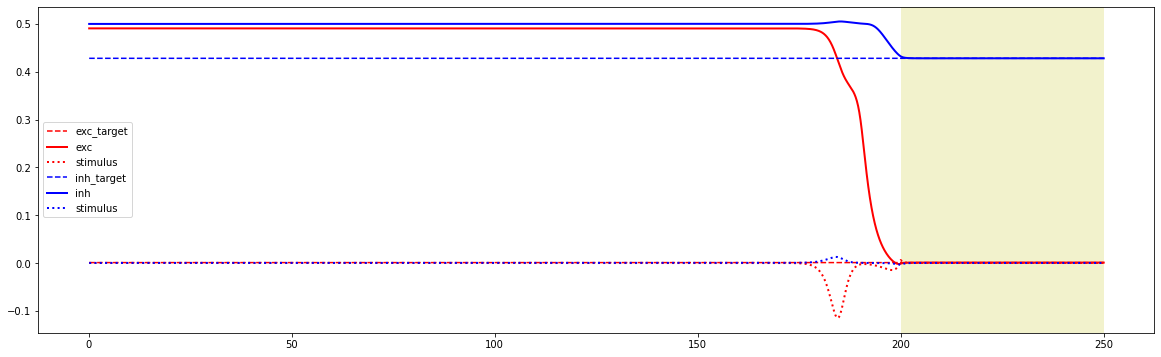

gradient:


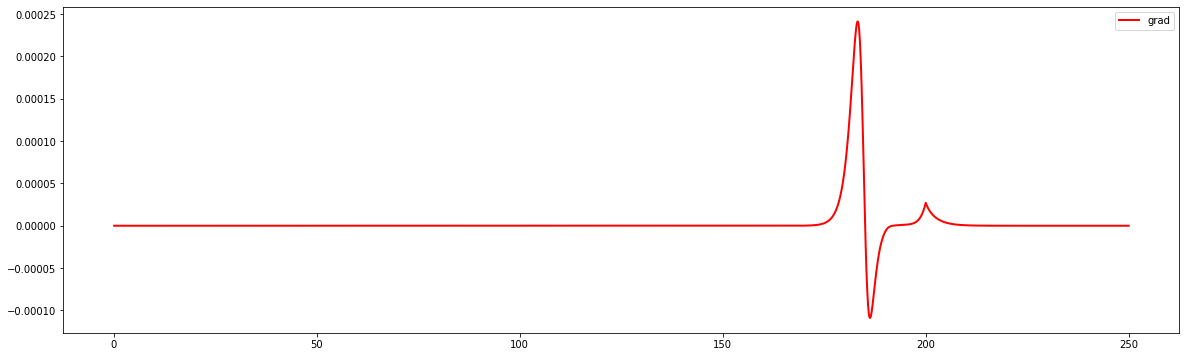

___
iteration: 3700


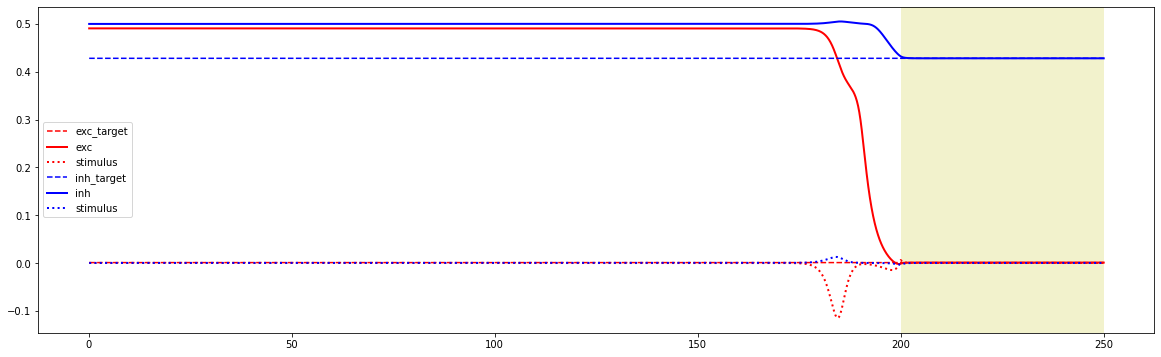

gradient:


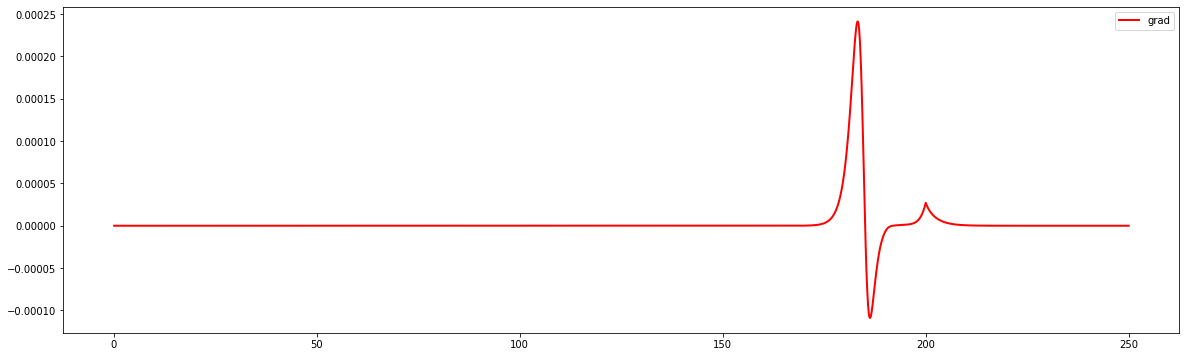

___
iteration: 3800


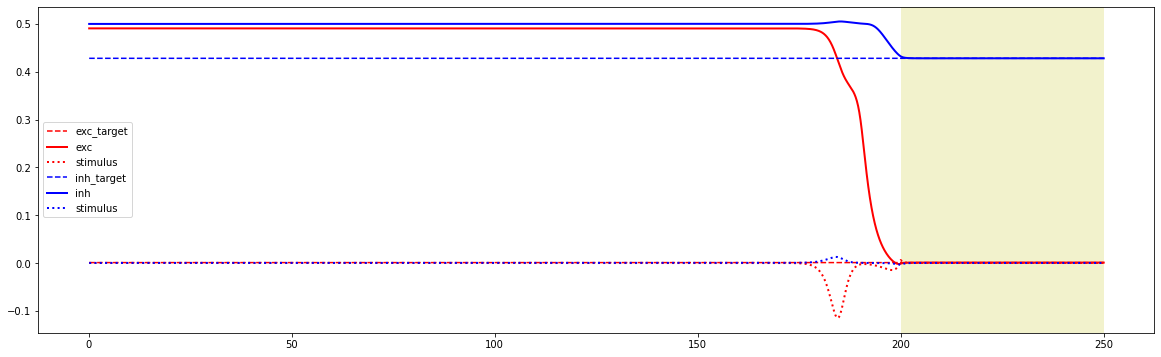

gradient:


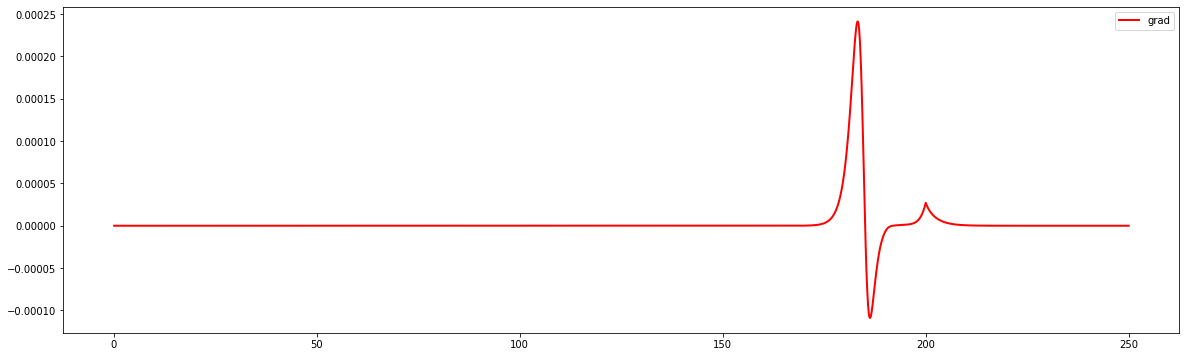

___
iteration: 3900


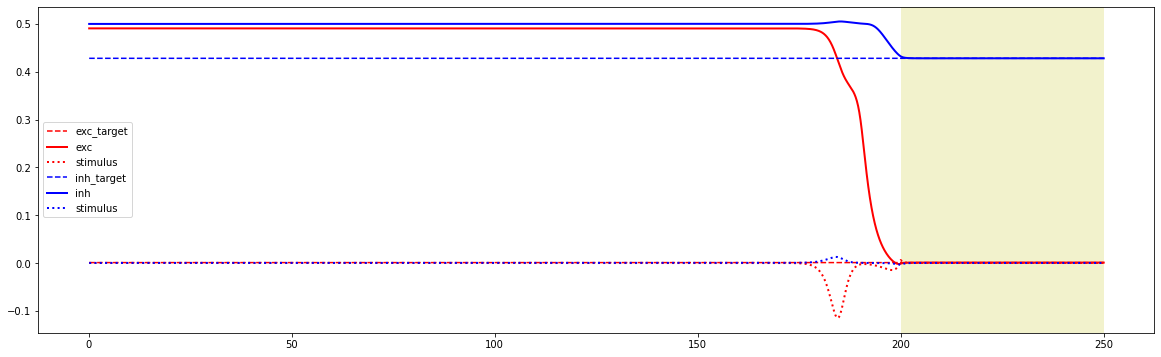

gradient:


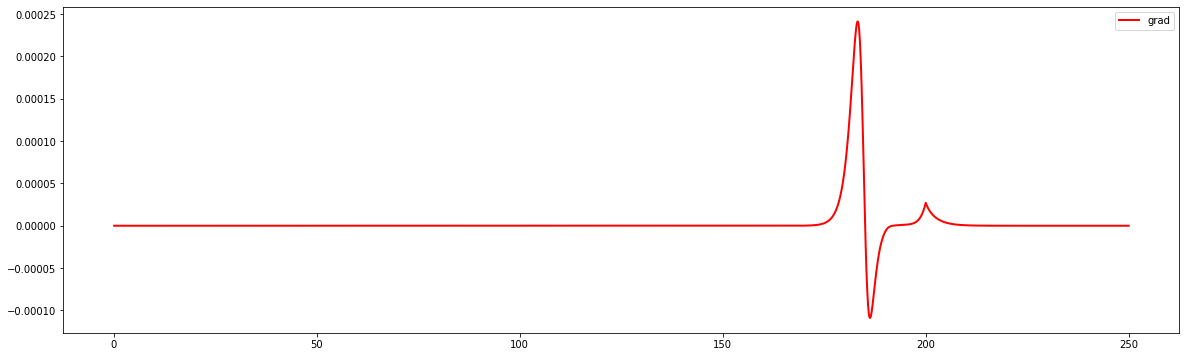

___
iteration: 4000


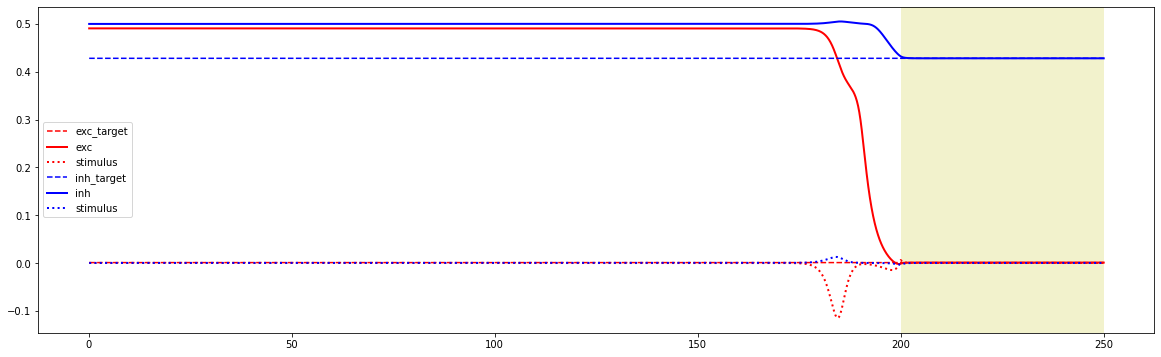

gradient:


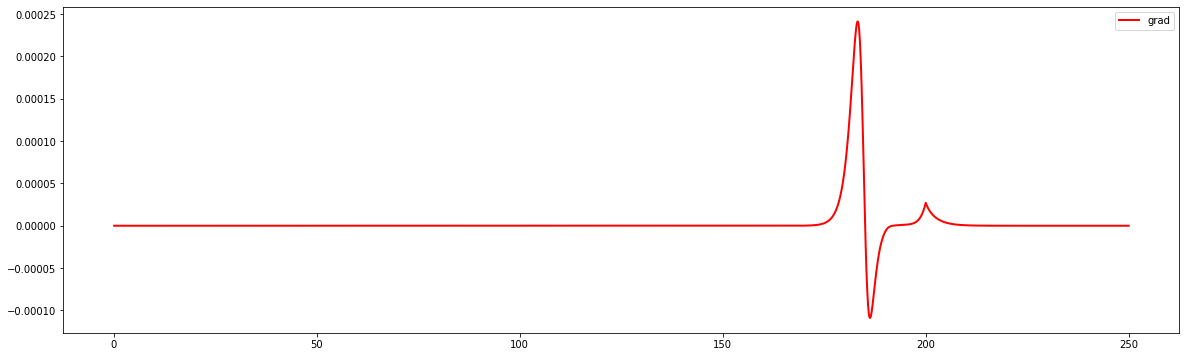

___
iteration: 4100


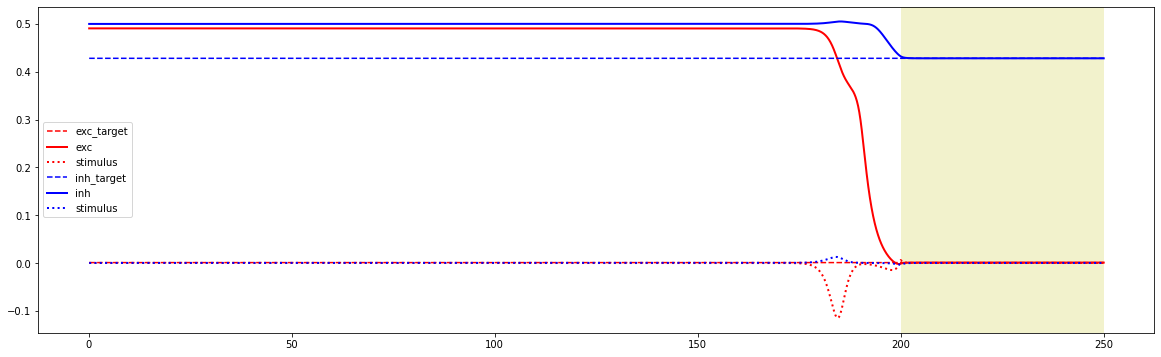

gradient:


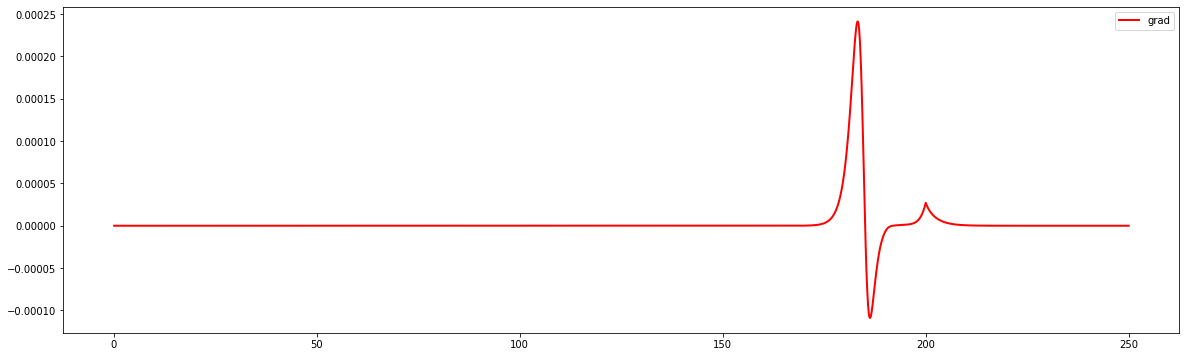

___
iteration: 4200


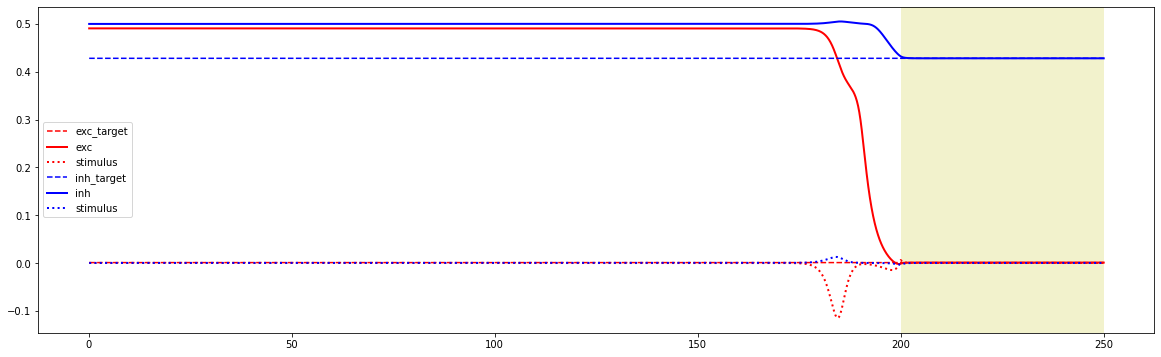

gradient:


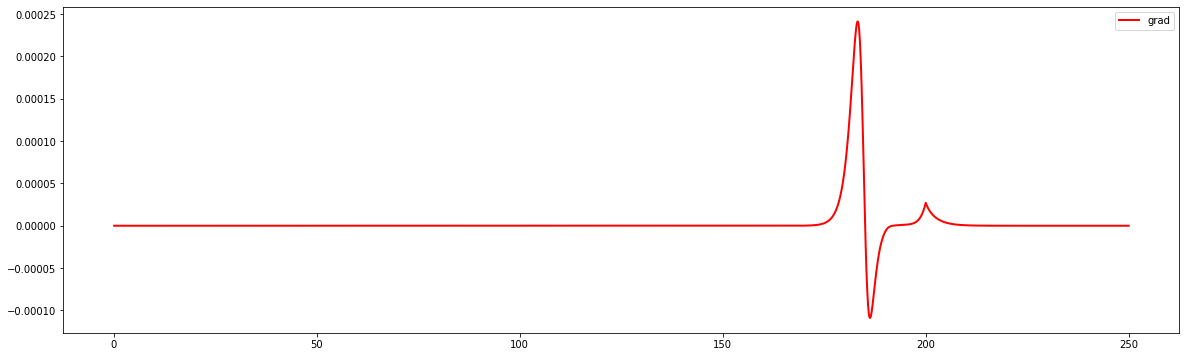

___
iteration: 4300


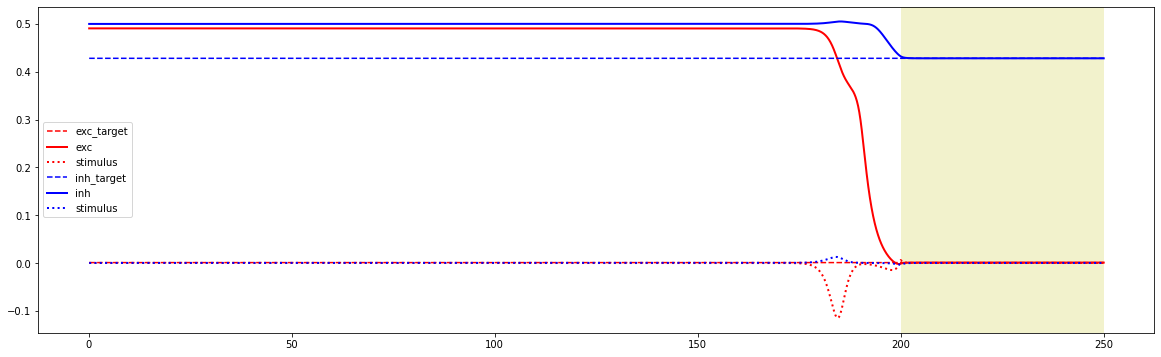

gradient:


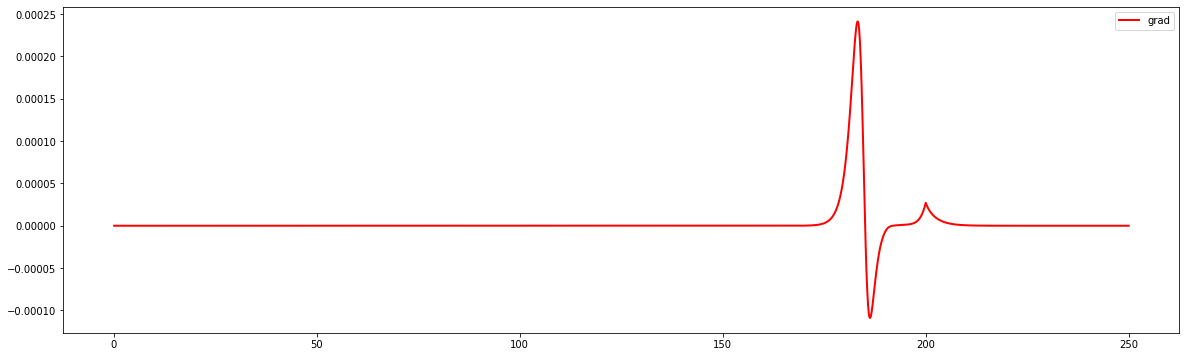

___
iteration: 4400


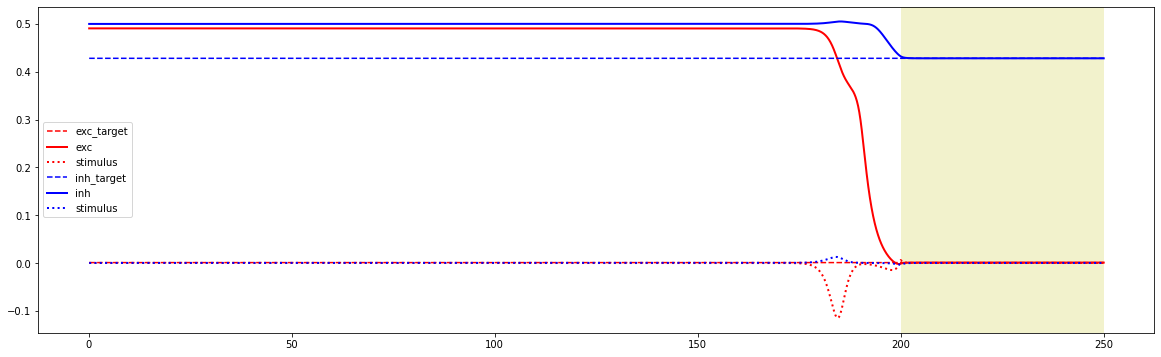

gradient:


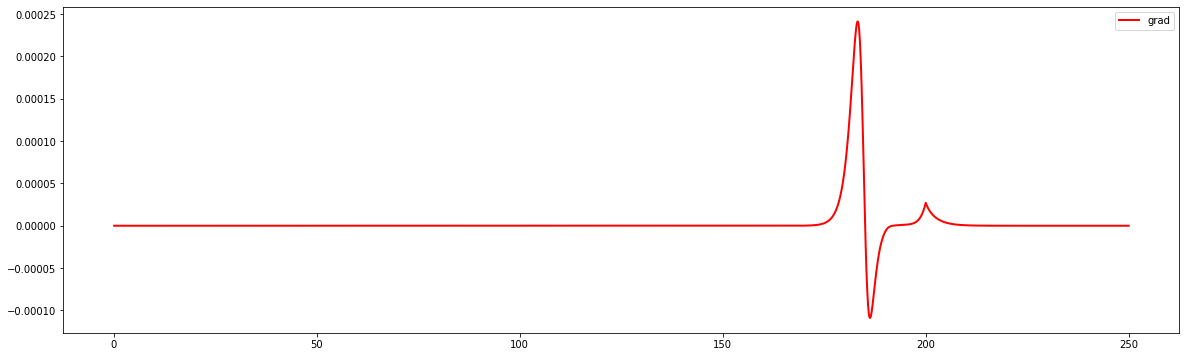

___
iteration: 4500


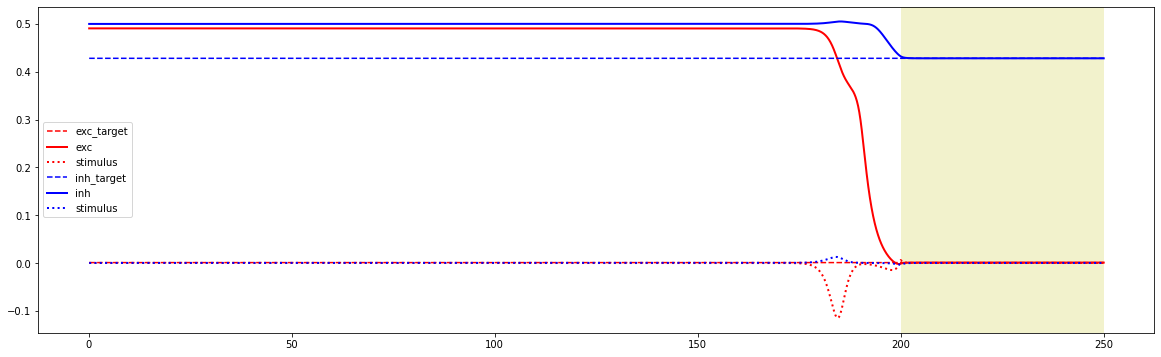

gradient:


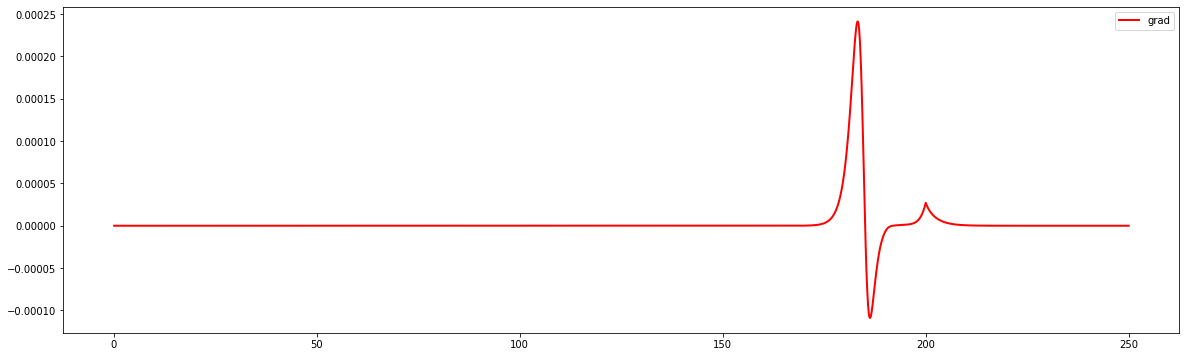

___
iteration: 4600


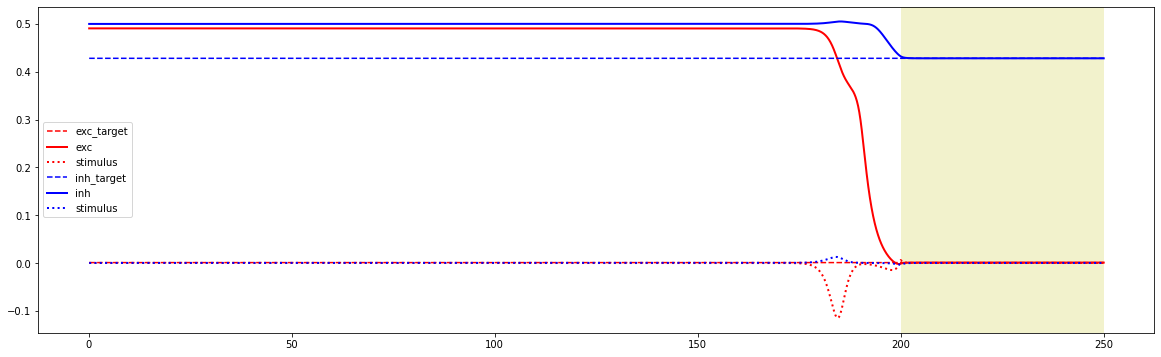

gradient:


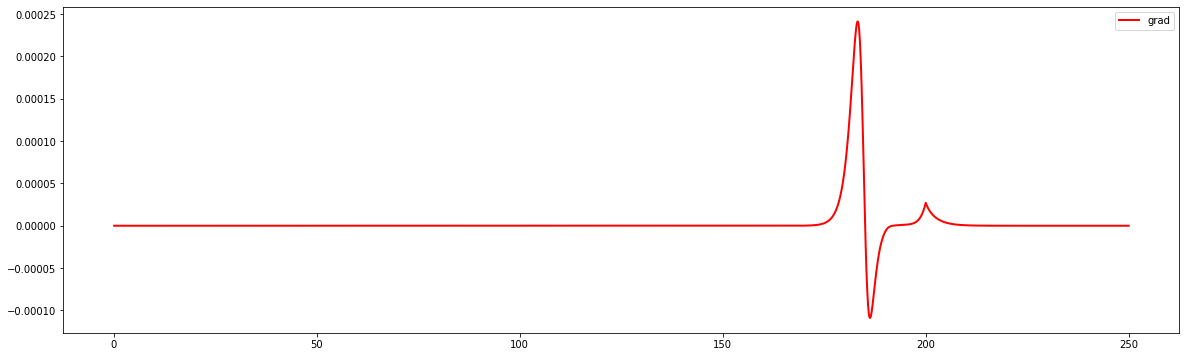

___
iteration: 4700


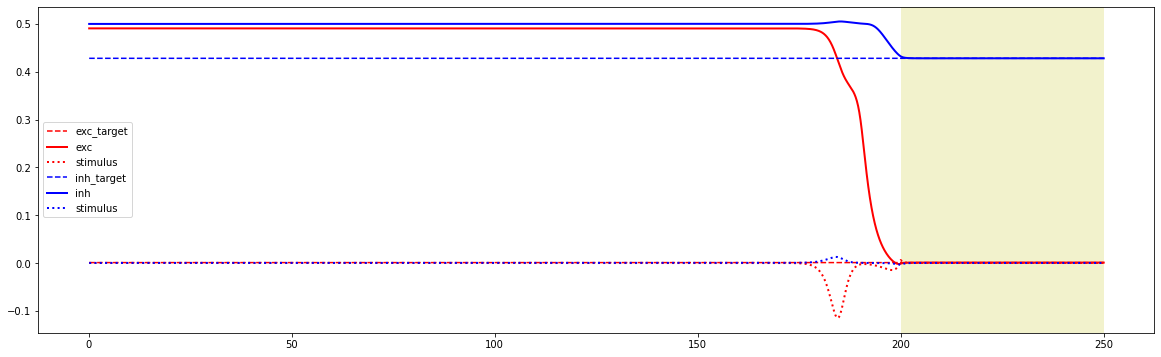

gradient:


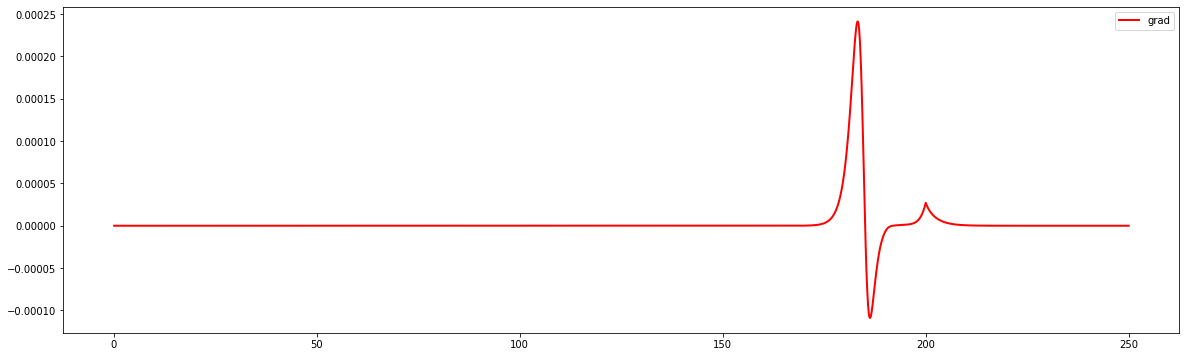

___
iteration: 4800


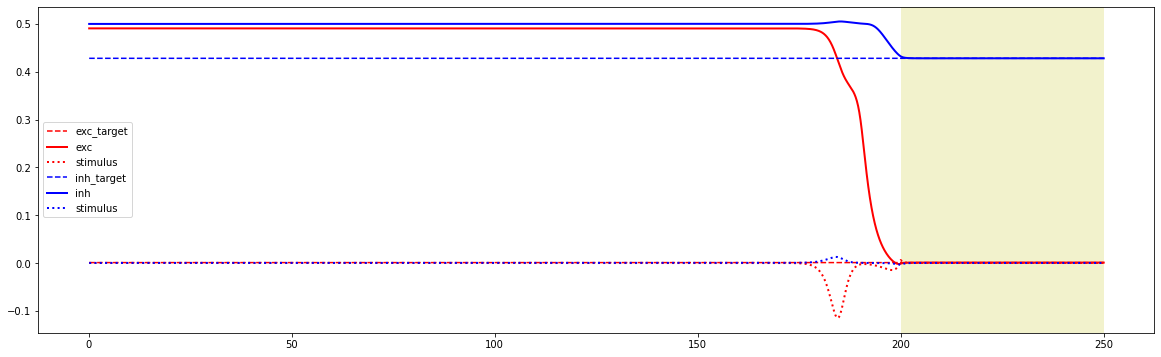

gradient:


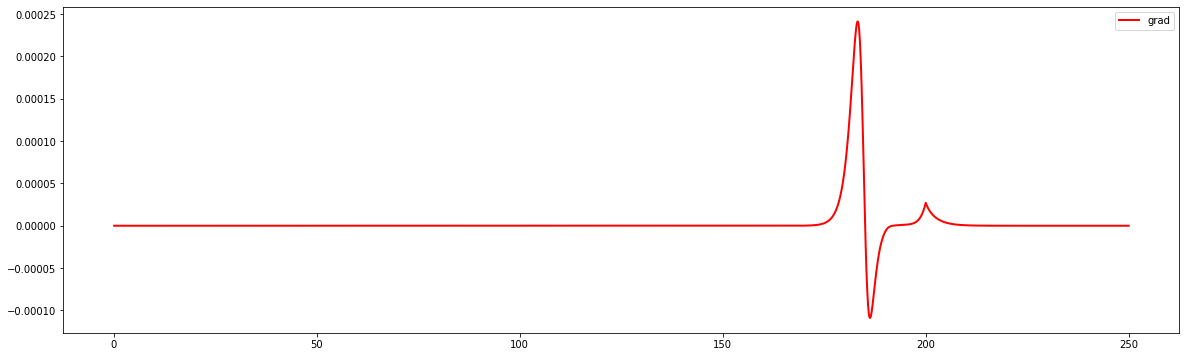

___
iteration: 4900


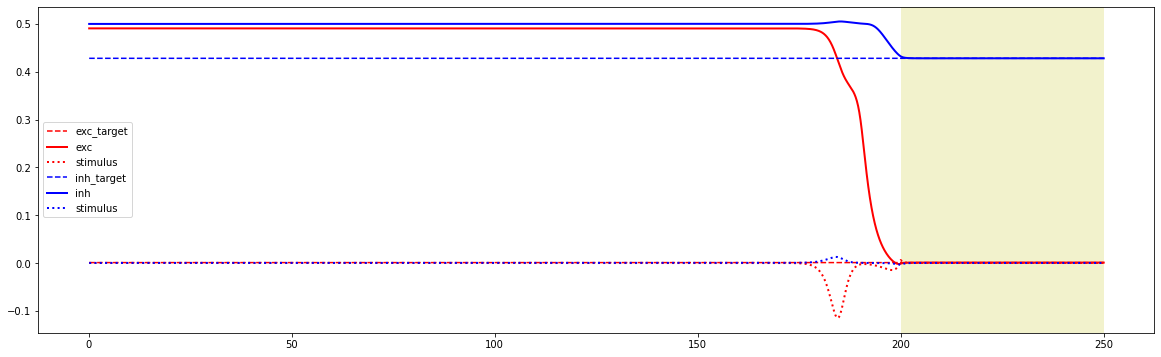

gradient:


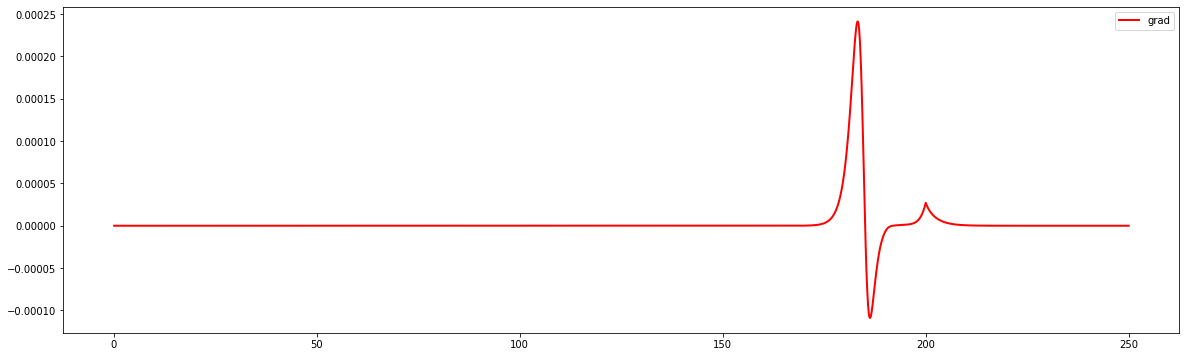

In [476]:
wc = WCModel()




#wc.params["c_inhinh"] = 0
#wc.params["c_excinh"] = 0
#wc.params["c_inhexc"] = 0
#wc.params["c_excexc"] = 0
#wc.params["tau_exc"] = 1  
#wc.params["tau_inh"] = 1
wc.params['exc_ext'] = 3.33
wc.params['inh_ext'] = 5#3.89
#wc.params["K_gl"] = 0
#wc.params["dt"] = 0.1

#wc.params["a_exc"] = 1
#wc.params["a_inh"] = 1



wc.params["exc_init"] = [[0.490690]]
wc.params["inh_init"] =[[0.499998]]

#wc.params["exc_init"] = [[0.45446237]]
#wc.params["inh_init"] = [[0.49949741]]

stimulus = np.zeros((1,2500))

stimulus[0][500:600] = 0
#plt.plot(stimulus.T)


#wc.params['exc_ext'] = 3.33
#wc.params['inh_ext'] = 3.89

wc.params['duration'] = 250


optimal_control(wc, target_low,target_low_inh, stimulus, stimulus, n_iter = 5000, plot_freq = 100, w = [0.01,0.01], a = 2000,debug = False)


#optimal_control(wc, stimulus, target, target)

___
iteration: 0


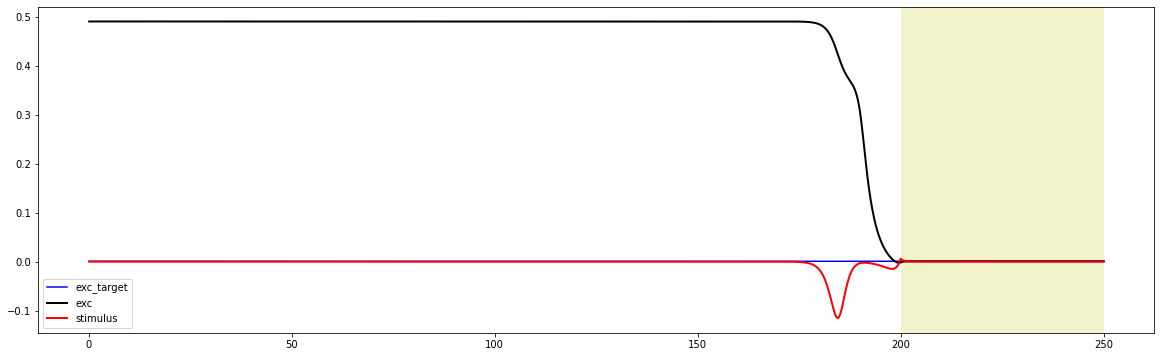

gradient:


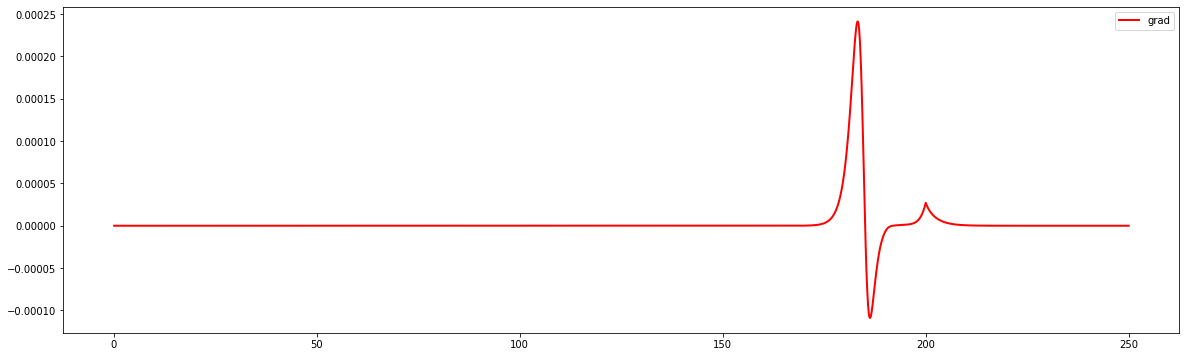

___
iteration: 500


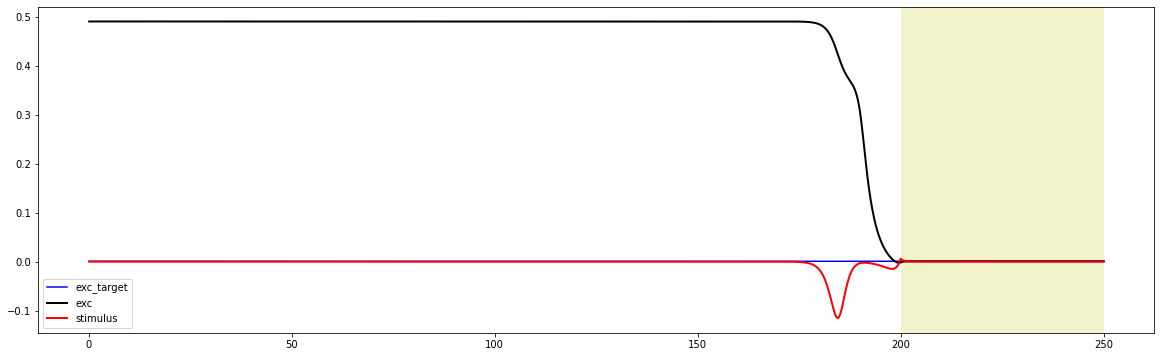

gradient:


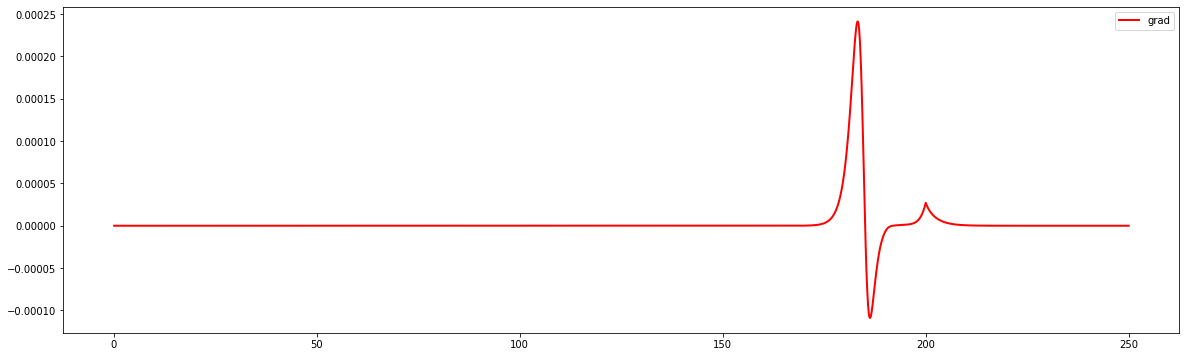

___
iteration: 1000


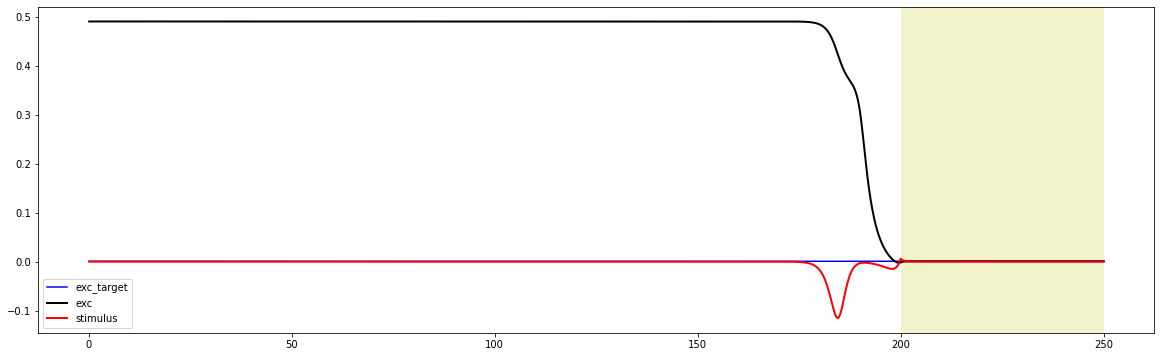

gradient:


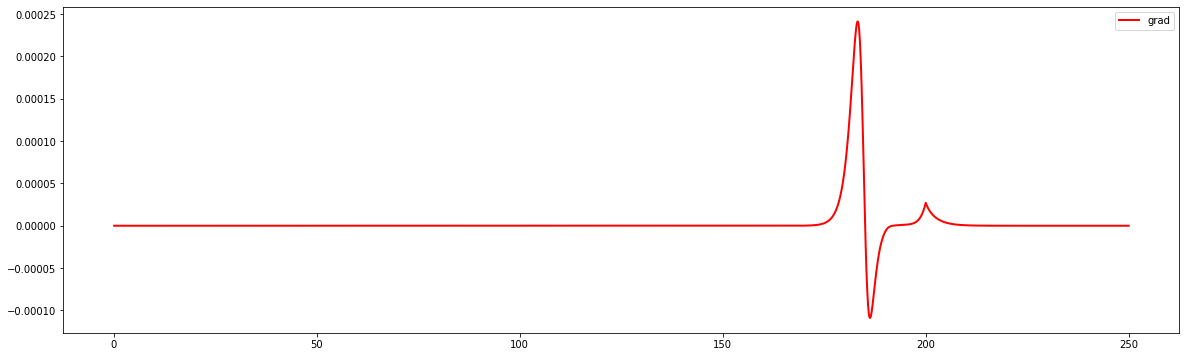

___
iteration: 1500


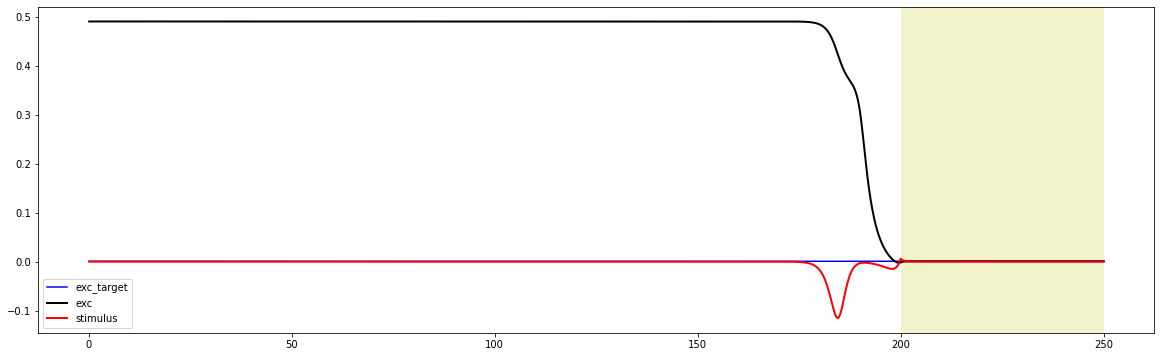

gradient:


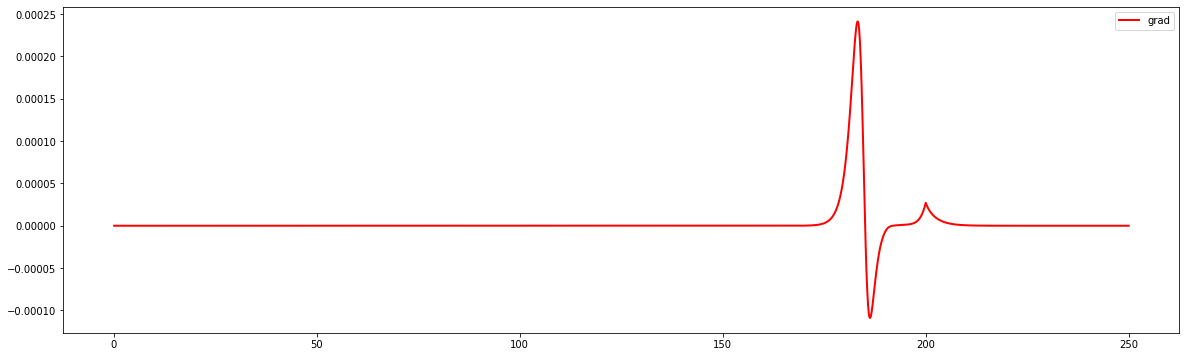

___
iteration: 2000


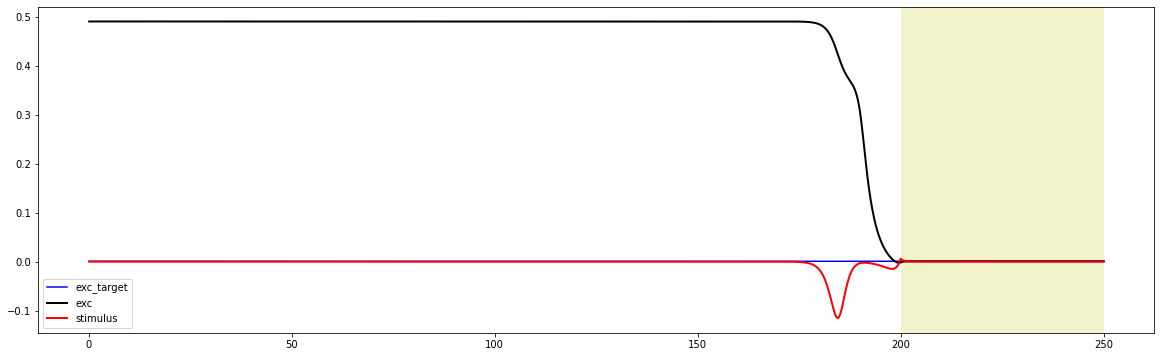

gradient:


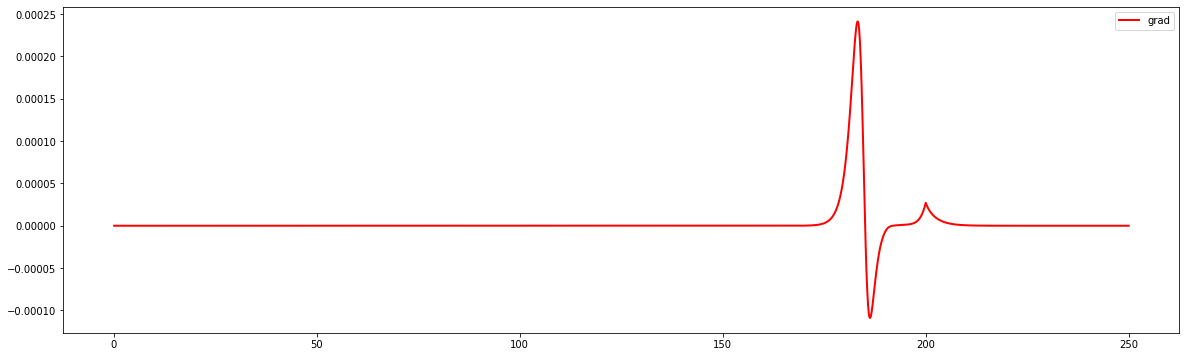

___
iteration: 2500


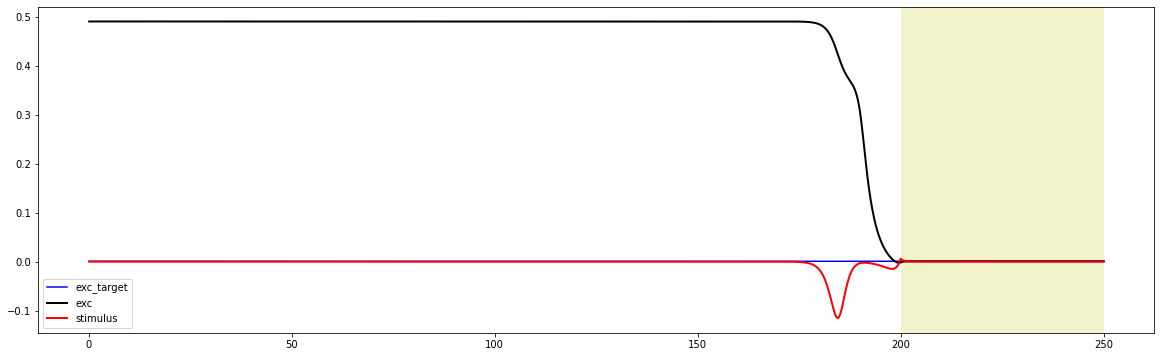

gradient:


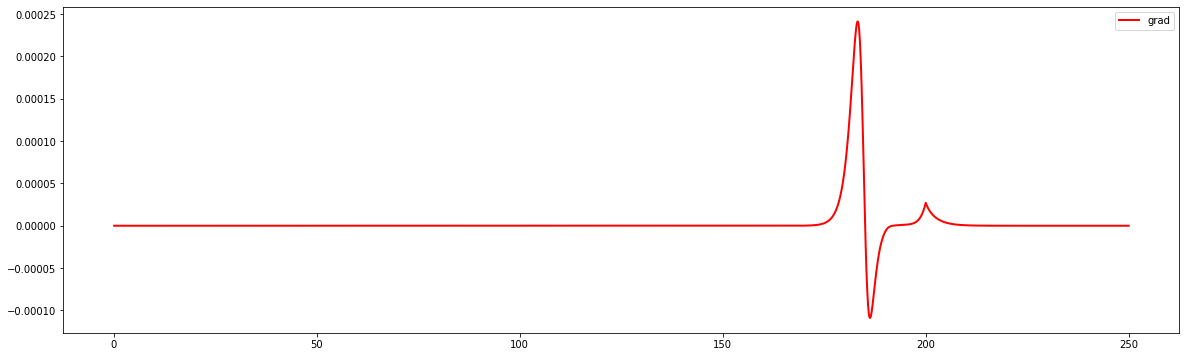

___
iteration: 3000


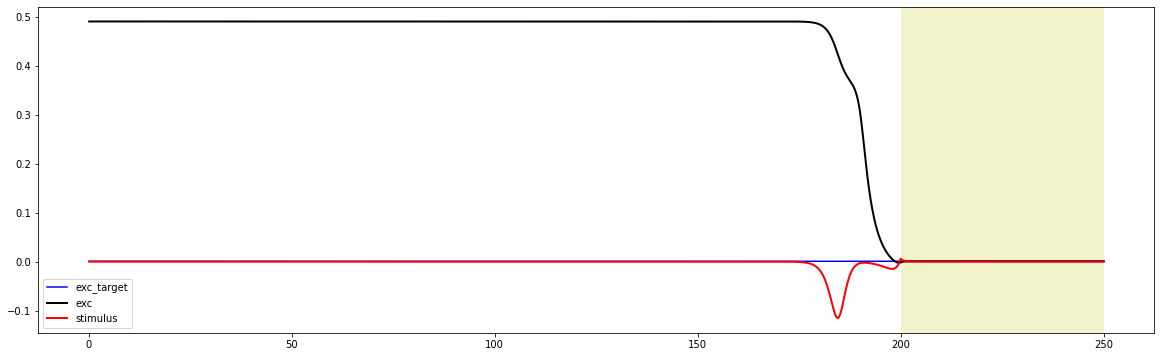

gradient:


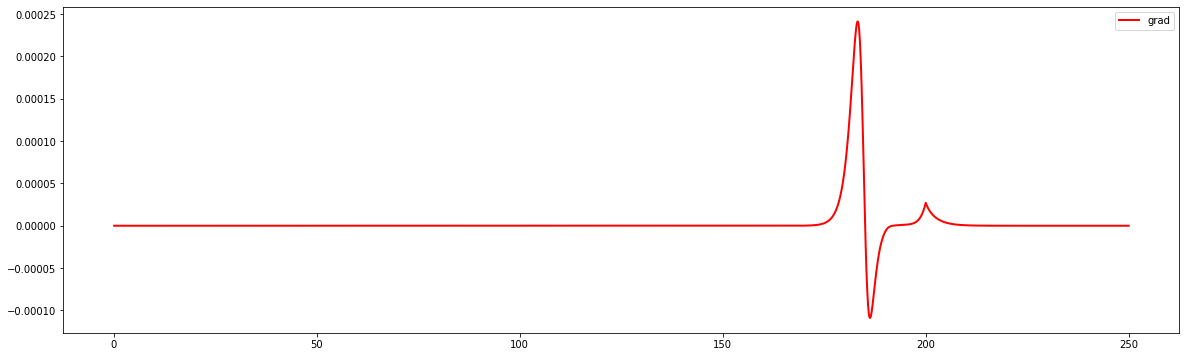

___
iteration: 3500


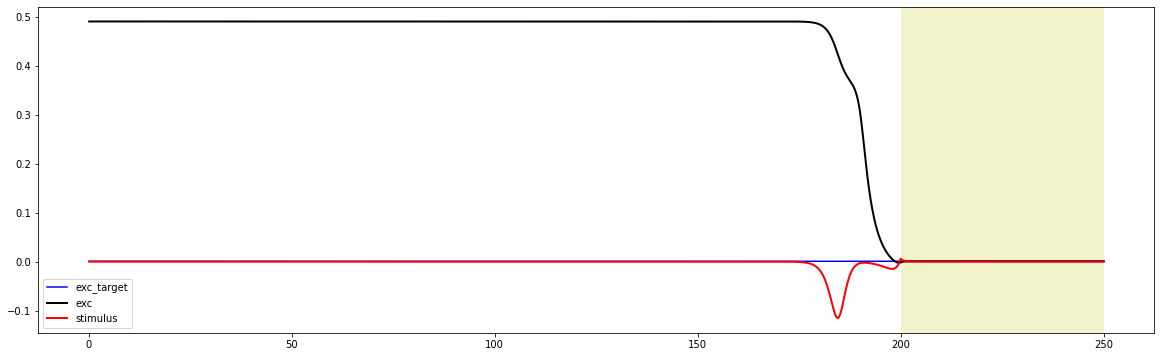

gradient:


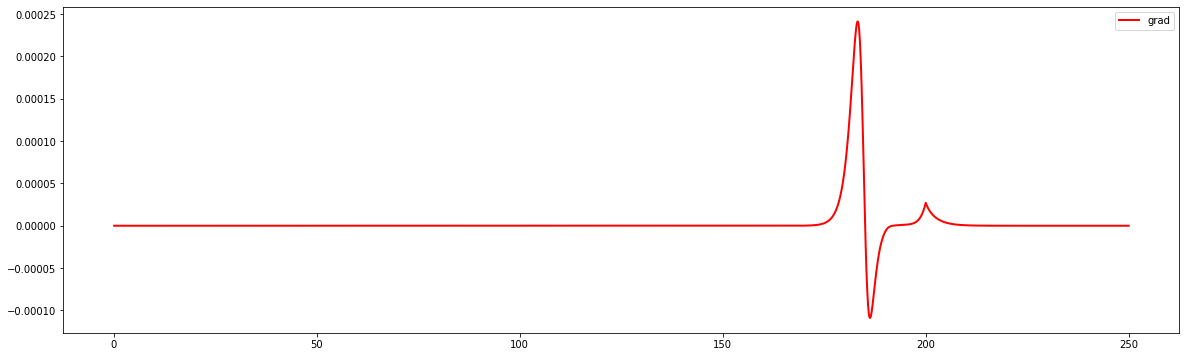

___
iteration: 4000


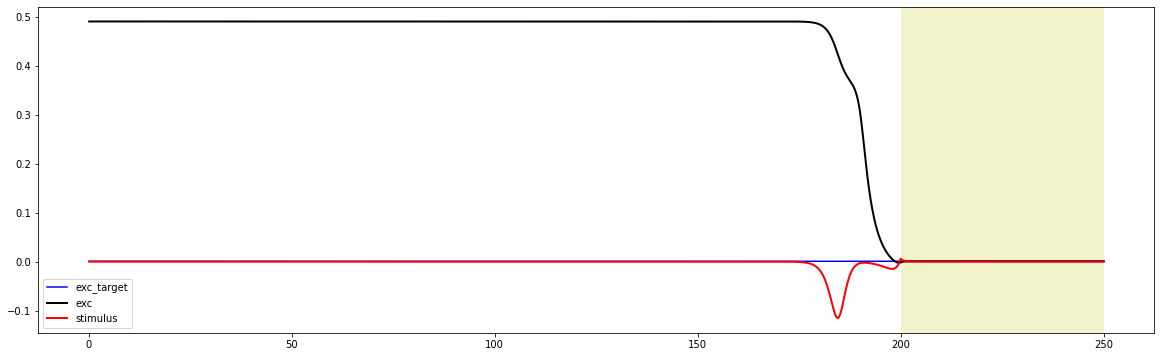

gradient:


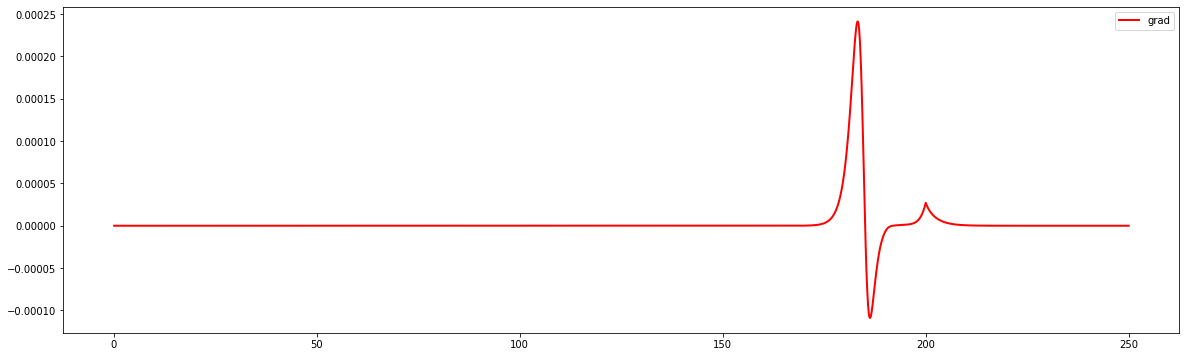

___
iteration: 4500


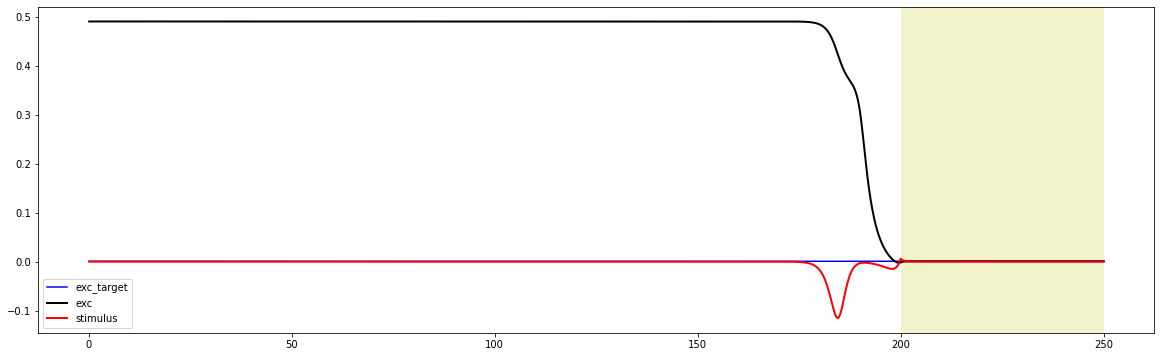

gradient:


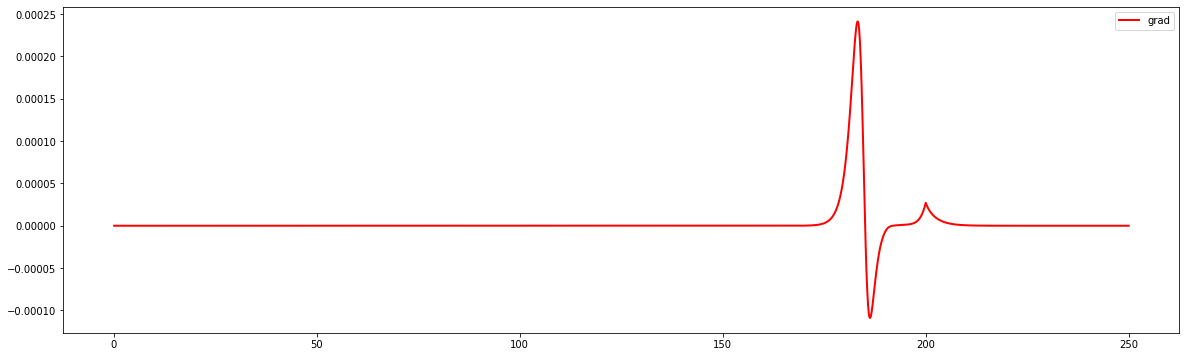

___
iteration: 5000


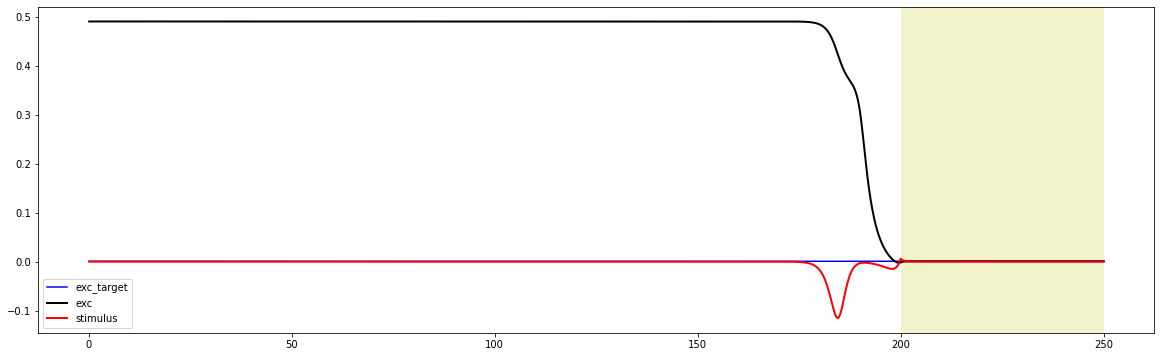

gradient:


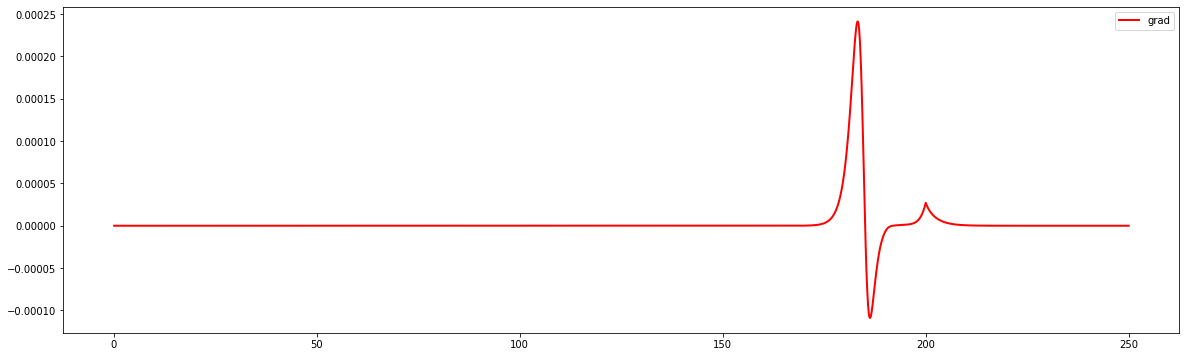

___
iteration: 5500


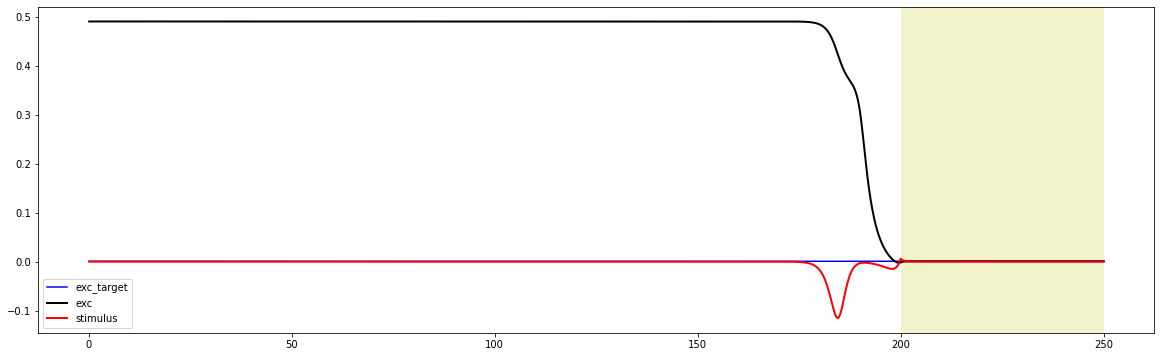

gradient:


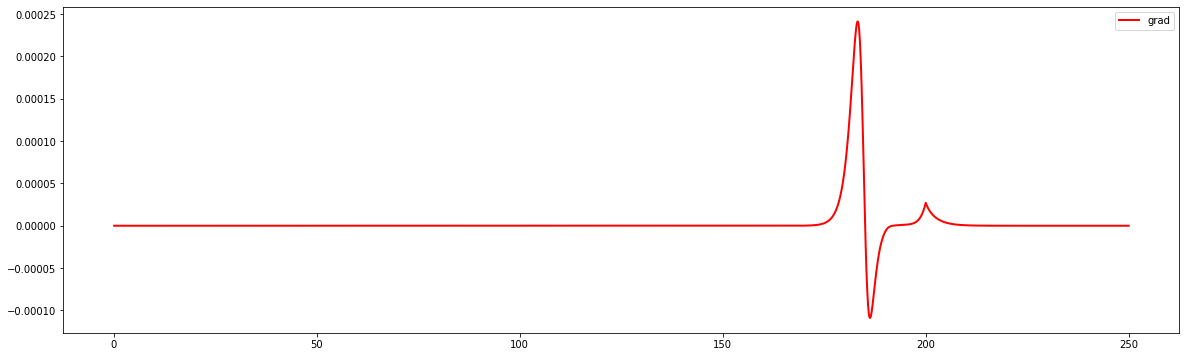

___
iteration: 6000


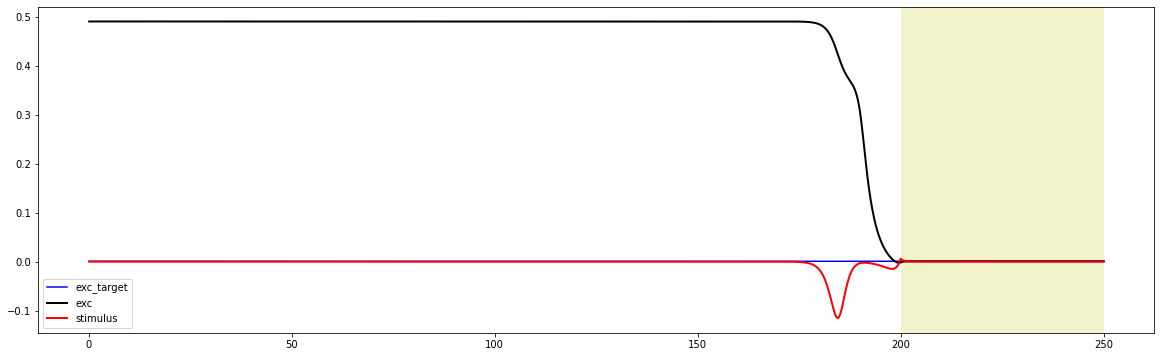

gradient:


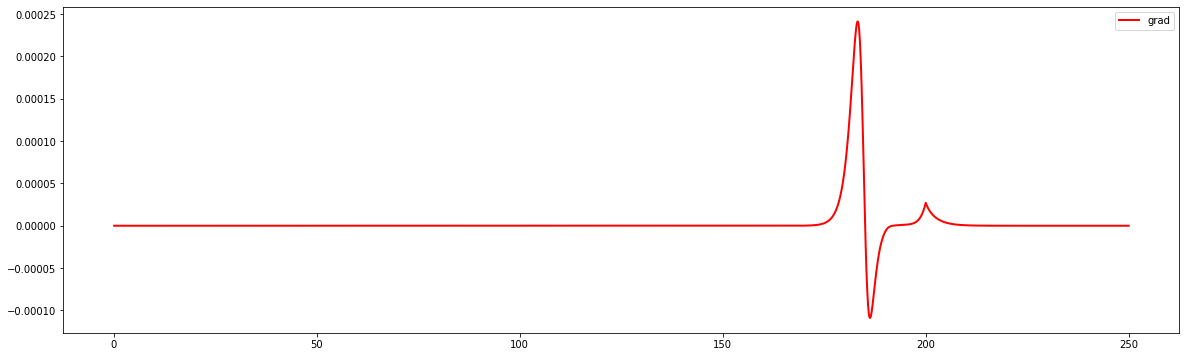

___
iteration: 6500


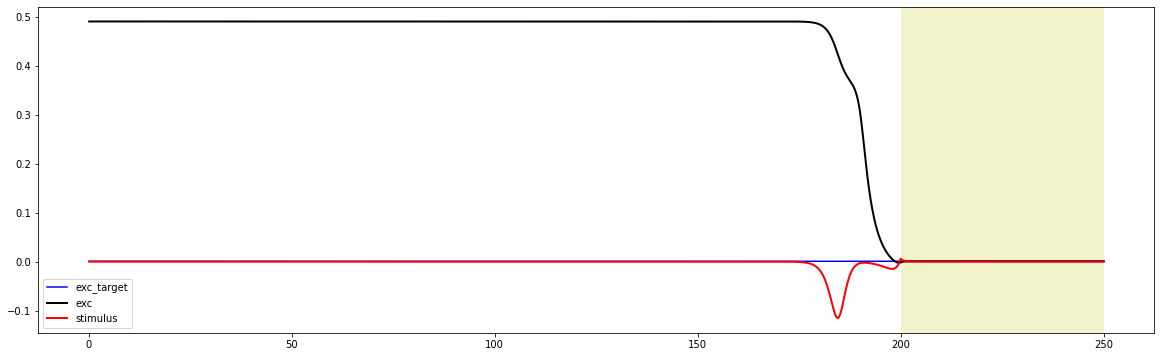

gradient:


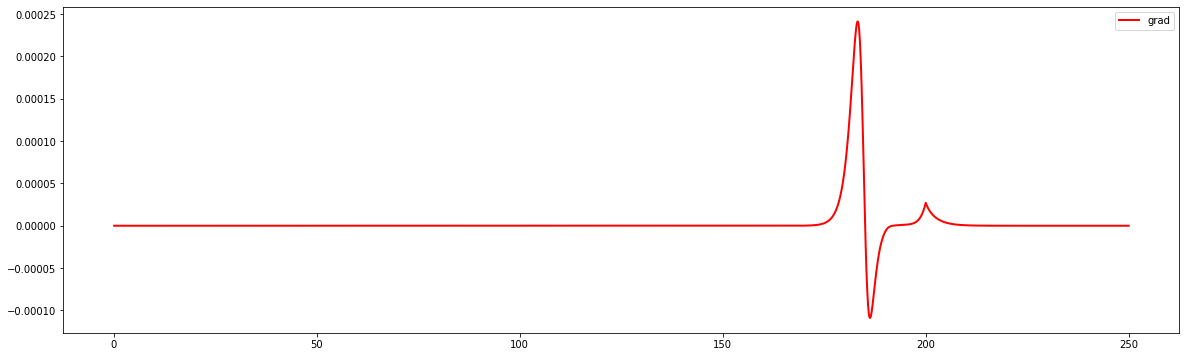

___
iteration: 7000


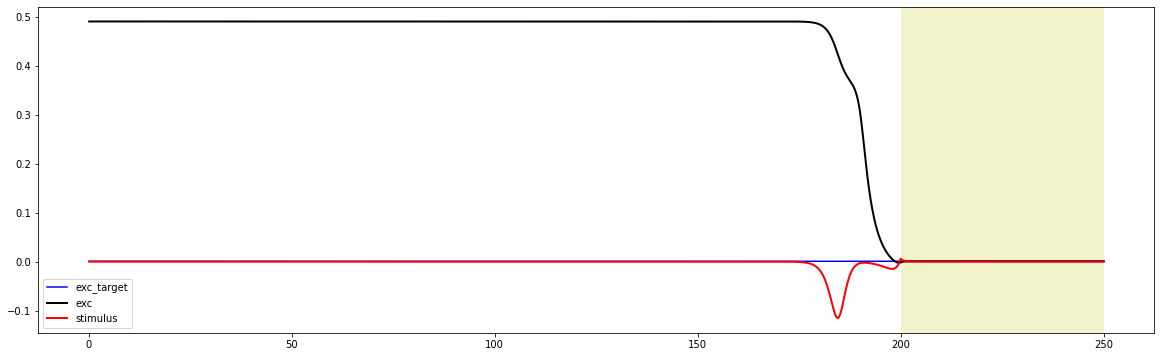

gradient:


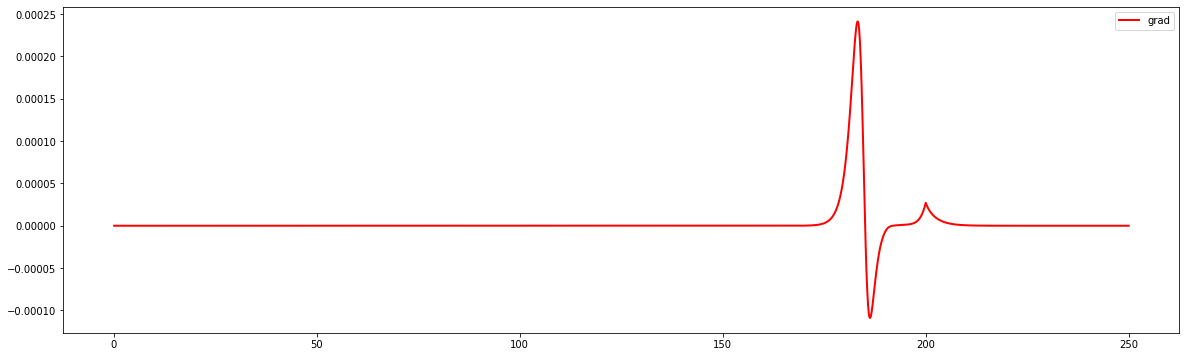

___
iteration: 7500


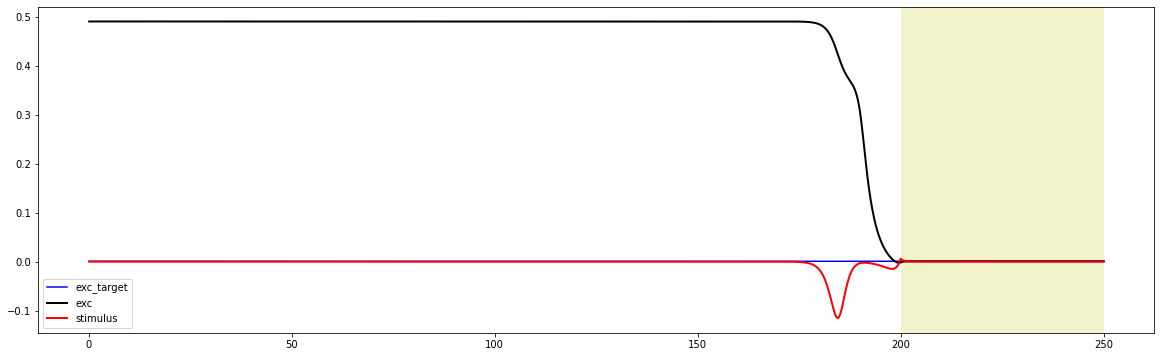

gradient:


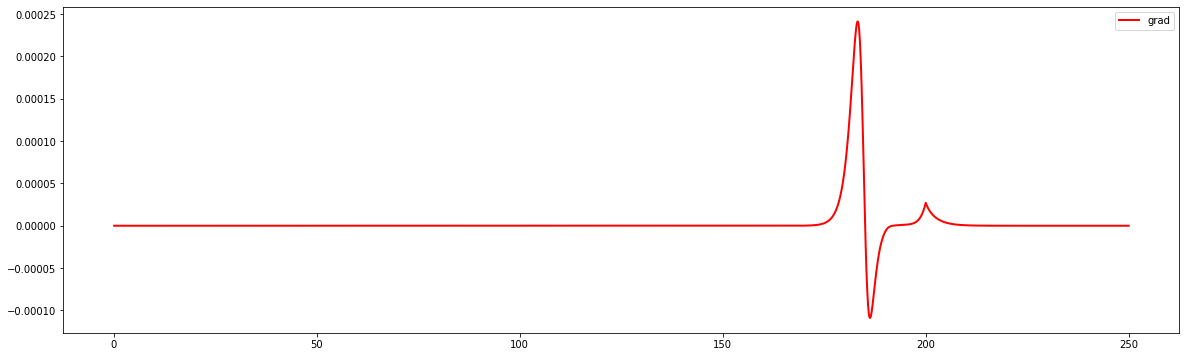

KeyboardInterrupt: 

In [464]:
wc = WCModel()




#wc.params["c_inhinh"] = 0
#wc.params["c_excinh"] = 0
#wc.params["c_inhexc"] = 0
#wc.params["c_excexc"] = 0
#wc.params["tau_exc"] = 1  
#wc.params["tau_inh"] = 1
wc.params['exc_ext'] = 3.33
wc.params['inh_ext'] = 5#3.89
#wc.params["K_gl"] = 0
#wc.params["dt"] = 0.1

#wc.params["a_exc"] = 1
#wc.params["a_inh"] = 1



wc.params["exc_init"] = [[0.490690]]
wc.params["inh_init"] =[[0.499998]]

#wc.params["exc_init"] = [[0.45446237]]
#wc.params["inh_init"] = [[0.49949741]]

stimulus = np.zeros((1,2500))

stimulus[0][500:600] = 0
#plt.plot(stimulus.T)


#wc.params['exc_ext'] = 3.33
#wc.params['inh_ext'] = 3.89

wc.params['duration'] = 250


optimal_control(wc, target_low,target_low_inh, a1, a2, n_iter = 20000, plot_freq = 500, w = [0.01,0.01], a = 2000,debug = False)


#optimal_control(wc, stimulus, target, target)

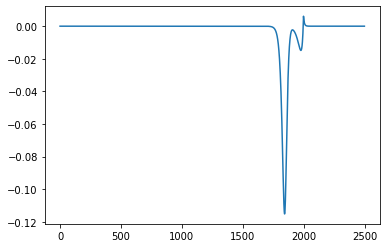

In [462]:
a1 = wc.params["control_term_E"]
a2 = wc.params["control_term_I"]
plt.plot(a1[0])

# Toy example

In [ ]:
from neurolib.models.wc import WCModel
wc = WCModel()
wc.params["a_exc"] = 1
wc.params["a_inh"] = 1
#wc.params['exc_ext'] = 3.33
#wc.params['inh_ext'] = 3.89
#wc.params["c_inhinh"] = 0
#wc.params["c_excinh"] = 0
#wc.params["c_inhexc"] = 0
#wc.params["c_excexc"] = 0
#wc.params["tau_exc"] = 1  
#wc.params["tau_inh"] = 1
#wc.params["exc_ext"] = 0
#wc.params["inh_ext"] = 0
#wc.params["K_gl"] = 0
#wc.params["dt"] = 0.1
wc.params['duration'] = 1


In [ ]:
#stimulus
stimulus = np.zeros((1,10))
stimulus[0][4] = -1

#plt.plot(stimulus.T)



wc.params["control_term_E"] = stimulus
#wc.params["control_term_I"] = stimulus
wc.run()
exc=wc.exc[0]
inh = wc.inh[0]

plt.figure(figsize = (20, 6))
plt.plot(wc.t, stimulus.T, c = 'r')
plt.plot(wc.t, wc.exc[0].tolist(), c='k', lw = 2)

#0.02788229


In [ ]:
wc = WCModel()
wc.params["a_exc"] = 1
wc.params["a_inh"] = 1

#wc.params["c_inhinh"] = 0
#wc.params["c_excinh"] = 0
#wc.params["c_inhexc"] = 0
#wc.params["c_excexc"] = 0
#wc.params["tau_exc"] = 1  
#wc.params["tau_inh"] = 1
#wc.params["exc_ext"] = 0
#wc.params["inh_ext"] = 0
#wc.params["K_gl"] = 0
#wc.params["dt"] = 0.1
wc.params['duration'] = 1

stimulus = np.zeros((1,10))




optimal_control(wc, exc,inh, stimulus, n_iter = 1000, plot_freq = 100, w = [0.0,0.0], a = 6, debug = False)
#optimal_control(wc, stimulus, target, target)

In [ ]:
wc = WCModel()
wc.params["a_exc"] = 1
wc.params["a_inh"] = 1
wc.params['duration'] = 1

stimulus = np.zeros((1,10))




optimal_control(wc, exc,inh, stimulus, n_iter = 20, plot_freq = 1, w = [0.0,0.0], a = 0, debug = False)
#optimal_control(wc, stimulus, target, target)

## Drafts

In [131]:
wc.params['exc_ext'] = 0
wc.params['inh_ext'] = 0
wc.run()

(1, 20000)


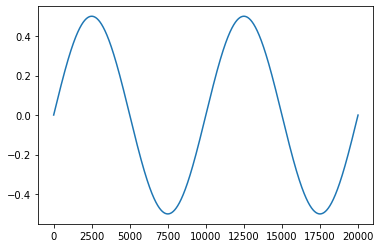

In [156]:
stimulus = stim.SinusoidalInput(amplitude=0.5, frequency=1).to_model(wc)
print(stimulus.shape)
plt.plot(stimulus.T)
wc.params["control_term"] = stimulus

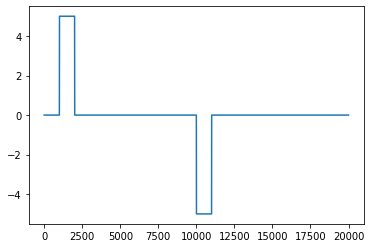

In [196]:
stimulus = np.zeros((20000))
stimulus[1000:2000] = 5
stimulus[10000:11000] = -5
plt.plot(stimulus)

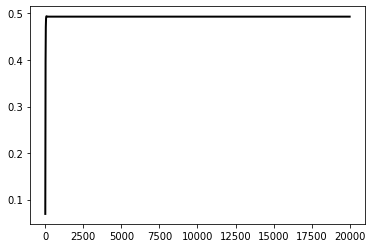

In [182]:
wc = WCModel()
#wc.params["control_term"] = s
wc.params['exc_ext'] = 3.5
wc.params['inh_ext'] = 3.5
wc.run()
plt.plot(range(int(wc.params['duration']/wc.params['dt'])), wc.exc[0].tolist(), c='k', lw = 2)
#plt.plot(s)
plt.show()
target = wc.exc[0]


In [ ]:
plt.plot(exc_inputs, max_exc, c='k', lw = 2)
plt.plot(exc_inputs, min_exc, c='k', lw = 2)
plt.title("Bifurcation diagram of the Wilson-Cowan model")
plt.xlabel("Input to exc")
plt.ylabel("Min / max exc")

In [ ]:
def dh1_dE():
    return 1

def dh2_dE():
    return 2

def dh1_dI():
    return 3

def dh2_dI():
    return 4

def df_dE():
    return 0

def df_dI():
    return 0

lambd1 = 1
lambd2 = 2
Dxh = np.array([[ dh1_dE(), dh1_dI()], 
                  [dh2_dE(), dh2_dI()]])
lambdas = np.array([lambd1, lambd2])

Dxf = np.array([df_dE(), df_dI()])

tauE = 2
tauI = 8

Dx_doth = np.array([[ -tauE, 0], 
                  [0, -tauI]])
x = np.linalg.solve(Dx_doth, b)

(Dxf - lambdas@Dxh)@np.linalg.inv(Dx_doth)



In [ ]:
exp = stim.SinusoidalInput(amplitude=0.5, frequency=0.5).to_model(wc)
#exp = stim.StepInput(step_size=0.5, start=10, end=80, n=2).to_model(wc)
plt.plot(exp.T)

## Single node simulation

In [ ]:
wc = WCModel()
wc.params['duration'] = 1.0*1000
wc.params['sigma_ou'] = 0.01

wc.run()

In [ ]:
plt.plot(wc.t, wc.exc.T, c='k', lw = 2)
plt.xlabel("t [ms]")
plt.ylabel("Activity")

## Brain network

In [ ]:
from neurolib.utils.loadData import Dataset

ds = Dataset("hcp")

In [ ]:
wc = WCModel(Cmat = ds.Cmat, Dmat = ds.Dmat)

In [ ]:
wc.params['exc_ext'] = 0.65

wc.params['signalV'] = 0
wc.params['duration'] = 20 * 1000 
wc.params['sigma_ou'] = 0.14
wc.params['K_gl'] = 3.15


wc.run(chunkwise=True)

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 3))
axs[0].imshow(func.fc(wc.exc[:, -10000:]))
axs[1].plot(wc.t, wc.exc[::5, :].T, alpha=0.8);
axs[1].set_xlim(0, 200)

In [ ]:
scores = [func.matrix_correlation(func.fc(wc.exc[:, -int(5000/wc.params['dt']):]), fcemp) for fcemp in ds.FCs]
print("Correlation per subject:", [f"{s:.2}" for s in scores])
print("Mean FC/FC correlation: {:.2f}".format(np.mean(scores)))

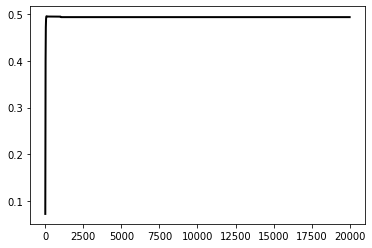

In [18]:
plt.plot(range(int(wc.params['duration']/wc.params['dt'])), ex[0].tolist(), c='k', lw = 2)